# Importing Libraries

In [ ]:
! pip install catboost

# General imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Model selection
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    StratifiedKFold  # For classification
)

# Regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge, SGDRegressor, PoissonRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR, LinearSVR
from xgboost import XGBRegressor

# Classification models (added)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

# Preprocessing/feature engineering
from sklearn.preprocessing import PolynomialFeatures
from sklearn.kernel_approximation import Nystroem

# Metrics (regression + classification)
from sklearn.metrics import (
    mean_squared_error, r2_score,  # Regression
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,  # Classification
    confusion_matrix, RocCurveDisplay, make_scorer
)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Reading Files

Find games that Gamalytic has, but info_base_game_csv does not. by fetch steam api

In [ ]:
demos=pd.read_csv('demos.csv')
dlcs=pd.read_csv('dlcs.csv')
gamalytic_steam_games=pd.read_csv('gamalytic_steam_games.csv')
info_base_steam_games=pd.read_csv('info_base_games.csv')
extracted_data=pd.read_csv('extracted_data.csv', header=None, names=['name', 'release_date', 'is_free', 'price', 'genres', 'metacritic', 'has_dlc', 'has_demo', 'supported_platforms', 'steam_achievements', 'steam_trading_cards', 'workshop_support', 'achievements_total'])
classified_gamalytic_steam_games = pd.read_csv('ms2_gamalytic_steam_games.csv')

<ipython-input-161-02a31a9596da>:4: DtypeWarning: Columns (0,2,7) have mixed types. Specify dtype option on import or set low_memory=False.
  info_base_steam_games=pd.read_csv('info_base_games.csv')


# Exploring The Data

In [ ]:
print(demos.shape)
print(dlcs.shape)
print(gamalytic_steam_games.shape)
print(info_base_steam_games.shape)

(15449, 4)
(5445, 3)
(93338, 6)
(99167, 10)


In [ ]:
info_base_steam_games.head()

,appid,name,metacritic,steam_achievements,steam_trading_cards,workshop_support,genres,achievements_total,release_date,supported_platforms
0,2574000,Femboy Burgers,NaN,True,True,True,"Casual, Indie",NaN,"Oct 9, 2023","['windows', 'mac', 'linux']"
1,2574120,PPA Pickleball Tour 2025,NaN,True,True,True,"Indie, Simulation, Sports",18,"Jul 16, 2024","['windows', 'mac', 'linux']"
2,2573200,Squeaky Squad,NaN,True,True,True,"Action, Adventure, Indie",27,"Mar 29, 2024","['windows', 'mac', 'linux']"
3,2573440,Paradox Metal,NaN,True,True,True,"Action, Early Access",NaN,Coming soon,"['windows', 'mac', 'linux']"
4,2569520,Naturpark Lillebælt VR,NaN,True,True,True,"Action, Adventure",NaN,"Sep 18, 2023","['windows', 'mac', 'linux']"


In [ ]:
gamalytic_steam_games.head()

,steamId,price,copiesSold,publisherClass,reviewScore,aiContent
0,730,0.0,302158048,AAA,87,NaN
1,570,0.0,212896574,AAA,82,NaN
2,578080,0.0,161971233,AAA,59,NaN
3,440,0.0,99060457,AAA,90,NaN
4,1172470,0.0,67554185,AAA,67,NaN


In [ ]:
dlcs.head()

,base_appid,dlc_appid,name
0,1786750,2568660,家出王女 - 全年齢版ストーリー&グラフィック追加 DLC
1,1981700,2563730,Jacob's Quest - Voyage
2,2009450,2552980,Invector: Rhythm Galaxy - Latin Power Song Pack
3,1133420,2550750,Hero or Villain: Genesis — Supercharged!
4,2533950,2551000,Hot And Lovely ：Uniform - adult patch


In [ ]:
demos.head()

,Unnamed: 0,full_game_appid,demo_appid,name
0,0,2214650,2573370,Rolando Deluxe Demo
1,1,1439980,2573460,Outrunner: Neon Nights Demo
2,2,2412240,2572840,Bubble Ghost Remake Demo
3,3,2448830,2572240,Time Handlers Demo
4,4,2379590,2570800,Hope's Final Defense Demo


In [ ]:
info_base_steam_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99167 entries, 0 to 99166
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   appid                99167 non-null  object
 1   name                 99149 non-null  object
 2   metacritic           3019 non-null   object
 3   steam_achievements   99167 non-null  bool  
 4   steam_trading_cards  99167 non-null  bool  
 5   workshop_support     99167 non-null  bool  
 6   genres               94389 non-null  object
 7   achievements_total   38115 non-null  object
 8   release_date         98861 non-null  object
 9   supported_platforms  99167 non-null  object
dtypes: bool(3), object(7)
memory usage: 5.6+ MB


In [ ]:
gamalytic_steam_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93338 entries, 0 to 93337
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   steamId         93338 non-null  int64  
 1   price           93338 non-null  float64
 2   copiesSold      93338 non-null  int64  
 3   publisherClass  93338 non-null  object 
 4   reviewScore     93338 non-null  int64  
 5   aiContent       0 non-null      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 4.3+ MB


In [ ]:
demos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15449 entries, 0 to 15448
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       15449 non-null  int64 
 1   full_game_appid  15449 non-null  object
 2   demo_appid       15449 non-null  object
 3   name             15448 non-null  object
dtypes: int64(1), object(3)
memory usage: 482.9+ KB


In [ ]:
dlcs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5445 entries, 0 to 5444
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   base_appid  5445 non-null   object
 1   dlc_appid   5445 non-null   object
 2   name        5445 non-null   object
dtypes: object(3)
memory usage: 127.7+ KB


In [ ]:
extracted_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19999 entries, 0 to 999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   name                 19999 non-null  object 
 1   release_date         19998 non-null  object 
 2   is_free              19999 non-null  bool   
 3   price                19999 non-null  float64
 4   genres               19978 non-null  object 
 5   metacritic           870 non-null    float64
 6   has_dlc              19999 non-null  bool   
 7   has_demo             19999 non-null  bool   
 8   supported_platforms  19999 non-null  object 
 9   steam_achievements   19999 non-null  bool   
 10  steam_trading_cards  19999 non-null  bool   
 11  workshop_support     19999 non-null  bool   
 12  achievements_total   19999 non-null  int64  
dtypes: bool(6), float64(2), int64(1), object(4)
memory usage: 1.3+ MB


In [ ]:
dlcs.head()

,base_appid,dlc_appid,name
0,1786750,2568660,家出王女 - 全年齢版ストーリー&グラフィック追加 DLC
1,1981700,2563730,Jacob's Quest - Voyage
2,2009450,2552980,Invector: Rhythm Galaxy - Latin Power Song Pack
3,1133420,2550750,Hero or Villain: Genesis — Supercharged!
4,2533950,2551000,Hot And Lovely ：Uniform - adult patch


### Merging Info with Extracted Data

We found that the word 'genre' is a literal value in the column which should not be possible so we saw the exact row where this is happening and found that all columns names where in this row so we concluded that this was from merging two datasets without removing the header and it also happened in two other files so we dropped these rows since it will hinder our usage for the column since it will not accept to type cast it

In [ ]:
print(info_base_steam_games[info_base_steam_games['genres']=='genres'])#drop this row 9929
info_base_steam_games.drop(info_base_steam_games[info_base_steam_games['genres']=='genres'].index, axis=0, inplace=True)

            appid  name  metacritic  steam_achievements  steam_trading_cards  workshop_support  genres  achievements_total  release_date          supported_platforms
9929  steam_appid  name  metacritic                True                 True              True  genres  achievements_total  release_date  ['windows', 'mac', 'linux']


We collected all the missing rows in info that existed in the analytics data set using steam store front api and there were some of them that returned various errors and we forgot to save their ids but we were fetching it based ont the order of analytics data set so we first merged it based on its order with the analytics data set to get the ids then we concatenated it with info data set so that we don't change the code since we collected the data after we finished most of the work

In [ ]:
info_base_steam_games['appid'] = info_base_steam_games['appid'].astype(int)


In [ ]:
error_app_ids = [
    # Not Found Errors (❌)
    2215430, 537180, 384980, 2172010, 2383020, 2204230, 2616430, 433290,
    2063550, 1928910, 2221260, 1218950, 1925770,

    # 429 Client Errors (⚠️)
    565720, 401690, 411330, 514660, 358070, 390660, 381100, 3183280,
    398980, 387870, 512560, 366690, 461880, 1271540, 357600, 1919470,
    395350, 536040, 556740, 557880, 448710, 543030, 1240060, 2185930,
    2382250, 1945030, 545040, 1216490, 1448750, 2005050, 581910, 525380,
    393920, 466720, 2512820, 503480, 544840, 462730, 1422540, 2233600,
    565860, 573170, 558450, 388840, 400510, 1949370, 443420, 394850,
    1426110, 2367470, 576310, 1209000, 445020, 575860, 2385140, 404180,
    1991570, 356250, 1446720, 528730, 1422420, 500870, 2236880, 465130,
    2150660, 561440, 556340, 495700, 2178570, 1934100, 364820, 2613610,
    2215650, 403860, 406730, 414370, 543010, 2539820, 397190, 2168760,
    1211110, 2236920, 1437850, 2533870, 401800, 467680, 414950, 452970,
    405760, 1247100, 418670, 2524480, 2194610, 358290, 425650, 399780,
    1442170, 2200470, 1994220, 461760, 555850, 370710, 510680, 542280,
    528640, 438720, 2190230, 521790, 402210, 1260960, 508260, 554280,
    2176930, 2062210, 2125160, 3229170, 437730, 479990, 383100, 546550,
    535700, 571020, 2399310, 388430, 2609500, 493320, 581820, 1272110,
    390210, 444410, 397780, 1237870, 1447490, 386160, 361890, 468050,
    413030, 473810, 494960, 520610, 421630, 1229420, 362130, 503450,
    570900, 401120, 508820, 582980, 3242750, 399720, 572020, 2217810,
    1992580, 2240910, 1981710, 1441740, 1178150, 2635530, 1431720,
    495750, 2617800, 580890, 1240480, 2077380, 535460, 470760, 455490,
    2119670, 499400, 589480, 365330, 1186880, 461400, 562640, 1431350,
    1417340, 1418390, 495780, 544710, 1180370, 2184590, 403070, 548720,
    1203890, 2079180, 2159650, 503460, 2239130, 2538910, 555260,
    2177210, 2529930, 453990, 577290, 1239580, 2019220, 2400590,
    2591380, 582920, 2524610, 550370, 2129160, 2506730, 1446480,
    397820, 547710, 512410, 2397140, 2016350, 1219020, 513990, 2172630,
    546790, 412250, 428210, 500110, 467490, 1197320, 1951540, 1216550,
    433590, 391640, 2176450, 575430, 545620, 1977910, 553440, 577440,
    541350, 416340, 359160, 1236450, 509070, 1267400, 1213390, 412380,
    1271690, 2194000, 2145810, 1226540, 588750, 2382570, 2391870,
    552540, 465510, 2522530, 2618830, 543530, 2520950, 2175700,
    3568390, 2600660, 2597450, 454690, 493710, 508910, 1425770, 1254480,
    1215550, 1430200, 458700, 1185730, 516820, 2146140, 2249070, 381800,
    587790, 1428320, 2239320, 1941340, 1931980, 1179400, 2000210,
    2163030, 546180, 556300, 1995600, 2184010, 2202690, 566930, 2010380,
    2626410, 2050530, 1199560, 1273010, 1253160, 2507080, 540410,
    2216970, 2171550, 445170, 1222640, 1948240, 1245370, 3539440,
    381310, 2505840, 1202790, 1218230, 2620940, 1928650, 1237260,
    1236040, 418640, 1214920, 2635070, 2173670, 1182970, 494980,
    2213660, 1199140, 517140, 455230, 2057790, 2207110, 2179260,
    498280, 506840, 2538330, 498450, 361560, 1206230, 1988030, 397670,
    392370, 528860, 1967940, 2624410, 1995580, 520370, 2533050, 1987590,
    1192740, 435140, 2123050, 1432350, 1258730, 1234830, 2126500,
    2068120, 2517800, 2594810, 2373800, 2384720, 1426370, 2505440,
    2500470, 1937200, 527880, 527910, 1189730, 1236960, 1993530,
    2126630, 399900, 3339350, 1923080, 527890, 1247920, 518610, 562310,
    1966660, 566200, 396610, 2164220, 477910, 1419190, 2127590, 571550,
    1247650, 1925600, 1202630, 1273320, 2138230, 2135630, 1427320,
    1229510, 3519830, 1983480, 1948930, 1207540, 1950310, 1180940,
    2246740, 2253710, 413490, 2149660, 551130, 1986990, 508610,
    1203810, 2402920, 2214480, 1255870,

    # Other Errors
    2139630, 451330, 529640, 3237590, 553330, 483820, 449560,
    2227040, 1968880, 514530, 1971930
]

In [ ]:
x = gamalytic_steam_games.merge(info_base_steam_games, how='left', left_on='steamId', right_on='appid')
print( 0, len(x[x['copiesSold'] == 0]['copiesSold']))
for i in range(0, 10):
    lower = 10**(i-1)
    upper = 10**i
    count = len(x[x['copiesSold'] <= upper]['copiesSold']) - len(x[x['copiesSold'] <= lower]['copiesSold'])
    print(upper, count)

0 14
1 7806
10 301
100 20718
1000 27193
10000 22332
100000 11577
1000000 3823
10000000 1001
100000000 89
1000000000 3


In [ ]:
x = gamalytic_steam_games.merge(info_base_steam_games, how='left', left_on='steamId', right_on='appid')
x = x[x['appid'].isnull()]
print( 0, len(x[x['copiesSold'] == 0]['copiesSold']))
for i in range(0, 10):
    lower = 10**(i-1)
    upper = 10**i
    count = len(x[x['copiesSold'] <= upper]['copiesSold']) - len(x[x['copiesSold'] <= lower]['copiesSold'])
    print(upper, count)

print(x['steamId'].to_csv('steam_id.csv'))

0 5
1 1894
10 59
100 5205
1000 7170
10000 6488
100000 3445
1000000 966
10000000 177
100000000 20
1000000000 0
None


In [ ]:
x

,steamId,price,copiesSold,publisherClass,reviewScore,aiContent,appid,name,metacritic,steam_achievements,steam_trading_cards,workshop_support,genres,achievements_total,release_date,supported_platforms
25,413150,14.99,26946359,AA,98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,444090,0.00,25137517,AA,85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,1203220,0.00,21456435,AA,75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,433850,0.00,19843562,Indie,56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,1174180,59.99,19044603,AAA,92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94851,492100,2.99,0,Hobbyist,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94852,582110,7.99,0,Hobbyist,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94853,514510,9.99,0,Indie,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94854,497380,14.99,0,Indie,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
cols = ['name', 'release_date', 'genres', 'metacritic', 'supported_platforms',
        'steam_achievements', 'steam_trading_cards', 'workshop_support', 'achievements_total']
col_index = [0, 1, 4, 5, 8, 9, 10, 11, 12]
# x.drop(inplace=True, labels=cols, axis=1)
# Select valid rows (where steamId is NOT in error_app_ids)
valid_rows = x.loc[~x['steamId'].isin(error_app_ids)].iloc[:19999]
print(valid_rows)
valid_rows = extracted_data = pd.concat([valid_rows['steamId'].reset_index(), extracted_data.reset_index()], axis=1)
# pd.concat([merged_data.reset_index(), valid_rows.reset_index()], axis=0)
valid_rows

       steamId  price  copiesSold publisherClass  reviewScore  aiContent  appid name metacritic steam_achievements steam_trading_cards workshop_support genres achievements_total release_date supported_platforms
25      413150  14.99    26946359             AA           98        NaN    NaN  NaN        NaN                NaN                 NaN              NaN    NaN                NaN          NaN                 NaN
27      444090   0.00    25137517             AA           85        NaN    NaN  NaN        NaN                NaN                 NaN              NaN    NaN                NaN          NaN                 NaN
34     1203220   0.00    21456435             AA           75        NaN    NaN  NaN        NaN                NaN                 NaN              NaN    NaN                NaN          NaN                 NaN
36      433850   0.00    19843562          Indie           56        NaN    NaN  NaN        NaN                NaN                 NaN              NaN    N

,index,steamId,index,name,release_date,is_free,price,genres,metacritic,has_dlc,has_demo,supported_platforms,steam_achievements,steam_trading_cards,workshop_support,achievements_total
0,25,413150,0,Stardew Valley,"26 Feb, 2016",False,5.99,"Indie, RPG, Simulation",89.0,True,False,"['windows', 'mac', 'linux']",True,True,False,49
1,27,444090,1,Paladins®,"8 May, 2018",True,0.00,"Action, Adventure, Massively Multiplayer, Stra...",83.0,True,False,['windows'],True,True,False,58
2,34,1203220,2,NARAKA: BLADEPOINT,"11 Aug, 2021",True,0.00,"Action, Adventure, Massively Multiplayer",NaN,True,False,['windows'],True,True,False,40
3,36,433850,3,Z1 Battle Royale,"28 Feb, 2018",True,0.00,"Action, Adventure, Free To Play, Massively Mul...",70.0,False,False,['windows'],False,False,False,0
4,39,1174180,4,Red Dead Redemption 2,"5 Dec, 2019",False,59.99,"Action, Adventure",93.0,False,False,['windows'],True,False,False,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19994,74448,1257000,995,A Week In The Cold,"26 Jun, 2020",False,3.99,"Adventure, Casual, Indie",NaN,False,True,['windows'],True,False,False,8
19995,74449,1235770,996,Volleyballed,"18 Jun, 2020",False,2.99,"Casual, Indie, Simulation, Sports",NaN,False,False,['windows'],True,False,False,11
19996,74458,2014220,997,Game Cycle,"20 Jan, 2023",False,4.99,"Action, Casual, Indie",NaN,False,True,['windows'],False,False,False,0
19997,74462,1965940,998,Ninja Sneaking R,"20 May, 2022",False,4.99,Action,NaN,False,False,['windows'],False,False,False,0


In [ ]:
valid_rows = valid_rows.drop( labels=['index', 'has_dlc', 'has_demo', 'is_free', 'price'], axis=1)
valid_rows = valid_rows.rename(columns={'steamId':'appid'})
valid_rows

,appid,name,release_date,genres,metacritic,supported_platforms,steam_achievements,steam_trading_cards,workshop_support,achievements_total
0,413150,Stardew Valley,"26 Feb, 2016","Indie, RPG, Simulation",89.0,"['windows', 'mac', 'linux']",True,True,False,49
1,444090,Paladins®,"8 May, 2018","Action, Adventure, Massively Multiplayer, Stra...",83.0,['windows'],True,True,False,58
2,1203220,NARAKA: BLADEPOINT,"11 Aug, 2021","Action, Adventure, Massively Multiplayer",NaN,['windows'],True,True,False,40
3,433850,Z1 Battle Royale,"28 Feb, 2018","Action, Adventure, Free To Play, Massively Mul...",70.0,['windows'],False,False,False,0
4,1174180,Red Dead Redemption 2,"5 Dec, 2019","Action, Adventure",93.0,['windows'],True,False,False,51
...,...,...,...,...,...,...,...,...,...,...
19994,1257000,A Week In The Cold,"26 Jun, 2020","Adventure, Casual, Indie",NaN,['windows'],True,False,False,8
19995,1235770,Volleyballed,"18 Jun, 2020","Casual, Indie, Simulation, Sports",NaN,['windows'],True,False,False,11
19996,2014220,Game Cycle,"20 Jan, 2023","Action, Casual, Indie",NaN,['windows'],False,False,False,0
19997,1965940,Ninja Sneaking R,"20 May, 2022",Action,NaN,['windows'],False,False,False,0


In [ ]:
info_base_steam_games

,appid,name,metacritic,steam_achievements,steam_trading_cards,workshop_support,genres,achievements_total,release_date,supported_platforms
0,2574000,Femboy Burgers,NaN,True,True,True,"Casual, Indie",NaN,"Oct 9, 2023","['windows', 'mac', 'linux']"
1,2574120,PPA Pickleball Tour 2025,NaN,True,True,True,"Indie, Simulation, Sports",18,"Jul 16, 2024","['windows', 'mac', 'linux']"
2,2573200,Squeaky Squad,NaN,True,True,True,"Action, Adventure, Indie",27,"Mar 29, 2024","['windows', 'mac', 'linux']"
3,2573440,Paradox Metal,NaN,True,True,True,"Action, Early Access",NaN,Coming soon,"['windows', 'mac', 'linux']"
4,2569520,Naturpark Lillebælt VR,NaN,True,True,True,"Action, Adventure",NaN,"Sep 18, 2023","['windows', 'mac', 'linux']"
...,...,...,...,...,...,...,...,...,...,...
99162,1548850,Six Days in Fallujah,NaN,True,False,False,"Action, Early Access",34.0,"Jun 22, 2023",['windows']
99163,2478130,PROJECT SURVIVAL #Working title,NaN,False,False,False,"Action, Adventure, RPG",NaN,Coming soon,['windows']
99164,3272980,Siren's Well,NaN,True,False,False,"Action, Adventure",NaN,Coming soon,"['windows', 'linux']"
99165,2054150,Tower Defender VR: Last Adventure,NaN,False,False,False,"Casual, Indie, RPG, Strategy",NaN,"Jul 8, 2022",['windows']


In [ ]:
info_base_steam_games = pd.concat([valid_rows, info_base_steam_games])
info_base_steam_games

,appid,name,release_date,genres,metacritic,supported_platforms,steam_achievements,steam_trading_cards,workshop_support,achievements_total
0,413150,Stardew Valley,"26 Feb, 2016","Indie, RPG, Simulation",89.0,"['windows', 'mac', 'linux']",True,True,False,49
1,444090,Paladins®,"8 May, 2018","Action, Adventure, Massively Multiplayer, Stra...",83.0,['windows'],True,True,False,58
2,1203220,NARAKA: BLADEPOINT,"11 Aug, 2021","Action, Adventure, Massively Multiplayer",NaN,['windows'],True,True,False,40
3,433850,Z1 Battle Royale,"28 Feb, 2018","Action, Adventure, Free To Play, Massively Mul...",70.0,['windows'],False,False,False,0
4,1174180,Red Dead Redemption 2,"5 Dec, 2019","Action, Adventure",93.0,['windows'],True,False,False,51
...,...,...,...,...,...,...,...,...,...,...
99162,1548850,Six Days in Fallujah,"Jun 22, 2023","Action, Early Access",NaN,['windows'],True,False,False,34.0
99163,2478130,PROJECT SURVIVAL #Working title,Coming soon,"Action, Adventure, RPG",NaN,['windows'],False,False,False,NaN
99164,3272980,Siren's Well,Coming soon,"Action, Adventure",NaN,"['windows', 'linux']",True,False,False,NaN
99165,2054150,Tower Defender VR: Last Adventure,"Jul 8, 2022","Casual, Indie, RPG, Strategy",NaN,['windows'],False,False,False,NaN


### Merging info, dlc, demo, and analytics together

In [ ]:
for i in info_base_steam_games.columns :
  print(i," : ",info_base_steam_games[i].nunique())

appid  :  115722
name  :  114690
release_date  :  7707
genres  :  2872
metacritic  :  174
supported_platforms  :  7
steam_achievements  :  2
steam_trading_cards  :  2
workshop_support  :  2
achievements_total  :  752


We found that the word 'genre' is a literal value in the column which should not be possible so we saw the exact row where this is happening and found that all columns names where in this row so we concluded that this was from merging two datasets without removing the header and it also happened in two other files so we dropped these rows since it will hinder our usage for the column since it will not accept to type cast it

In [ ]:
genres=set()

for i in info_base_steam_games['genres'] :
  if type(i) is str :
    genres.update(j.strip() for j in i.split(','))
  elif pd.notnull(i):
    print(i)

print(len(genres))
print(genres)

35
{'Short', 'Free To Play', 'Animation & Modeling', 'Utilities', 'Game Development', 'Massively Multiplayer', 'Gore', 'Nudity', 'Episodic', 'Simulation', 'Accounting', 'Indie', 'Software Training', 'Violent', 'Video Production', 'Tutorial', '360 Video', 'Sports', 'Casual', 'Adventure', 'Design & Illustration', 'Strategy', 'Education', '模拟', 'Action', 'Sexual Content', 'Web Publishing', 'Photo Editing', 'Documentary', 'Audio Production', 'Early Access', 'RPG', '独立', 'Movie', 'Racing'}


In [ ]:
dlcs.drop(labels=dlcs[dlcs['base_appid'] == 'base_appid'].index, axis=0, inplace=True)

In [ ]:
demos.drop(labels= demos[demos['full_game_appid'] == 'full_game_appid'].index, axis=0, inplace=True)

we changed the type of columns so that we can use them to merge the dataframes since comparing different data types make errors in the condition

In [ ]:
info_base_steam_games['appid'] = info_base_steam_games['appid'].astype(int)
dlcs['base_appid'] = dlcs['base_appid'].astype(int)
demos['full_game_appid'] = demos['full_game_appid'].astype(int)

We checked that the dlc and demo data sets don't contain duplicate base games (like a game that has 2 dlcs) since this will be a problem when we merge it with the info and analytics data set

In [ ]:
demos['full_game_appid'].duplicated().sum()

np.int64(0)

In [ ]:
dlcs['base_appid'].duplicated().sum()

np.int64(0)

In [ ]:
merged_data = gamalytic_steam_games.merge(info_base_steam_games, how='inner', left_on='steamId', right_on='appid')\
                                   .merge(dlcs, how='left', left_on='steamId', right_on='base_appid')\
                                   .merge(demos, how='left', left_on='steamId', right_on='full_game_appid')\
                                   .merge(classified_gamalytic_steam_games, how='inner', left_on='steamId', right_on='steamId', suffixes=('', '_class'))
merged_data


,steamId,price,copiesSold,publisherClass,reviewScore,aiContent,appid,name_x,release_date,genres,metacritic,supported_platforms,steam_achievements,steam_trading_cards,workshop_support,achievements_total,base_appid,dlc_appid,name_y,Unnamed: 0,full_game_appid,demo_appid,name,price_class,copiesSold_class,publisherClass_class,reviewScore_class,aiContent_class
0,730,0.00,302158048,AAA,87,NaN,730,Counter-Strike 2,"Aug 21, 2012","Action, Free To Play",NaN,"['windows', 'linux']",False,True,True,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,Platinum,AAA,87,NaN
1,570,0.00,212896574,AAA,82,NaN,570,Dota 2,"Jul 9, 2013","Action, Strategy, Free To Play",90.0,"['windows', 'mac', 'linux']",False,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,Platinum,AAA,82,NaN
2,578080,0.00,161971233,AAA,59,NaN,578080,PUBG: BATTLEGROUNDS,"Dec 21, 2017","Action, Adventure, Massively Multiplayer, Free...",NaN,['windows'],False,False,False,37.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,Platinum,AAA,59,NaN
3,440,0.00,99060457,AAA,90,NaN,440,Team Fortress 2,"Oct 10, 2007","Action, Free To Play",92.0,"['windows', 'linux']",True,True,True,520.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,Platinum,AAA,90,NaN
4,1172470,0.00,67554185,AAA,67,NaN,1172470,Apex Legends™,"Nov 4, 2020","Action, Adventure, Free To Play",88.0,['windows'],True,True,False,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,Platinum,AAA,67,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89422,738230,4.99,0,Hobbyist,0,NaN,738230,High Noon,"Nov 6, 2017","Action, Simulation, Early Access",NaN,['windows'],False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.99,Bronze,Hobbyist,0,NaN
89423,713550,4.99,0,Hobbyist,0,NaN,713550,Hikaru's Cube,"Sep 15, 2017","Action, Casual, Indie, Early Access",NaN,['windows'],False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.99,Bronze,Hobbyist,0,NaN
89424,700050,0.99,0,Hobbyist,0,NaN,700050,Bees Knees,"Sep 4, 2017","Action, Casual, Indie",NaN,['windows'],True,False,False,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.99,Bronze,Hobbyist,0,NaN
89425,679960,0.99,0,Hobbyist,0,NaN,679960,Brain Crush,"Aug 18, 2017",Indie,NaN,['windows'],False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.99,Bronze,Hobbyist,0,NaN


we dropped columns that don't have any use and redundant columns

In [ ]:
merged_data.drop(labels=['Unnamed: 0', 'base_appid', 'full_game_appid', 'aiContent', 'appid', 'price_class', 'publisherClass_class', 'reviewScore_class', 'aiContent_class'], axis=1, inplace=True)
merged_data.rename(columns={'name_x': 'base_game_name', 'name_y': 'dlc_game_name', 'name': 'demo_game_name'}, inplace=True)

In [ ]:
print( 0, len(merged_data[merged_data['copiesSold'] == 0]['copiesSold']))

for i in range(0, 10):
    lower = 10**(i-1)
    upper = 10**i
    count = len(merged_data[merged_data['copiesSold'] <= upper]['copiesSold']) - len(merged_data[merged_data['copiesSold'] <= lower]['copiesSold'])
    print(upper, count)


0 9
1 5912
10 242
100 17653
1000 27080
10000 22120
100000 11497
1000000 3823
10000000 999
100000000 89
1000000000 3


In [ ]:
merged_data

,steamId,price,copiesSold,publisherClass,reviewScore,base_game_name,release_date,genres,metacritic,supported_platforms,steam_achievements,steam_trading_cards,workshop_support,achievements_total,dlc_appid,dlc_game_name,demo_appid,demo_game_name,copiesSold_class
0,730,0.00,302158048,AAA,87,Counter-Strike 2,"Aug 21, 2012","Action, Free To Play",NaN,"['windows', 'linux']",False,True,True,1.0,NaN,NaN,NaN,NaN,Platinum
1,570,0.00,212896574,AAA,82,Dota 2,"Jul 9, 2013","Action, Strategy, Free To Play",90.0,"['windows', 'mac', 'linux']",False,True,True,NaN,NaN,NaN,NaN,NaN,Platinum
2,578080,0.00,161971233,AAA,59,PUBG: BATTLEGROUNDS,"Dec 21, 2017","Action, Adventure, Massively Multiplayer, Free...",NaN,['windows'],False,False,False,37.0,NaN,NaN,NaN,NaN,Platinum
3,440,0.00,99060457,AAA,90,Team Fortress 2,"Oct 10, 2007","Action, Free To Play",92.0,"['windows', 'linux']",True,True,True,520.0,NaN,NaN,NaN,NaN,Platinum
4,1172470,0.00,67554185,AAA,67,Apex Legends™,"Nov 4, 2020","Action, Adventure, Free To Play",88.0,['windows'],True,True,False,12.0,NaN,NaN,NaN,NaN,Platinum
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89422,738230,4.99,0,Hobbyist,0,High Noon,"Nov 6, 2017","Action, Simulation, Early Access",NaN,['windows'],False,False,False,NaN,NaN,NaN,NaN,NaN,Bronze
89423,713550,4.99,0,Hobbyist,0,Hikaru's Cube,"Sep 15, 2017","Action, Casual, Indie, Early Access",NaN,['windows'],False,False,False,NaN,NaN,NaN,NaN,NaN,Bronze
89424,700050,0.99,0,Hobbyist,0,Bees Knees,"Sep 4, 2017","Action, Casual, Indie",NaN,['windows'],True,False,False,11,NaN,NaN,NaN,NaN,Bronze
89425,679960,0.99,0,Hobbyist,0,Brain Crush,"Aug 18, 2017",Indie,NaN,['windows'],False,False,False,NaN,NaN,NaN,NaN,NaN,Bronze


# Preprocessing

## Dealing With Nulls

In [ ]:
merged_data.isna().sum()

,0
steamId,0
price,0
copiesSold,0
publisherClass,0
reviewScore,0
base_game_name,0
release_date,3
genres,125
metacritic,85624
supported_platforms,0


### Achievments Total

Since achievements total means the total number of achievments we can fill any nulls with zeros since it will imply the same meaning

In [ ]:
merged_data['achievements_total'] = merged_data['achievements_total'].fillna(0)
# merged_data.drop(labels='steam_achievements', axis=1, inplace=True)

In [ ]:
merged_data[merged_data['achievements_total'].isna()]
# change total values to 0 not nan

,steamId,price,copiesSold,publisherClass,reviewScore,base_game_name,release_date,genres,metacritic,supported_platforms,steam_achievements,steam_trading_cards,workshop_support,achievements_total,dlc_appid,dlc_game_name,demo_appid,demo_game_name,copiesSold_class


### Release Date

In [ ]:
merged_data[merged_data['release_date'].isna()]

,steamId,price,copiesSold,publisherClass,reviewScore,base_game_name,release_date,genres,metacritic,supported_platforms,steam_achievements,steam_trading_cards,workshop_support,achievements_total,dlc_appid,dlc_game_name,demo_appid,demo_game_name,copiesSold_class
449,242050,39.99,2760086,Hobbyist,89,Assassin’s Creed® IV Black Flag™,NaN,"Action, Adventure",NaN,['windows'],True,False,False,60,NaN,NaN,NaN,NaN,Platinum
3541,237570,0.00,174782,Hobbyist,80,Penny Arcade's On the Rain-Slick Precipice of ...,NaN,"Indie, RPG",NaN,['windows'],False,True,False,0,NaN,NaN,NaN,NaN,Platinum
3699,564310,14.99,161583,Hobbyist,93,Serious Sam Fusion 2017 (beta),NaN,"Action, Indie",NaN,"['windows', 'mac', 'linux']",True,False,True,76,NaN,NaN,NaN,NaN,Platinum


In [ ]:
merged_data.loc[merged_data['steamId'] == 242050, 'release_date'] = pd.to_datetime('19 Nov, 2013')
merged_data.loc[merged_data['steamId'] == 237570, 'release_date'] = pd.to_datetime('January 24, 2013')
merged_data.loc[merged_data['steamId'] == 1210320, 'release_date'] = pd.to_datetime('13 Dec, 2022')
merged_data.drop( inplace = True,labels = merged_data[merged_data['steamId'] == 564310].index, axis=0)


# merged_data.loc[[373, 2751]]

In [ ]:
print(len(merged_data[merged_data['price']==0]))
print(len(merged_data[(merged_data['genres'].str.contains('Free To Play')) & (merged_data['genres'].notna()) ]))
merged_data[(merged_data['price']==0)& (merged_data['genres'].str.contains('Free To Play', na=False)) & (merged_data['genres'].notna()) ]

13928
9250


,steamId,price,copiesSold,publisherClass,reviewScore,base_game_name,release_date,genres,metacritic,supported_platforms,steam_achievements,steam_trading_cards,workshop_support,achievements_total,dlc_appid,dlc_game_name,demo_appid,demo_game_name,copiesSold_class
0,730,0.0,302158048,AAA,87,Counter-Strike 2,"Aug 21, 2012","Action, Free To Play",NaN,"['windows', 'linux']",False,True,True,1.0,NaN,NaN,NaN,NaN,Platinum
1,570,0.0,212896574,AAA,82,Dota 2,"Jul 9, 2013","Action, Strategy, Free To Play",90.0,"['windows', 'mac', 'linux']",False,True,True,0,NaN,NaN,NaN,NaN,Platinum
2,578080,0.0,161971233,AAA,59,PUBG: BATTLEGROUNDS,"Dec 21, 2017","Action, Adventure, Massively Multiplayer, Free...",NaN,['windows'],False,False,False,37.0,NaN,NaN,NaN,NaN,Platinum
3,440,0.0,99060457,AAA,90,Team Fortress 2,"Oct 10, 2007","Action, Free To Play",92.0,"['windows', 'linux']",True,True,True,520.0,NaN,NaN,NaN,NaN,Platinum
4,1172470,0.0,67554185,AAA,67,Apex Legends™,"Nov 4, 2020","Action, Adventure, Free To Play",88.0,['windows'],True,True,False,12.0,NaN,NaN,NaN,NaN,Platinum
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77863,3333630,0.0,29,Hobbyist,100,Mnamosyna,"Dec 8, 2024","Action, Adventure, Free To Play",NaN,['windows'],False,False,False,0,NaN,NaN,NaN,NaN,Bronze
78127,2955740,0.0,26,Hobbyist,100,Shards of Epoch Past,"May 24, 2024","Action, Casual, Free To Play",NaN,['windows'],False,False,False,0,NaN,NaN,NaN,NaN,Bronze
78316,2987480,0.0,25,Hobbyist,100,From Them,"May 30, 2024","Action, Free To Play",NaN,"['windows', 'linux']",False,False,False,0,NaN,NaN,NaN,NaN,Bronze
83505,2570430,0.0,2,Hobbyist,0,Dojo Masters Editor,"Jul 17, 2024",Free To Play,NaN,"['windows', 'mac', 'linux']",True,True,True,0,NaN,NaN,NaN,NaN,Bronze


### Genres

We filled the nulls of the genres the mode of the genres in each publisher class

In [ ]:
merged_data[merged_data['genres'].isna()]

,steamId,price,copiesSold,publisherClass,reviewScore,base_game_name,release_date,genres,metacritic,supported_platforms,steam_achievements,steam_trading_cards,workshop_support,achievements_total,dlc_appid,dlc_game_name,demo_appid,demo_game_name,copiesSold_class
175,241930,19.99,6511308,AA,92,Middle-earth™: Shadow of Mordor™,"Sep 30, 2014",NaN,84,['windows'],True,True,False,74,NaN,NaN,NaN,NaN,Platinum
736,900883,19.99,1584060,AAA,95,The Elder Scrolls IV: Oblivion® Game of the Ye...,"16 Jun, 2009",NaN,94.0,['windows'],False,False,False,0,NaN,NaN,NaN,NaN,Platinum
969,955900,24.99,1157308,Indie,86,Amazing Cultivation Simulator,"Nov 24, 2020",NaN,NaN,['windows'],True,True,True,408,1701600,Amazing Cultivation Simulator - Immortal Tales...,NaN,NaN,Platinum
1095,71250,7.99,997860,AAA,91,Sonic Adventure DX,"Mar 4, 2011",NaN,NaN,['windows'],False,False,False,15.0,NaN,NaN,NaN,NaN,Platinum
1659,1292940,4.99,564342,Indie,98,Cube Escape Collection,"Oct 14, 2020",NaN,NaN,"['windows', 'mac']",True,False,False,72,NaN,NaN,NaN,NaN,Platinum
2414,1347430,1.99,331561,Indie,91,Cute Honey,"Jul 22, 2020",NaN,NaN,['windows'],True,True,False,16,NaN,NaN,NaN,NaN,Platinum
2424,667720,19.99,329361,AAA,80,Red Faction Guerrilla Re-Mars-tered,"Jul 3, 2018",NaN,NaN,['windows'],True,True,False,57.0,NaN,NaN,NaN,NaN,Platinum
2885,1954420,0.00,249432,Indie,52,Riichi City,"Sep 8, 2022",NaN,NaN,"['windows', 'mac', 'linux']",True,True,True,0,NaN,NaN,NaN,NaN,Platinum
3226,22340,4.99,207601,AAA,68,Call of Cthulhu®: Dark Corners of the Earth,"Jun 16, 2009",NaN,76.0,['windows'],False,False,False,0,NaN,NaN,NaN,NaN,Platinum
3861,559210,14.99,149749,Indie,96,Rakuen,"10 May, 2017",NaN,84.0,"['windows', 'mac', 'linux']",True,True,False,15,1331270,Rakuen Animated Short Film - Farmer in the Sky...,NaN,NaN,Platinum


In [ ]:
print(merged_data[merged_data['genres'].isna()]['base_game_name'])

175                       Middle-earth™: Shadow of Mordor™
736      The Elder Scrolls IV: Oblivion® Game of the Ye...
969                          Amazing Cultivation Simulator
1095                                    Sonic Adventure DX
1659                                Cube Escape Collection
2414                                            Cute Honey
2424                   Red Faction Guerrilla Re-Mars-tered
2885                                           Riichi City
3226           Call of Cthulhu®: Dark Corners of the Earth
3861                                                Rakuen
4488                                        Adorable Witch
4707                                        Dwarven Realms
4852                      Sonic the Hedgehog 4 - Episode I
6433                            Portal 2 - The Final Hours
6517                                              SOS OPS!
6588                                          Cute Honey 2
6947                                                 Ven

In [ ]:
merged_data[merged_data['genres'].isna()]

,steamId,price,copiesSold,publisherClass,reviewScore,base_game_name,release_date,genres,metacritic,supported_platforms,steam_achievements,steam_trading_cards,workshop_support,achievements_total,dlc_appid,dlc_game_name,demo_appid,demo_game_name,copiesSold_class
175,241930,19.99,6511308,AA,92,Middle-earth™: Shadow of Mordor™,"Sep 30, 2014",NaN,84,['windows'],True,True,False,74,NaN,NaN,NaN,NaN,Platinum
736,900883,19.99,1584060,AAA,95,The Elder Scrolls IV: Oblivion® Game of the Ye...,"16 Jun, 2009",NaN,94.0,['windows'],False,False,False,0,NaN,NaN,NaN,NaN,Platinum
969,955900,24.99,1157308,Indie,86,Amazing Cultivation Simulator,"Nov 24, 2020",NaN,NaN,['windows'],True,True,True,408,1701600,Amazing Cultivation Simulator - Immortal Tales...,NaN,NaN,Platinum
1095,71250,7.99,997860,AAA,91,Sonic Adventure DX,"Mar 4, 2011",NaN,NaN,['windows'],False,False,False,15.0,NaN,NaN,NaN,NaN,Platinum
1659,1292940,4.99,564342,Indie,98,Cube Escape Collection,"Oct 14, 2020",NaN,NaN,"['windows', 'mac']",True,False,False,72,NaN,NaN,NaN,NaN,Platinum
2414,1347430,1.99,331561,Indie,91,Cute Honey,"Jul 22, 2020",NaN,NaN,['windows'],True,True,False,16,NaN,NaN,NaN,NaN,Platinum
2424,667720,19.99,329361,AAA,80,Red Faction Guerrilla Re-Mars-tered,"Jul 3, 2018",NaN,NaN,['windows'],True,True,False,57.0,NaN,NaN,NaN,NaN,Platinum
2885,1954420,0.00,249432,Indie,52,Riichi City,"Sep 8, 2022",NaN,NaN,"['windows', 'mac', 'linux']",True,True,True,0,NaN,NaN,NaN,NaN,Platinum
3226,22340,4.99,207601,AAA,68,Call of Cthulhu®: Dark Corners of the Earth,"Jun 16, 2009",NaN,76.0,['windows'],False,False,False,0,NaN,NaN,NaN,NaN,Platinum
3861,559210,14.99,149749,Indie,96,Rakuen,"10 May, 2017",NaN,84.0,"['windows', 'mac', 'linux']",True,True,False,15,1331270,Rakuen Animated Short Film - Farmer in the Sky...,NaN,NaN,Platinum


In [ ]:
publisher_class_genre_modes = dict()

for i in merged_data['publisherClass'].unique():
  publisher_class_genre_modes[i] = merged_data[merged_data['publisherClass'] == i]['genres'].mode().iloc[0]
publisher_class_genre_modes

{'AAA': 'Action',
 'Indie': 'Casual, Indie',
 'Hobbyist': 'Casual, Indie',
 'AA': 'Action'}

In [ ]:
for i in merged_data['publisherClass'].unique():
  merged_data.loc[merged_data['publisherClass'] == i, 'genres'] = merged_data.loc[merged_data['publisherClass'] == i, 'genres'].fillna(publisher_class_genre_modes[i])
  merged_data.loc[(merged_data['publisherClass'] == i) & (merged_data['genres'] == ''), 'genres'] = publisher_class_genre_modes[i]
  merged_data.loc[merged_data['publisherClass'] == i, 'genres'] = merged_data.loc[merged_data['publisherClass'] == i, 'genres'].fillna(publisher_class_genre_modes[i])

merged_data[merged_data['genres'].isna()]

,steamId,price,copiesSold,publisherClass,reviewScore,base_game_name,release_date,genres,metacritic,supported_platforms,steam_achievements,steam_trading_cards,workshop_support,achievements_total,dlc_appid,dlc_game_name,demo_appid,demo_game_name,copiesSold_class


### Metacritic

In [ ]:
merged_data['metacritic'] = merged_data['metacritic'].fillna(0)

## Correcting Column Data Types

### Metacritic

In [ ]:
merged_data['metacritic'] = merged_data['metacritic'].astype(float)

### Achievements Total

In [ ]:
merged_data['achievements_total'] = merged_data['achievements_total'].astype(float).astype(int)

### Release Date

Any date that was written as a quarter or a month was rewritten in the correct format and we chose the middle month in each quarter and the first day of it .
We also found some games that have coming soon or to be announced as its release date and had copies sold so we checked them in steam and we found that most of them were already released and most of them were released in March 2025
so we changed it for all of them to March 1, 2025

In [ ]:
x = pd.to_datetime(merged_data['release_date'],format='mixed',  errors='coerce')
merged_data.loc[x[x.isnull()].index, 'release_date'].value_counts()

,count
release_date,
Coming soon,636
Q1 2025,190
Mar-25,120
Feb-25,101
To be announced,72
Apr-25,14
Q2 2025,12
Q4 2025,1
Jul-25,1


In [ ]:
merged_data.iloc[x[x.isnull()].index]

,steamId,price,copiesSold,publisherClass,reviewScore,base_game_name,release_date,genres,metacritic,supported_platforms,steam_achievements,steam_trading_cards,workshop_support,achievements_total,dlc_appid,dlc_game_name,demo_appid,demo_game_name,copiesSold_class
404,3164500,19.99,3061248,AA,98,Schedule I,Mar-25,"Action, Indie, Simulation, Strategy, Early Access",0.0,"['windows', 'mac', 'linux']",True,True,True,0,NaN,NaN,3205720,Schedule I: Free Sample,Platinum
405,3164500,19.99,3061248,AA,98,Schedule I,Mar-25,"Action, Indie, Simulation, Strategy, Early Access",0.0,['windows'],True,False,False,0,NaN,NaN,3205720,Schedule I: Free Sample,Platinum
1381,3419430,0.00,716268,Hobbyist,96,Bongo Cat,To be announced,"Casual, Indie, Simulation, Free To Play",0.0,"['windows', 'mac', 'linux']",True,True,True,0,NaN,NaN,3487310,Bongo Cat Demo,Platinum
2896,3399950,0.99,248013,Indie,91,Your Mother,Feb-25,"Casual, Indie",0.0,['windows'],True,False,True,0,NaN,NaN,NaN,NaN,Platinum
3501,2376580,0.00,177565,Indie,76,TRIBE NINE,Coming soon,"Action, RPG, Free To Play",0.0,['windows'],False,False,False,0,NaN,NaN,3169100,TRIBE NINE Deadly Demo,Platinum
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89407,3457660,0.99,1,Hobbyist,0,WAV OCS Airport Edition v2,"Mar 27, 2025",Strategy,0.0,"['windows', 'mac', 'linux']",True,True,True,0,NaN,NaN,NaN,NaN,Bronze
89410,2930990,0.99,1,Hobbyist,0,Picscape,Coming soon,"Adventure, Casual, Indie, Racing, Strategy",0.0,['windows'],False,False,False,0,NaN,NaN,NaN,NaN,Bronze
89411,3452630,0.99,1,Hobbyist,0,OuPaiWar2 Hua's lake hut,"Feb 27, 2025","Casual, RPG, Simulation, Strategy",0.0,"['windows', 'mac', 'linux']",True,True,True,0,NaN,NaN,NaN,NaN,Bronze
89414,3503950,0.99,1,Hobbyist,50,heart of Y,"Feb 21, 2025",RPG,0.0,['windows'],False,False,False,0,NaN,NaN,NaN,NaN,Bronze


In [ ]:
x = {'2022 年 12 月 13 日	': 'Dec 13, 2022', 'Apr-25': 'Apr 1, 2025', 'Feb-25': 'Feb 1, 2025', 'Mar-25': 'Mar 1, 2025', 'Jul-25': 'Jul 1, 2025', 'Q2 2025': 'May 1, 2025', 'Q1 2025': 'Feb 1, 2025', 'Q4 2025': 'Nov 1, 2025'}
merged_data['release_date'] = merged_data['release_date'].map(lambda m: x.get(m, m))


In [ ]:
x = pd.to_datetime(merged_data['release_date'],format='mixed',  errors='coerce')
merged_data.loc[x[x.isnull()].index, 'release_date'].value_counts()

,count
release_date,
Coming soon,636
To be announced,72


In [ ]:
merged_data.loc[merged_data['release_date'] == 'To be announced'].head(30)
# will change all dates to mar 1, 2025 since most of them are already released and they range from feb to apr and the most being in march

,steamId,price,copiesSold,publisherClass,reviewScore,base_game_name,release_date,genres,metacritic,supported_platforms,steam_achievements,steam_trading_cards,workshop_support,achievements_total,dlc_appid,dlc_game_name,demo_appid,demo_game_name,copiesSold_class
1381,3419430,0.00,716268,Hobbyist,96,Bongo Cat,To be announced,"Casual, Indie, Simulation, Free To Play",0.0,"['windows', 'mac', 'linux']",True,True,True,0,NaN,NaN,3487310,Bongo Cat Demo,Platinum
5399,1796470,19.99,85662,AA,88,HASTE: Broken Worlds,To be announced,"Action, Adventure, Indie, Racing",0.0,['windows'],False,False,False,0,NaN,NaN,NaN,NaN,Platinum
5505,3347400,0.00,82769,Indie,89,GIRLS' FRONTLINE 2: EXILIUM,To be announced,"RPG, Strategy, Free To Play",0.0,"['windows', 'mac', 'linux']",True,True,True,0,NaN,NaN,NaN,NaN,Platinum
11610,1376200,24.99,21224,Indie,93,KARMA: The Dark World,To be announced,"Adventure, Indie, RPG",0.0,['windows'],True,False,False,0,NaN,NaN,NaN,NaN,Gold
12183,2446600,24.99,19224,Indie,96,Dark Deity 2,To be announced,"Adventure, Indie, RPG, Strategy",0.0,['windows'],True,False,False,0,NaN,NaN,NaN,NaN,Gold
14844,2012190,29.99,12467,Indie,70,KAISERPUNK,To be announced,"Simulation, Strategy",0.0,['windows'],False,False,False,0,NaN,NaN,NaN,NaN,Gold
16964,3253630,29.99,9268,Indie,63,Gal Guardians: Servants of the Dark,To be announced,"Action, Adventure",0.0,['windows'],False,False,False,0,NaN,NaN,NaN,NaN,Gold
19223,2523310,9.99,6956,Indie,98,Lingo 2,To be announced,"Adventure, Indie",0.0,['windows'],True,False,False,0,NaN,NaN,NaN,NaN,Gold
23236,1911940,19.99,4364,Indie,79,Twilight Monk,To be announced,"Action, Adventure, Indie, RPG",0.0,['windows'],True,False,False,0,NaN,NaN,NaN,NaN,Silver
25718,3123830,9.99,3319,AA,65,Dread Tomb,To be announced,"Action, Adventure, Indie, RPG",0.0,['windows'],True,False,False,0,NaN,NaN,3172560,诡墓 Demo,Silver


In [ ]:
merged_data.loc[merged_data['release_date'] == 'Coming soon'].iloc[200:300]
# it is the same as to_be_announced so we will treat it as one

,steamId,price,copiesSold,publisherClass,reviewScore,base_game_name,release_date,genres,metacritic,supported_platforms,steam_achievements,steam_trading_cards,workshop_support,achievements_total,dlc_appid,dlc_game_name,demo_appid,demo_game_name,copiesSold_class
62320,3106310,12.99,133,Hobbyist,71,SIGMA WAR NOTES,Coming soon,Action,0.0,['windows'],False,False,False,0,NaN,NaN,3170290,茜格玛战记 Demo,Bronze
62485,3501370,3.99,132,Hobbyist,100,BANNED TAPES,Coming soon,"Adventure, Indie",0.0,"['windows', 'mac', 'linux']",True,True,True,0,NaN,NaN,3502080,BANNED TAPES Demo,Bronze
62602,3137530,3.99,130,Hobbyist,100,Escape from Mutation Station,Coming soon,Adventure,0.0,['windows'],True,False,False,0,NaN,NaN,NaN,NaN,Bronze
62889,3446740,5.99,126,Hobbyist,100,The Random Game,Coming soon,"Action, Adventure, Indie",0.0,['windows'],True,False,False,0,NaN,NaN,NaN,NaN,Bronze
63180,3488610,1.99,125,Hobbyist,94,Bedtime Story : Saint,Coming soon,"Adventure, Indie",0.0,['windows'],True,False,False,0,NaN,NaN,NaN,NaN,Bronze
63216,2987320,0.00,125,Hobbyist,100,Animal Adventure,Coming soon,"Action, Adventure, Casual, Indie, Racing, Spor...",0.0,['windows'],True,False,False,0,NaN,NaN,NaN,NaN,Bronze
63225,2894100,9.99,124,Indie,100,Never Experiment On Cats!,Coming soon,"Action, Casual, Indie, Early Access",0.0,['windows'],False,False,False,0,NaN,NaN,NaN,NaN,Bronze
63270,3175690,0.00,124,Hobbyist,89,Solar Collision Control,Coming soon,"Action, Casual, Indie",0.0,"['windows', 'mac', 'linux']",True,True,True,0,NaN,NaN,3209140,Solar Collision Control Demo,Bronze
63271,3175690,0.00,124,Hobbyist,89,Solar Collision Control,Coming soon,"Action, Casual, Indie",0.0,['windows'],True,False,False,0,NaN,NaN,3209140,Solar Collision Control Demo,Bronze
63277,2655120,19.99,123,Hobbyist,86,Workshop Simulator VR,Coming soon,"Casual, Indie, Simulation",0.0,['windows'],True,False,False,0,NaN,NaN,NaN,NaN,Bronze


In [ ]:
merged_data.loc[(merged_data['release_date'] == 'Coming soon') | (merged_data['release_date'] == 'To be announced'), 'release_date'] = 'Mar 1, 2025'

In [ ]:
x = pd.to_datetime(merged_data['release_date'],format='mixed',  errors='coerce')
merged_data.loc[x[x.isnull()].index, 'release_date'].value_counts()

,count
release_date,


In [ ]:
merged_data['release_date'] = pd.to_datetime(
    merged_data['release_date'],
    errors='coerce',            # bad parses → NaT
    format='mixed' # faster when formats are similar
)
merged_data.loc[:, 'release_date'].value_counts()

,count
release_date,
2025-03-01,834
2025-02-01,312
2024-11-15,144
2024-10-31,143
2024-12-05,143
...,...
2017-01-01,1
2008-08-14,1
2017-06-04,1


In [ ]:
merged_data.describe(include='O')

,publisherClass,base_game_name,genres,supported_platforms,dlc_appid,dlc_game_name,demo_appid,demo_game_name,copiesSold_class
count,89426,89426,89426,89426,4852,4852,8748,8747,89426
unique,4,87279,2234,7,4827,4825,8565,8560,4
top,Hobbyist,Echoes,"Casual, Indie",['windows'],3350730,转生魔塔 - 白金版拓展包,3475520,Bonds Demo,Bronze
freq,48774,5,5318,64041,2,2,2,3,42424


In [ ]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 89426 entries, 0 to 89426
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   steamId              89426 non-null  int64         
 1   price                89426 non-null  float64       
 2   copiesSold           89426 non-null  int64         
 3   publisherClass       89426 non-null  object        
 4   reviewScore          89426 non-null  int64         
 5   base_game_name       89426 non-null  object        
 6   release_date         89426 non-null  datetime64[ns]
 7   genres               89426 non-null  object        
 8   metacritic           89426 non-null  float64       
 9   supported_platforms  89426 non-null  object        
 10  steam_achievements   89426 non-null  bool          
 11  steam_trading_cards  89426 non-null  bool          
 12  workshop_support     89426 non-null  bool          
 13  achievements_total   89426 non-null 

In [ ]:
merged_data['release_date'].min()

Timestamp('1997-06-30 00:00:00')

## Dealing With Inconsistencies

### Steam Achievments

We found that some rows that have true steam_achievements doesn't have achievements_total and vice versa, so we searched for the games in steam and found them. Moreover, We found that the achievenments_total column is the correct one and the steam_achievements column is wrong so we will change it based on the values in the column of achievements_total where any achievemnets_total that equals 0 will be considered false and anything else will be true

In [ ]:
print(merged_data[(merged_data['steam_achievements'] == False)].count())

print("steam achievements is false and there is total and their count is :", len(merged_data[(merged_data['steam_achievements'] == False) &
                            (merged_data['achievements_total'].notna())]))
print("steam achievements is true and there is null and their count is :",len(merged_data[(merged_data['steam_achievements'] == True) &
                            (merged_data['achievements_total'].isna())]))

print(merged_data[(merged_data['steam_achievements'] == False) &
                            (merged_data['achievements_total'].notna())])
print(merged_data[(merged_data['steam_achievements'] == True) &
                            (merged_data['achievements_total'].isna())])



steamId                42548
price                  42548
copiesSold             42548
publisherClass         42548
reviewScore            42548
base_game_name         42548
release_date           42548
genres                 42548
metacritic             42548
supported_platforms    42548
steam_achievements     42548
steam_trading_cards    42548
workshop_support       42548
achievements_total     42548
dlc_appid               1315
dlc_game_name           1315
demo_appid              3175
demo_game_name          3174
copiesSold_class       42548
dtype: int64
steam achievements is false and there is total and their count is : 42548
steam achievements is true and there is null and their count is : 0
       steamId  price  copiesSold publisherClass  reviewScore         base_game_name release_date                                             genres  metacritic          supported_platforms  steam_achievements  steam_trading_cards  workshop_support  achievements_total dlc_appid dlc_game_name d

In [ ]:
merged_data['steam_achievements'] = [True if i > 0 else False for i in merged_data['achievements_total']]

### Workshop Support and Steam Trading Cards

When we were checking if all of the data is true we found some games that have incorrect workshop_support and steam_trading_cards values so we kept digging till we found that most game that have less than 20000 copies sold and have true true values are in fact wrong and should be false false this is after we checked more than 200 games with various number of copies Sold value

In [ ]:
merged_data[(merged_data['workshop_support'] == True) & (merged_data['steam_trading_cards'] == True) & (merged_data['copiesSold'] == 1)].head(200)
# there are some workshop_support witch is wrong

,steamId,price,copiesSold,publisherClass,reviewScore,base_game_name,release_date,genres,metacritic,supported_platforms,steam_achievements,steam_trading_cards,workshop_support,achievements_total,dlc_appid,dlc_game_name,demo_appid,demo_game_name,copiesSold_class
83529,3200830,199.99,1,Hobbyist,50,Cave Ghost,2024-09-17,"Action, Adventure, Casual, Indie, Strategy",0.0,"['windows', 'mac', 'linux']",False,True,True,0,NaN,NaN,NaN,NaN,Bronze
83530,3192540,199.99,1,Hobbyist,67,Deep Sea Pursuit,2024-09-19,Action,0.0,"['windows', 'mac', 'linux']",False,True,True,0,NaN,NaN,NaN,NaN,Bronze
83531,3206370,199.99,1,Hobbyist,44,Island Treasure Chase,2024-09-19,"Action, Adventure",0.0,"['windows', 'mac', 'linux']",False,True,True,0,NaN,NaN,NaN,NaN,Bronze
83532,3192510,199.99,1,Hobbyist,40,Star Runaway,2024-09-19,Action,0.0,"['windows', 'mac', 'linux']",False,True,True,0,NaN,NaN,NaN,NaN,Bronze
83533,3206600,199.99,1,Hobbyist,75,Artifact Run,2024-09-24,"Action, Adventure",0.0,"['windows', 'mac', 'linux']",False,True,True,0,NaN,NaN,NaN,NaN,Bronze
83534,3190870,199.99,1,Hobbyist,80,Knights Shadow,2024-09-24,"Action, Adventure, Casual, Indie",0.0,"['windows', 'mac', 'linux']",False,True,True,0,NaN,NaN,NaN,NaN,Bronze
83535,3207050,199.99,1,Hobbyist,40,Marauder Knight,2024-10-02,"Action, Adventure, Casual",0.0,"['windows', 'mac', 'linux']",False,True,True,0,NaN,NaN,NaN,NaN,Bronze
83536,3207070,199.99,1,Hobbyist,80,Richest Thief,2024-10-02,"Action, Adventure, Casual",0.0,"['windows', 'mac', 'linux']",False,True,True,0,NaN,NaN,NaN,NaN,Bronze
83537,3205480,199.99,1,Hobbyist,80,Unique Identy,2024-10-02,"Action, Adventure, Casual",0.0,"['windows', 'mac', 'linux']",False,True,True,0,NaN,NaN,NaN,NaN,Bronze
83539,3329820,199.99,1,Hobbyist,0,Diligent,2024-11-24,"Indie, RPG",0.0,"['windows', 'mac', 'linux']",False,True,True,0,NaN,NaN,NaN,NaN,Bronze


In [ ]:
merged_data[(merged_data['workshop_support'] == True) & (merged_data['steam_trading_cards'] == True) ].tail(3300)


,steamId,price,copiesSold,publisherClass,reviewScore,base_game_name,release_date,genres,metacritic,supported_platforms,steam_achievements,steam_trading_cards,workshop_support,achievements_total,dlc_appid,dlc_game_name,demo_appid,demo_game_name,copiesSold_class
60311,2555460,0.00,160,Hobbyist,86,Charon's Crossing,2023-10-17,"Action, Adventure, Casual, Indie, Free To Play",0.0,"['windows', 'mac', 'linux']",True,True,True,27,NaN,NaN,NaN,NaN,Bronze
60315,3172040,0.00,160,Hobbyist,71,Hidden Pass Skirmishes,2024-09-25,"Indie, RPG, Strategy, Free To Play",0.0,"['windows', 'mac', 'linux']",True,True,True,5,NaN,NaN,NaN,NaN,Bronze
60320,2556940,14.99,159,Indie,0,! Shakabula *,2023-10-13,"Action, Indie, RPG, Early Access",0.0,"['windows', 'mac', 'linux']",False,True,True,0,NaN,NaN,NaN,NaN,Bronze
60323,2553800,13.99,159,Hobbyist,93,负罪者：方石,2023-09-21,"Adventure, RPG",0.0,"['windows', 'mac', 'linux']",True,True,True,50,NaN,NaN,NaN,NaN,Bronze
60333,2562470,4.99,159,Hobbyist,100,POP OFF 2,2023-10-04,"Action, Adventure, Casual, Indie",0.0,"['windows', 'mac', 'linux']",True,True,True,12,NaN,NaN,NaN,NaN,Bronze
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89401,3444360,0.99,1,Hobbyist,0,极速滚珠,2025-03-01,Casual,0.0,"['windows', 'mac', 'linux']",False,True,True,0,NaN,NaN,NaN,NaN,Bronze
89404,3438360,0.99,1,Hobbyist,0,Synthwave Smashers,2025-02-01,Casual,0.0,"['windows', 'mac', 'linux']",False,True,True,0,NaN,NaN,NaN,NaN,Bronze
89405,3284340,0.99,1,Hobbyist,0,The Madness of Billiards,2025-03-01,"Action, Adventure, Casual, Indie, Strategy",0.0,"['windows', 'mac', 'linux']",False,True,True,0,NaN,NaN,NaN,NaN,Bronze
89407,3457660,0.99,1,Hobbyist,0,WAV OCS Airport Edition v2,2025-03-27,Strategy,0.0,"['windows', 'mac', 'linux']",False,True,True,0,NaN,NaN,NaN,NaN,Bronze


In [ ]:
merged_data[(merged_data['workshop_support'] == True) & (merged_data['steam_trading_cards'] == True) ].tail(400)


,steamId,price,copiesSold,publisherClass,reviewScore,base_game_name,release_date,genres,metacritic,supported_platforms,steam_achievements,steam_trading_cards,workshop_support,achievements_total,dlc_appid,dlc_game_name,demo_appid,demo_game_name,copiesSold_class
87085,3351890,3.99,1,Hobbyist,0,Wizault,2024-12-04,Action,0.0,"['windows', 'mac', 'linux']",False,True,True,0,NaN,NaN,NaN,NaN,Bronze
87086,3362140,3.99,1,Hobbyist,100,MIRAGE Episode：1,2025-03-01,Adventure,0.0,"['windows', 'mac', 'linux']",False,True,True,0,NaN,NaN,3362150,MIRAGE Episode：1 Demo,Bronze
87088,3329260,3.99,1,Hobbyist,0,Chemical Plant Worker Simulator,2025-01-07,"Casual, Indie, RPG, Simulation, Early Access",0.0,"['windows', 'mac', 'linux']",True,True,True,11,NaN,NaN,3355720,化工人模拟器 Demo,Bronze
87090,3346240,3.99,1,Hobbyist,0,Reverie Shift,2025-01-18,"Adventure, Casual",0.0,"['windows', 'mac', 'linux']",False,True,True,0,NaN,NaN,NaN,NaN,Bronze
87091,3368850,3.99,1,Hobbyist,0,Cards Battle Royale,2025-01-05,"Casual, Strategy",0.0,"['windows', 'mac', 'linux']",False,True,True,0,NaN,NaN,NaN,NaN,Bronze
87092,3366870,3.99,1,Hobbyist,0,Fatal Research,2024-12-10,"Action, Indie",0.0,"['windows', 'mac', 'linux']",False,True,True,0,NaN,NaN,NaN,NaN,Bronze
87095,3363280,3.99,1,Hobbyist,0,Harvester's Shrine,2024-12-13,"Action, Adventure",0.0,"['windows', 'mac', 'linux']",False,True,True,0,NaN,NaN,NaN,NaN,Bronze
87096,3383230,3.99,1,Hobbyist,0,Meaningless Echoes,2024-12-20,"Action, Adventure, Indie, RPG",0.0,"['windows', 'mac', 'linux']",True,True,True,2,NaN,NaN,NaN,NaN,Bronze
87097,3388130,4.99,1,Indie,100,Sex Adventures - Naughty Sisters - Episode 2,2024-12-10,"Adventure, Casual, Indie",0.0,"['windows', 'mac', 'linux']",True,True,True,2,NaN,NaN,NaN,NaN,Bronze
87099,3390500,3.99,1,Hobbyist,0,Xappy Ship,2024-12-21,"Action, Casual, Indie",0.0,"['windows', 'mac', 'linux']",False,True,True,0,NaN,NaN,NaN,NaN,Bronze


In [ ]:
merged_data.loc[(merged_data['workshop_support'] == True) & (merged_data['steam_trading_cards'] == True) & (merged_data['copiesSold'] < 20000), ['workshop_support', 'steam_trading_cards']] = [False, False]
merged_data


,steamId,price,copiesSold,publisherClass,reviewScore,base_game_name,release_date,genres,metacritic,supported_platforms,steam_achievements,steam_trading_cards,workshop_support,achievements_total,dlc_appid,dlc_game_name,demo_appid,demo_game_name,copiesSold_class
0,730,0.00,302158048,AAA,87,Counter-Strike 2,2012-08-21,"Action, Free To Play",0.0,"['windows', 'linux']",True,True,True,1,NaN,NaN,NaN,NaN,Platinum
1,570,0.00,212896574,AAA,82,Dota 2,2013-07-09,"Action, Strategy, Free To Play",90.0,"['windows', 'mac', 'linux']",False,True,True,0,NaN,NaN,NaN,NaN,Platinum
2,578080,0.00,161971233,AAA,59,PUBG: BATTLEGROUNDS,2017-12-21,"Action, Adventure, Massively Multiplayer, Free...",0.0,['windows'],True,False,False,37,NaN,NaN,NaN,NaN,Platinum
3,440,0.00,99060457,AAA,90,Team Fortress 2,2007-10-10,"Action, Free To Play",92.0,"['windows', 'linux']",True,True,True,520,NaN,NaN,NaN,NaN,Platinum
4,1172470,0.00,67554185,AAA,67,Apex Legends™,2020-11-04,"Action, Adventure, Free To Play",88.0,['windows'],True,True,False,12,NaN,NaN,NaN,NaN,Platinum
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89422,738230,4.99,0,Hobbyist,0,High Noon,2017-11-06,"Action, Simulation, Early Access",0.0,['windows'],False,False,False,0,NaN,NaN,NaN,NaN,Bronze
89423,713550,4.99,0,Hobbyist,0,Hikaru's Cube,2017-09-15,"Action, Casual, Indie, Early Access",0.0,['windows'],False,False,False,0,NaN,NaN,NaN,NaN,Bronze
89424,700050,0.99,0,Hobbyist,0,Bees Knees,2017-09-04,"Action, Casual, Indie",0.0,['windows'],True,False,False,11,NaN,NaN,NaN,NaN,Bronze
89425,679960,0.99,0,Hobbyist,0,Brain Crush,2017-08-18,Indie,0.0,['windows'],False,False,False,0,NaN,NaN,NaN,NaN,Bronze


after we changed the values to false false it was logical when we saw the value_counts that we found that most of the games are false false and a few are true true since it isn't common in steam games to have both of them and mostly big titles that have both of them

In [ ]:
merged_data[['steam_trading_cards', 'workshop_support']].value_counts()

,,count
steam_trading_cards,workshop_support,
False,False,78022
True,False,9454
False,True,1259
True,True,691


In [ ]:
print(merged_data['publisherClass'].value_counts())


publisherClass
Hobbyist    48774
Indie       36793
AA           2834
AAA          1025
Name: count, dtype: int64


In [ ]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 89426 entries, 0 to 89426
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   steamId              89426 non-null  int64         
 1   price                89426 non-null  float64       
 2   copiesSold           89426 non-null  int64         
 3   publisherClass       89426 non-null  object        
 4   reviewScore          89426 non-null  int64         
 5   base_game_name       89426 non-null  object        
 6   release_date         89426 non-null  datetime64[ns]
 7   genres               89426 non-null  object        
 8   metacritic           89426 non-null  float64       
 9   supported_platforms  89426 non-null  object        
 10  steam_achievements   89426 non-null  bool          
 11  steam_trading_cards  89426 non-null  bool          
 12  workshop_support     89426 non-null  bool          
 13  achievements_total   89426 non-null 

## Dealing with duplicates

In [ ]:
merged_data.drop_duplicates(keep='first', inplace=True)

### Steam Id

We found a lot of duplicates in the steam id that had different workshop_support and steam trading cards so we checked on steam to see which one is the correct one and found that most of the true true were wrong so we dropped them after that there were still two duplicates so we checked them manually and dropped the wrong ones

In [ ]:
merged_data[(merged_data['steamId'].duplicated(keep=False))].sort_values(by='base_game_name')

,steamId,price,copiesSold,publisherClass,reviewScore,base_game_name,release_date,genres,metacritic,supported_platforms,steam_achievements,steam_trading_cards,workshop_support,achievements_total,dlc_appid,dlc_game_name,demo_appid,demo_game_name,copiesSold_class
50046,3165610,0.00,388,Hobbyist,67,"""Otherworldly: Beginning of the Rift"" Pre-Alpha",2024-09-16,"Action, Adventure, Indie, Simulation, Free To ...",0.0,['windows'],True,False,False,5,NaN,NaN,NaN,NaN,Bronze
50045,3165610,0.00,388,Hobbyist,67,"""Otherworldly: Beginning of the Rift"" Pre-Alpha",2024-09-16,"Action, Adventure, Indie, Simulation, Free To ...",0.0,"['windows', 'mac', 'linux']",True,False,False,5,NaN,NaN,NaN,NaN,Bronze
62603,3292540,2.99,130,Hobbyist,67,1%,2024-11-05,"Indie, Simulation",0.0,"['windows', 'mac', 'linux']",True,False,False,16,NaN,NaN,NaN,NaN,Bronze
62604,3292540,2.99,130,Hobbyist,67,1%,2024-11-05,"Indie, Simulation",0.0,['windows'],True,False,False,16,NaN,NaN,NaN,NaN,Bronze
82820,3164560,6.99,15,Hobbyist,100,100 Wars,2024-10-15,"Action, Adventure, Casual, Indie, RPG",0.0,['windows'],False,False,False,0,NaN,NaN,3172070,100种战争 Demo,Bronze
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87058,3317680,3.99,1,Hobbyist,0,광기의 함정(The Madness Trap Trek),2024-11-14,"Action, Adventure, Casual, Indie",0.0,['windows'],False,False,False,0,NaN,NaN,NaN,NaN,Bronze
55226,3292190,14.99,245,Hobbyist,100,버튜버 파라노이아 - Vtuber Paranoia,2024-10-31,"Casual, Indie, Simulation",0.0,"['windows', 'mac', 'linux']",True,False,False,19,3316420,버튜버 파라노이아 - Vtuber Paranoia : 아트북,NaN,NaN,Bronze
55227,3292190,14.99,245,Hobbyist,100,버튜버 파라노이아 - Vtuber Paranoia,2024-10-31,"Casual, Indie, Simulation",0.0,['windows'],True,False,False,19,3316420,버튜버 파라노이아 - Vtuber Paranoia : 아트북,NaN,NaN,Bronze
69160,3491370,10.99,74,Hobbyist,100,헬로 유니버시티 : HELL-O-UNIVERSITY,2025-01-01,"Casual, Indie, Simulation",0.0,['windows'],False,False,False,0,NaN,NaN,NaN,NaN,Bronze


In [ ]:
merged_data[(merged_data['steamId'].duplicated(keep=False)) & ((merged_data['workshop_support'] == True) & (merged_data['steam_trading_cards'] == True))].sort_values(by='base_game_name')

,steamId,price,copiesSold,publisherClass,reviewScore,base_game_name,release_date,genres,metacritic,supported_platforms,steam_achievements,steam_trading_cards,workshop_support,achievements_total,dlc_appid,dlc_game_name,demo_appid,demo_game_name,copiesSold_class
3604,3279120,0.00,169184,Indie,97,Arisen Force: Life Devotee,2024-11-24,"Action, Adventure, Indie, RPG, Free To Play",0.0,"['windows', 'mac', 'linux']",True,True,True,48,NaN,NaN,NaN,NaN,Platinum
5937,3170540,9.99,73254,Indie,97,Backyard Baseball '97,2024-10-10,"Casual, Sports",0.0,"['windows', 'mac', 'linux']",True,True,True,25,NaN,NaN,NaN,NaN,Platinum
8623,3156590,0.00,37430,Hobbyist,50,Banana 3D,2024-11-01,"Casual, Free To Play",0.0,"['windows', 'mac', 'linux']",True,True,True,11,NaN,NaN,NaN,NaN,Gold
9259,2317910,0.00,32916,Hobbyist,76,Chinese Frontiers: Prologue,2023-05-17,"Action, Adventure, RPG, Simulation",0.0,"['windows', 'mac', 'linux']",False,True,True,0,NaN,NaN,NaN,NaN,Gold
4273,2318310,14.99,127681,Indie,98,Class of '09: The Re-Up,2023-06-01,"Casual, Indie, RPG, Simulation",0.0,"['windows', 'mac', 'linux']",False,True,True,0,NaN,NaN,NaN,NaN,Platinum
9881,3334550,7.99,29123,Indie,77,Cursed Digicam | 呪われたデジカメ,2025-01-09,Indie,0.0,"['windows', 'mac', 'linux']",True,True,True,6,NaN,NaN,NaN,NaN,Gold
11459,3281300,2.99,21876,Indie,84,DUNGEON RAZE,2025-01-02,"Action, Casual, Indie, RPG",0.0,"['windows', 'mac', 'linux']",True,True,True,15,NaN,NaN,NaN,NaN,Gold
10205,3177070,0.00,27351,Hobbyist,85,Frontline Inferno,2024-11-18,"Action, Free To Play",0.0,"['windows', 'mac', 'linux']",True,True,True,17,NaN,NaN,NaN,NaN,Gold
5004,3300410,0.00,97139,Indie,73,Garten of Banban 0,2025-03-01,"Action, Adventure, Casual, Indie, Free To Play",0.0,"['windows', 'mac', 'linux']",False,True,True,0,NaN,NaN,NaN,NaN,Platinum
10990,3173890,11.99,23589,Indie,76,Half Billion: Love Choice,2024-10-17,"Adventure, Casual, Indie, RPG, Simulation, Str...",0.0,"['windows', 'mac', 'linux']",True,True,True,29,NaN,NaN,NaN,NaN,Gold


In [ ]:
merged_data[(merged_data['steamId'].duplicated(keep=False)) & ((merged_data['workshop_support'] == False) & (merged_data['steam_trading_cards'] == False))].sort_values(by='base_game_name')

,steamId,price,copiesSold,publisherClass,reviewScore,base_game_name,release_date,genres,metacritic,supported_platforms,steam_achievements,steam_trading_cards,workshop_support,achievements_total,dlc_appid,dlc_game_name,demo_appid,demo_game_name,copiesSold_class
50046,3165610,0.00,388,Hobbyist,67,"""Otherworldly: Beginning of the Rift"" Pre-Alpha",2024-09-16,"Action, Adventure, Indie, Simulation, Free To ...",0.0,['windows'],True,False,False,5,NaN,NaN,NaN,NaN,Bronze
50045,3165610,0.00,388,Hobbyist,67,"""Otherworldly: Beginning of the Rift"" Pre-Alpha",2024-09-16,"Action, Adventure, Indie, Simulation, Free To ...",0.0,"['windows', 'mac', 'linux']",True,False,False,5,NaN,NaN,NaN,NaN,Bronze
62603,3292540,2.99,130,Hobbyist,67,1%,2024-11-05,"Indie, Simulation",0.0,"['windows', 'mac', 'linux']",True,False,False,16,NaN,NaN,NaN,NaN,Bronze
62604,3292540,2.99,130,Hobbyist,67,1%,2024-11-05,"Indie, Simulation",0.0,['windows'],True,False,False,16,NaN,NaN,NaN,NaN,Bronze
82819,3164560,6.99,15,Hobbyist,100,100 Wars,2024-10-15,"Action, Adventure, Casual, Indie, RPG",0.0,"['windows', 'mac', 'linux']",False,False,False,0,NaN,NaN,3172070,100种战争 Demo,Bronze
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87057,3317680,3.99,1,Hobbyist,0,광기의 함정(The Madness Trap Trek),2024-11-14,"Action, Adventure, Casual, Indie",0.0,"['windows', 'mac', 'linux']",False,False,False,0,NaN,NaN,NaN,NaN,Bronze
55227,3292190,14.99,245,Hobbyist,100,버튜버 파라노이아 - Vtuber Paranoia,2024-10-31,"Casual, Indie, Simulation",0.0,['windows'],True,False,False,19,3316420,버튜버 파라노이아 - Vtuber Paranoia : 아트북,NaN,NaN,Bronze
55226,3292190,14.99,245,Hobbyist,100,버튜버 파라노이아 - Vtuber Paranoia,2024-10-31,"Casual, Indie, Simulation",0.0,"['windows', 'mac', 'linux']",True,False,False,19,3316420,버튜버 파라노이아 - Vtuber Paranoia : 아트북,NaN,NaN,Bronze
69160,3491370,10.99,74,Hobbyist,100,헬로 유니버시티 : HELL-O-UNIVERSITY,2025-01-01,"Casual, Indie, Simulation",0.0,['windows'],False,False,False,0,NaN,NaN,NaN,NaN,Bronze


In [ ]:
merged_data = merged_data.drop(labels=merged_data[(merged_data['steamId'].duplicated(keep=False)) & ((merged_data['workshop_support'] == True) & (merged_data['steam_trading_cards'] == True))].index,axis=0)
merged_data.loc[(merged_data['steamId'].duplicated(keep=False))]

,steamId,price,copiesSold,publisherClass,reviewScore,base_game_name,release_date,genres,metacritic,supported_platforms,steam_achievements,steam_trading_cards,workshop_support,achievements_total,dlc_appid,dlc_game_name,demo_appid,demo_game_name,copiesSold_class
5830,2796180,9.99,75718,Indie,74,SILENT BREATH,2024-04-05,"Adventure, Indie, Simulation, Early Access",0.0,['windows'],True,True,False,29,NaN,NaN,NaN,NaN,Platinum
5831,2796180,9.99,75718,Indie,74,SILENT BREATH,2024-04-05,"Adventure, Indie, Simulation, Early Access",0.0,['windows'],True,True,False,30,NaN,NaN,NaN,NaN,Platinum
12900,3306780,0.00,16886,Indie,98,"Cafe Dash: Cooking, Diner Game",2024-11-21,"Casual, Simulation, Free To Play",0.0,"['windows', 'mac', 'linux']",False,False,False,0,NaN,NaN,NaN,NaN,Gold
12901,3306780,0.00,16886,Indie,98,"Cafe Dash: Cooking, Diner Game",2024-11-21,"Casual, Simulation, Free To Play",0.0,['windows'],False,False,False,0,NaN,NaN,NaN,NaN,Gold
13146,2317560,0.00,16294,Indie,85,3 Days War,2023-04-16,"Massively Multiplayer, Simulation, Strategy, F...",0.0,"['windows', 'mac', 'linux']",False,False,False,0,NaN,NaN,NaN,NaN,Gold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89406,3284340,0.99,1,Hobbyist,0,The Madness of Billiards,2025-03-01,"Action, Adventure, Casual, Indie, Strategy",0.0,['windows'],False,False,False,0,NaN,NaN,NaN,NaN,Bronze
89407,3457660,0.99,1,Hobbyist,0,WAV OCS Airport Edition v2,2025-03-27,Strategy,0.0,"['windows', 'mac', 'linux']",False,False,False,0,NaN,NaN,NaN,NaN,Bronze
89408,3457660,0.99,1,Hobbyist,0,WAV OCS Airport Edition v2,2025-03-06,Strategy,0.0,['windows'],False,False,False,0,NaN,NaN,NaN,NaN,Bronze
89411,3452630,0.99,1,Hobbyist,0,OuPaiWar2 Hua's lake hut,2025-02-27,"Casual, RPG, Simulation, Strategy",0.0,"['windows', 'mac', 'linux']",False,False,False,0,NaN,NaN,NaN,NaN,Bronze


In [ ]:
merged_data.loc[(merged_data['steamId'].duplicated(keep=False))][:100]

,steamId,price,copiesSold,publisherClass,reviewScore,base_game_name,release_date,genres,metacritic,supported_platforms,steam_achievements,steam_trading_cards,workshop_support,achievements_total,dlc_appid,dlc_game_name,demo_appid,demo_game_name,copiesSold_class
5830,2796180,9.99,75718,Indie,74,SILENT BREATH,2024-04-05,"Adventure, Indie, Simulation, Early Access",0.0,['windows'],True,True,False,29,NaN,NaN,NaN,NaN,Platinum
5831,2796180,9.99,75718,Indie,74,SILENT BREATH,2024-04-05,"Adventure, Indie, Simulation, Early Access",0.0,['windows'],True,True,False,30,NaN,NaN,NaN,NaN,Platinum
12900,3306780,0.00,16886,Indie,98,"Cafe Dash: Cooking, Diner Game",2024-11-21,"Casual, Simulation, Free To Play",0.0,"['windows', 'mac', 'linux']",False,False,False,0,NaN,NaN,NaN,NaN,Gold
12901,3306780,0.00,16886,Indie,98,"Cafe Dash: Cooking, Diner Game",2024-11-21,"Casual, Simulation, Free To Play",0.0,['windows'],False,False,False,0,NaN,NaN,NaN,NaN,Gold
13146,2317560,0.00,16294,Indie,85,3 Days War,2023-04-16,"Massively Multiplayer, Simulation, Strategy, F...",0.0,"['windows', 'mac', 'linux']",False,False,False,0,NaN,NaN,NaN,NaN,Gold
13147,2317560,0.00,16294,Indie,85,3 Days War,2023-04-16,"Massively Multiplayer, Simulation, Strategy, F...",0.0,['windows'],False,False,False,0,NaN,NaN,NaN,NaN,Gold
13444,3306030,0.00,15569,Hobbyist,97,Fruit Stand Fortune,2025-01-24,"Casual, Indie, Free To Play",0.0,"['windows', 'mac', 'linux']",True,False,False,6,NaN,NaN,NaN,NaN,Gold
13445,3306030,0.00,15569,Hobbyist,97,Fruit Stand Fortune,2025-01-24,"Casual, Indie, Free To Play",0.0,['windows'],True,False,False,6,NaN,NaN,NaN,NaN,Gold
14042,2317510,0.00,14094,Hobbyist,95,Revenant,2023-03-29,"Action, Indie, Free To Play",0.0,"['windows', 'mac', 'linux']",False,False,False,0,NaN,NaN,NaN,NaN,Gold
14043,2317510,0.00,14094,Hobbyist,95,Revenant,2023-03-29,"Action, Indie, Free To Play",0.0,['windows'],False,False,False,0,NaN,NaN,NaN,NaN,Gold


In [ ]:
# steam allow different to have the same name but they will have different ids
merged_data.drop(labels=merged_data.loc[(merged_data['steamId'].duplicated(keep=False)) & (merged_data['supported_platforms'] == "['windows', 'mac', 'linux']")].index, inplace=True, axis = 0)

In [ ]:
merged_data.loc[(merged_data['steamId'].duplicated(keep=False))][:100]

,steamId,price,copiesSold,publisherClass,reviewScore,base_game_name,release_date,genres,metacritic,supported_platforms,steam_achievements,steam_trading_cards,workshop_support,achievements_total,dlc_appid,dlc_game_name,demo_appid,demo_game_name,copiesSold_class
5830,2796180,9.99,75718,Indie,74,SILENT BREATH,2024-04-05,"Adventure, Indie, Simulation, Early Access",0.0,['windows'],True,True,False,29,NaN,NaN,NaN,NaN,Platinum
5831,2796180,9.99,75718,Indie,74,SILENT BREATH,2024-04-05,"Adventure, Indie, Simulation, Early Access",0.0,['windows'],True,True,False,30,NaN,NaN,NaN,NaN,Platinum
44695,2814950,4.99,601,Hobbyist,74,Lazy Climbers,2024-04-26,"Action, Adventure, Indie, Early Access",0.0,['windows'],True,False,False,26,NaN,NaN,NaN,NaN,Silver
44696,2814950,4.99,601,Hobbyist,74,Lazy Climbers,2025-02-10,"Action, Adventure, Indie",0.0,['windows'],True,False,False,26,NaN,NaN,NaN,NaN,Silver
78155,2800790,9.99,25,Hobbyist,100,Orc Incursion,2025-02-10,"Casual, Indie, Strategy, Early Access",0.0,['windows'],False,False,False,0,NaN,NaN,3037910,Orc Incursion Demo,Bronze
78156,2800790,9.99,25,Hobbyist,100,Orc Incursion,2025-02-10,"Casual, Indie, Strategy, Early Access",0.0,['windows'],True,False,False,5,NaN,NaN,3037910,Orc Incursion Demo,Bronze


In [ ]:
merged_data.drop_duplicates(subset='steamId', keep='last', inplace = True)

In [ ]:
merged_data.loc[(merged_data['steamId'].duplicated(keep=False))][:100]

,steamId,price,copiesSold,publisherClass,reviewScore,base_game_name,release_date,genres,metacritic,supported_platforms,steam_achievements,steam_trading_cards,workshop_support,achievements_total,dlc_appid,dlc_game_name,demo_appid,demo_game_name,copiesSold_class


### Game Name

Even though there are duplicates in the name this is normal for steam games to have the same name

In [ ]:
merged_data[merged_data['base_game_name'].duplicated()]

,steamId,price,copiesSold,publisherClass,reviewScore,base_game_name,release_date,genres,metacritic,supported_platforms,steam_achievements,steam_trading_cards,workshop_support,achievements_total,dlc_appid,dlc_game_name,demo_appid,demo_game_name,copiesSold_class
380,2995920,0.00,3234902,AAA,95,It Takes Two Friend's Pass,2021-05-25,"Action, Adventure, Indie",89.0,['windows'],True,False,False,20,NaN,NaN,NaN,NaN,Platinum
3169,2322660,0.00,214258,Indie,48,Blood Strike,2023-05-07,"Action, Massively Multiplayer, Free To Play",0.0,['windows'],False,False,False,0,NaN,NaN,NaN,NaN,Platinum
5221,3100110,0.00,90596,Indie,97,School Days,2024-08-30,"Casual, Indie, RPG, Simulation, Strategy, Free...",0.0,['windows'],False,False,False,0,NaN,NaN,NaN,NaN,Platinum
7228,3069620,0.00,52444,Hobbyist,39,Dog,2024-07-10,"Simulation, Free To Play",0.0,['windows'],True,False,False,1,NaN,NaN,NaN,NaN,Platinum
7351,3063130,0.00,50928,Hobbyist,53,Coconut,2024-08-01,"Casual, Simulation, Free To Play",0.0,['windows'],True,False,False,5,NaN,NaN,NaN,NaN,Platinum
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89049,789130,0.99,1,Hobbyist,0,Failure to Launch,2024-05-01,"Casual, Indie, Simulation",0.0,"['windows', 'linux']",False,False,False,0,NaN,NaN,NaN,NaN,Bronze
89156,3112740,0.99,1,Hobbyist,0,CUBE,2024-08-02,"Action, Adventure, Casual, Indie",0.0,['windows'],True,False,False,8,NaN,NaN,NaN,NaN,Bronze
89208,3174330,0.99,1,Hobbyist,0,The Lighthouse,2024-09-30,"Adventure, Early Access",0.0,['windows'],False,False,False,0,NaN,NaN,NaN,NaN,Bronze
89328,3102900,0.99,1,Hobbyist,0,The Tunnels,2024-12-17,"Casual, Early Access",0.0,['windows'],False,False,False,0,NaN,NaN,NaN,NaN,Bronze


## Dealing With Outliers

In [ ]:
# Select only numeric columns
numeric_cols = merged_data.select_dtypes(include=['number']).columns

# Dictionary to store outlier indices
outliers = {}

# Loop over each numeric column to detect outliers
for col in numeric_cols:
    Q1 = merged_data[col].quantile(0.25)
    Q3 = merged_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # Get the outlier rows
    outlier_indices = merged_data[(merged_data[col] < lower) | (merged_data[col] > upper)].index
    outliers[col] = outlier_indices.tolist()

# Optional: print number of outliers per column
for col, idxs in outliers.items():
    print(f"{col}: {len(idxs)} outliers")


steamId: 0 outliers
price: 4665 outliers
copiesSold: 14887 outliers
reviewScore: 5783 outliers
metacritic: 3802 outliers
achievements_total: 5550 outliers


### Price

In [ ]:
print(merged_data['price'].value_counts().sort_index(ascending=False))
print(merged_data[merged_data['price']==0])

price
1900.00        1
999.00         1
500.00         1
240.00         1
199.99       257
160.00         1
149.99         3
139.99         1
129.99         2
109.99         2
99.99         16
89.99          4
79.99         11
74.99          1
69.99         45
64.99          4
59.99        261
59.00          1
57.99          1
54.99         13
49.99        265
45.00          1
44.99         74
40.00          1
39.99        636
39.90          1
39.39          1
39.00          1
37.99          1
36.99          1
35.55          1
35.01          1
35.00          1
34.99        246
34.95          1
33.32          1
32.99          1
32.00          1
30.99          1
30.00          4
29.99       1357
28.99          2
27.99          8
26.99          5
26.50          1
25.99          3
25.00          6
24.99       1402
24.98          1
24.95          2
24.90          1
23.99          9
23.80          1
23.00          1
22.99         19
22.60          1
22.22          1
21.99         21
21.09   

In [ ]:
merged_data.sort_values(by='price', ascending=False)

,steamId,price,copiesSold,publisherClass,reviewScore,base_game_name,release_date,genres,metacritic,supported_platforms,steam_achievements,steam_trading_cards,workshop_support,achievements_total,dlc_appid,dlc_game_name,demo_appid,demo_game_name,copiesSold_class
83506,2691920,1900.00,1,Hobbyist,0,MolCollabo v2,2025-02-03,Indie,0.0,['windows'],False,False,False,0,NaN,NaN,NaN,NaN,Bronze
61084,1200520,999.00,147,Indie,86,Ascent Free-Roaming VR Experience,2019-12-27,Action,0.0,['windows'],False,False,False,0,NaN,NaN,NaN,NaN,Bronze
78967,3013840,500.00,18,Hobbyist,75,True Love,2024-06-27,"Action, Adventure, Casual, Indie",0.0,['windows'],False,False,False,0,NaN,NaN,NaN,NaN,Bronze
83507,1368670,240.00,1,Hobbyist,0,Beach Volleyball Competition,2020-08-13,"Action, Sports",0.0,"['windows', 'mac', 'linux']",False,False,False,0,NaN,NaN,1399350,Beach Volleyball Competition Demo,Bronze
39837,728050,199.99,900,Indie,28,❂ Heroes of Hexaluga ❂,2017-11-20,"Action, Adventure, Casual, Indie, Massively Mu...",0.0,['windows'],True,False,False,6,NaN,NaN,NaN,NaN,Silver
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21296,2324940,0.00,5425,Hobbyist,67,AESIR Online,2023-11-08,"Adventure, Free To Play, Indie, Massively Mult...",0.0,['windows'],False,False,False,0,NaN,NaN,NaN,NaN,Gold
21302,3303250,0.00,5421,Hobbyist,82,Escape The Office VR,2024-11-22,"Action, Adventure, Indie, Strategy, Free To Play",0.0,['windows'],False,False,False,0,NaN,NaN,NaN,NaN,Gold
7481,2515030,0.00,49228,Hobbyist,92,Dark Lord,2024-08-15,"Adventure, Casual, Simulation, Strategy, Free ...",0.0,"['windows', 'mac']",True,False,False,29,NaN,NaN,NaN,NaN,Gold
7483,3056370,0.00,49192,Hobbyist,53,Honey Peach Clicker,2024-07-08,"Action, Casual, Simulation, Strategy, Free To ...",0.0,['windows'],True,False,False,1,NaN,NaN,NaN,NaN,Gold


# Feature Engineering

### Boolean Columns

Add Boolean Columns for Key Game Properties

In [ ]:
#  Add "has_metacritic" Column
merged_data['has_metacritic'] = [ False if i == 0 else True for i in merged_data['metacritic'] ]

#  Add "has_dlc" Column
extracted_ids = set(extracted_data['steamId'])
id_to_has_dlc = dict(zip(extracted_data['steamId'], extracted_data['has_dlc']))

merged_data['has_dlc'] = [
    False if pd.isna(dlc) and (id not in extracted_ids)
    else id_to_has_dlc.get(id, True)
    for id, dlc in zip(merged_data['steamId'], merged_data['dlc_appid'])
]

#  Add "has_demo" Column
extracted_ids = set(extracted_data['steamId'])
id_to_has_demo = dict(zip(extracted_data['steamId'], extracted_data['has_demo']))

merged_data['has_demo'] = [
    False if pd.isna(demo) and (id not in extracted_ids)
    else id_to_has_demo.get(id, True)
    for id, demo in zip(merged_data['steamId'], merged_data['demo_appid'])
]
# add "is_free" column
merged_data['is_free'] = [ False if i != 0 else True for i in merged_data['price'] ]

merged_data

,steamId,price,copiesSold,publisherClass,reviewScore,base_game_name,release_date,genres,metacritic,supported_platforms,steam_achievements,steam_trading_cards,workshop_support,achievements_total,dlc_appid,dlc_game_name,demo_appid,demo_game_name,copiesSold_class,has_metacritic,has_dlc,has_demo,is_free
0,730,0.00,302158048,AAA,87,Counter-Strike 2,2012-08-21,"Action, Free To Play",0.0,"['windows', 'linux']",True,True,True,1,NaN,NaN,NaN,NaN,Platinum,False,False,False,True
1,570,0.00,212896574,AAA,82,Dota 2,2013-07-09,"Action, Strategy, Free To Play",90.0,"['windows', 'mac', 'linux']",False,True,True,0,NaN,NaN,NaN,NaN,Platinum,True,False,False,True
2,578080,0.00,161971233,AAA,59,PUBG: BATTLEGROUNDS,2017-12-21,"Action, Adventure, Massively Multiplayer, Free...",0.0,['windows'],True,False,False,37,NaN,NaN,NaN,NaN,Platinum,False,False,False,True
3,440,0.00,99060457,AAA,90,Team Fortress 2,2007-10-10,"Action, Free To Play",92.0,"['windows', 'linux']",True,True,True,520,NaN,NaN,NaN,NaN,Platinum,True,False,False,True
4,1172470,0.00,67554185,AAA,67,Apex Legends™,2020-11-04,"Action, Adventure, Free To Play",88.0,['windows'],True,True,False,12,NaN,NaN,NaN,NaN,Platinum,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89422,738230,4.99,0,Hobbyist,0,High Noon,2017-11-06,"Action, Simulation, Early Access",0.0,['windows'],False,False,False,0,NaN,NaN,NaN,NaN,Bronze,False,False,False,False
89423,713550,4.99,0,Hobbyist,0,Hikaru's Cube,2017-09-15,"Action, Casual, Indie, Early Access",0.0,['windows'],False,False,False,0,NaN,NaN,NaN,NaN,Bronze,False,False,False,False
89424,700050,0.99,0,Hobbyist,0,Bees Knees,2017-09-04,"Action, Casual, Indie",0.0,['windows'],True,False,False,11,NaN,NaN,NaN,NaN,Bronze,False,False,False,False
89425,679960,0.99,0,Hobbyist,0,Brain Crush,2017-08-18,Indie,0.0,['windows'],False,False,False,0,NaN,NaN,NaN,NaN,Bronze,False,False,False,False


### Supported Platforms

 make one hot encoding for windows , mac and linux

In [ ]:
merged_data['windows'] = ['windows' in i for i in merged_data['supported_platforms']]
merged_data['mac'] = ['mac' in i for i in merged_data['supported_platforms']]
merged_data['linux'] = ['linux' in i for i in merged_data['supported_platforms']]

merged_data

,steamId,price,copiesSold,publisherClass,reviewScore,base_game_name,release_date,genres,metacritic,supported_platforms,steam_achievements,steam_trading_cards,workshop_support,achievements_total,dlc_appid,dlc_game_name,demo_appid,demo_game_name,copiesSold_class,has_metacritic,has_dlc,has_demo,is_free,windows,mac,linux
0,730,0.00,302158048,AAA,87,Counter-Strike 2,2012-08-21,"Action, Free To Play",0.0,"['windows', 'linux']",True,True,True,1,NaN,NaN,NaN,NaN,Platinum,False,False,False,True,True,False,True
1,570,0.00,212896574,AAA,82,Dota 2,2013-07-09,"Action, Strategy, Free To Play",90.0,"['windows', 'mac', 'linux']",False,True,True,0,NaN,NaN,NaN,NaN,Platinum,True,False,False,True,True,True,True
2,578080,0.00,161971233,AAA,59,PUBG: BATTLEGROUNDS,2017-12-21,"Action, Adventure, Massively Multiplayer, Free...",0.0,['windows'],True,False,False,37,NaN,NaN,NaN,NaN,Platinum,False,False,False,True,True,False,False
3,440,0.00,99060457,AAA,90,Team Fortress 2,2007-10-10,"Action, Free To Play",92.0,"['windows', 'linux']",True,True,True,520,NaN,NaN,NaN,NaN,Platinum,True,False,False,True,True,False,True
4,1172470,0.00,67554185,AAA,67,Apex Legends™,2020-11-04,"Action, Adventure, Free To Play",88.0,['windows'],True,True,False,12,NaN,NaN,NaN,NaN,Platinum,True,False,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89422,738230,4.99,0,Hobbyist,0,High Noon,2017-11-06,"Action, Simulation, Early Access",0.0,['windows'],False,False,False,0,NaN,NaN,NaN,NaN,Bronze,False,False,False,False,True,False,False
89423,713550,4.99,0,Hobbyist,0,Hikaru's Cube,2017-09-15,"Action, Casual, Indie, Early Access",0.0,['windows'],False,False,False,0,NaN,NaN,NaN,NaN,Bronze,False,False,False,False,True,False,False
89424,700050,0.99,0,Hobbyist,0,Bees Knees,2017-09-04,"Action, Casual, Indie",0.0,['windows'],True,False,False,11,NaN,NaN,NaN,NaN,Bronze,False,False,False,False,True,False,False
89425,679960,0.99,0,Hobbyist,0,Brain Crush,2017-08-18,Indie,0.0,['windows'],False,False,False,0,NaN,NaN,NaN,NaN,Bronze,False,False,False,False,True,False,False


### Date

 Calculate Game Age Features

In [ ]:
merged_data['months_passed'] = (
    (pd.to_datetime('apr 1, 2025').year - merged_data['release_date'].dt.year) * 12 +
    (pd.to_datetime('apr 1, 2025').month - merged_data['release_date'].dt.month)
)

merged_data['days_passed'] = (
    (pd.to_datetime('apr 1, 2025') - merged_data['release_date']).dt.days
)

merged_data['years_passed'] = (
    pd.to_datetime('apr 1, 2025').year - merged_data['release_date'].dt.year
)

merged_data

,steamId,price,copiesSold,publisherClass,reviewScore,base_game_name,release_date,genres,metacritic,supported_platforms,steam_achievements,steam_trading_cards,workshop_support,achievements_total,dlc_appid,dlc_game_name,demo_appid,demo_game_name,copiesSold_class,has_metacritic,has_dlc,has_demo,is_free,windows,mac,linux,months_passed,days_passed,years_passed
0,730,0.00,302158048,AAA,87,Counter-Strike 2,2012-08-21,"Action, Free To Play",0.0,"['windows', 'linux']",True,True,True,1,NaN,NaN,NaN,NaN,Platinum,False,False,False,True,True,False,True,152,4606,13
1,570,0.00,212896574,AAA,82,Dota 2,2013-07-09,"Action, Strategy, Free To Play",90.0,"['windows', 'mac', 'linux']",False,True,True,0,NaN,NaN,NaN,NaN,Platinum,True,False,False,True,True,True,True,141,4284,12
2,578080,0.00,161971233,AAA,59,PUBG: BATTLEGROUNDS,2017-12-21,"Action, Adventure, Massively Multiplayer, Free...",0.0,['windows'],True,False,False,37,NaN,NaN,NaN,NaN,Platinum,False,False,False,True,True,False,False,88,2658,8
3,440,0.00,99060457,AAA,90,Team Fortress 2,2007-10-10,"Action, Free To Play",92.0,"['windows', 'linux']",True,True,True,520,NaN,NaN,NaN,NaN,Platinum,True,False,False,True,True,False,True,210,6383,18
4,1172470,0.00,67554185,AAA,67,Apex Legends™,2020-11-04,"Action, Adventure, Free To Play",88.0,['windows'],True,True,False,12,NaN,NaN,NaN,NaN,Platinum,True,False,False,True,True,False,False,53,1609,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89422,738230,4.99,0,Hobbyist,0,High Noon,2017-11-06,"Action, Simulation, Early Access",0.0,['windows'],False,False,False,0,NaN,NaN,NaN,NaN,Bronze,False,False,False,False,True,False,False,89,2703,8
89423,713550,4.99,0,Hobbyist,0,Hikaru's Cube,2017-09-15,"Action, Casual, Indie, Early Access",0.0,['windows'],False,False,False,0,NaN,NaN,NaN,NaN,Bronze,False,False,False,False,True,False,False,91,2755,8
89424,700050,0.99,0,Hobbyist,0,Bees Knees,2017-09-04,"Action, Casual, Indie",0.0,['windows'],True,False,False,11,NaN,NaN,NaN,NaN,Bronze,False,False,False,False,True,False,False,91,2766,8
89425,679960,0.99,0,Hobbyist,0,Brain Crush,2017-08-18,Indie,0.0,['windows'],False,False,False,0,NaN,NaN,NaN,NaN,Bronze,False,False,False,False,True,False,False,92,2783,8


In [ ]:
merged_data['month'] = merged_data['release_date'].dt.month
merged_data['day'] = merged_data['release_date'].dt.day
merged_data['year'] =  merged_data['release_date'].dt.year

merged_data

,steamId,price,copiesSold,publisherClass,reviewScore,base_game_name,release_date,genres,metacritic,supported_platforms,steam_achievements,steam_trading_cards,workshop_support,achievements_total,dlc_appid,dlc_game_name,demo_appid,demo_game_name,copiesSold_class,has_metacritic,has_dlc,has_demo,is_free,windows,mac,linux,months_passed,days_passed,years_passed,month,day,year
0,730,0.00,302158048,AAA,87,Counter-Strike 2,2012-08-21,"Action, Free To Play",0.0,"['windows', 'linux']",True,True,True,1,NaN,NaN,NaN,NaN,Platinum,False,False,False,True,True,False,True,152,4606,13,8,21,2012
1,570,0.00,212896574,AAA,82,Dota 2,2013-07-09,"Action, Strategy, Free To Play",90.0,"['windows', 'mac', 'linux']",False,True,True,0,NaN,NaN,NaN,NaN,Platinum,True,False,False,True,True,True,True,141,4284,12,7,9,2013
2,578080,0.00,161971233,AAA,59,PUBG: BATTLEGROUNDS,2017-12-21,"Action, Adventure, Massively Multiplayer, Free...",0.0,['windows'],True,False,False,37,NaN,NaN,NaN,NaN,Platinum,False,False,False,True,True,False,False,88,2658,8,12,21,2017
3,440,0.00,99060457,AAA,90,Team Fortress 2,2007-10-10,"Action, Free To Play",92.0,"['windows', 'linux']",True,True,True,520,NaN,NaN,NaN,NaN,Platinum,True,False,False,True,True,False,True,210,6383,18,10,10,2007
4,1172470,0.00,67554185,AAA,67,Apex Legends™,2020-11-04,"Action, Adventure, Free To Play",88.0,['windows'],True,True,False,12,NaN,NaN,NaN,NaN,Platinum,True,False,False,True,True,False,False,53,1609,5,11,4,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89422,738230,4.99,0,Hobbyist,0,High Noon,2017-11-06,"Action, Simulation, Early Access",0.0,['windows'],False,False,False,0,NaN,NaN,NaN,NaN,Bronze,False,False,False,False,True,False,False,89,2703,8,11,6,2017
89423,713550,4.99,0,Hobbyist,0,Hikaru's Cube,2017-09-15,"Action, Casual, Indie, Early Access",0.0,['windows'],False,False,False,0,NaN,NaN,NaN,NaN,Bronze,False,False,False,False,True,False,False,91,2755,8,9,15,2017
89424,700050,0.99,0,Hobbyist,0,Bees Knees,2017-09-04,"Action, Casual, Indie",0.0,['windows'],True,False,False,11,NaN,NaN,NaN,NaN,Bronze,False,False,False,False,True,False,False,91,2766,8,9,4,2017
89425,679960,0.99,0,Hobbyist,0,Brain Crush,2017-08-18,Indie,0.0,['windows'],False,False,False,0,NaN,NaN,NaN,NaN,Bronze,False,False,False,False,True,False,False,92,2783,8,8,18,2017


In [ ]:
conditions = [
    (merged_data['months_passed'] < 1),  # New (<1 month)
    (merged_data['months_passed'] >= 1) & (merged_data['months_passed'] <= 12),  # Recent (1-12 months)
    (merged_data['months_passed'] > 12) & (merged_data['months_passed'] <= 36),  # Established (1-3 years)
    (merged_data['months_passed'] > 36)  # Vintage (>3 years)
]
choices = [0, 1, 2, 3]

merged_data['date_category'] = np.select(conditions, choices)

merged_data

,steamId,price,copiesSold,publisherClass,reviewScore,base_game_name,release_date,genres,metacritic,supported_platforms,steam_achievements,steam_trading_cards,workshop_support,achievements_total,dlc_appid,dlc_game_name,demo_appid,demo_game_name,copiesSold_class,has_metacritic,has_dlc,has_demo,is_free,windows,mac,linux,months_passed,days_passed,years_passed,month,day,year,date_category
0,730,0.00,302158048,AAA,87,Counter-Strike 2,2012-08-21,"Action, Free To Play",0.0,"['windows', 'linux']",True,True,True,1,NaN,NaN,NaN,NaN,Platinum,False,False,False,True,True,False,True,152,4606,13,8,21,2012,3
1,570,0.00,212896574,AAA,82,Dota 2,2013-07-09,"Action, Strategy, Free To Play",90.0,"['windows', 'mac', 'linux']",False,True,True,0,NaN,NaN,NaN,NaN,Platinum,True,False,False,True,True,True,True,141,4284,12,7,9,2013,3
2,578080,0.00,161971233,AAA,59,PUBG: BATTLEGROUNDS,2017-12-21,"Action, Adventure, Massively Multiplayer, Free...",0.0,['windows'],True,False,False,37,NaN,NaN,NaN,NaN,Platinum,False,False,False,True,True,False,False,88,2658,8,12,21,2017,3
3,440,0.00,99060457,AAA,90,Team Fortress 2,2007-10-10,"Action, Free To Play",92.0,"['windows', 'linux']",True,True,True,520,NaN,NaN,NaN,NaN,Platinum,True,False,False,True,True,False,True,210,6383,18,10,10,2007,3
4,1172470,0.00,67554185,AAA,67,Apex Legends™,2020-11-04,"Action, Adventure, Free To Play",88.0,['windows'],True,True,False,12,NaN,NaN,NaN,NaN,Platinum,True,False,False,True,True,False,False,53,1609,5,11,4,2020,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89422,738230,4.99,0,Hobbyist,0,High Noon,2017-11-06,"Action, Simulation, Early Access",0.0,['windows'],False,False,False,0,NaN,NaN,NaN,NaN,Bronze,False,False,False,False,True,False,False,89,2703,8,11,6,2017,3
89423,713550,4.99,0,Hobbyist,0,Hikaru's Cube,2017-09-15,"Action, Casual, Indie, Early Access",0.0,['windows'],False,False,False,0,NaN,NaN,NaN,NaN,Bronze,False,False,False,False,True,False,False,91,2755,8,9,15,2017,3
89424,700050,0.99,0,Hobbyist,0,Bees Knees,2017-09-04,"Action, Casual, Indie",0.0,['windows'],True,False,False,11,NaN,NaN,NaN,NaN,Bronze,False,False,False,False,True,False,False,91,2766,8,9,4,2017,3
89425,679960,0.99,0,Hobbyist,0,Brain Crush,2017-08-18,Indie,0.0,['windows'],False,False,False,0,NaN,NaN,NaN,NaN,Bronze,False,False,False,False,True,False,False,92,2783,8,8,18,2017,3


### Genres

get count of each tag in genres

In [ ]:
def count_genres(col_name):
  genres_count=dict()

  for i in merged_data[col_name] :
    if type(i) is str :
      for j in i.split(','):
        if j.strip() in genres_count:
          genres_count[j.strip()] += 1
        else:
          genres_count[j.strip()] = 1
    elif pd.notnull(i):
      print(i)

  print(len(genres_count))
  print(genres_count)
  return genres_count


In [ ]:
genres_count = count_genres('genres')
print(genres_count)

35
{'Action': 36482, 'Free To Play': 9028, 'Strategy': 17389, 'Adventure': 35546, 'Massively Multiplayer': 2069, 'Casual': 38381, 'Indie': 62974, 'Racing': 3234, 'RPG': 16413, 'Simulation': 18505, 'Sports': 3840, 'Early Access': 8669, '独立': 1, '模拟': 1, 'Violent': 395, 'Gore': 241, 'Movie': 2, 'Nudity': 95, 'Animation & Modeling': 13, 'Design & Illustration': 14, 'Education': 26, 'Software Training': 11, 'Utilities': 15, 'Web Publishing': 4, 'Sexual Content': 86, 'Audio Production': 8, 'Game Development': 20, 'Accounting': 4, 'Video Production': 4, 'Photo Editing': 2, 'Documentary': 1, 'Episodic': 1, 'Short': 1, 'Tutorial': 1, '360 Video': 1}
{'Action': 36482, 'Free To Play': 9028, 'Strategy': 17389, 'Adventure': 35546, 'Massively Multiplayer': 2069, 'Casual': 38381, 'Indie': 62974, 'Racing': 3234, 'RPG': 16413, 'Simulation': 18505, 'Sports': 3840, 'Early Access': 8669, '独立': 1, '模拟': 1, 'Violent': 395, 'Gore': 241, 'Movie': 2, 'Nudity': 95, 'Animation & Modeling': 13, 'Design & Illustr

Extract genres from rows where each genre appears more than 10,000 times.

In [ ]:
merged_data['sorted_genres'] = [', '.join(sorted([i.strip()  for i in genres.split(',') if genres_count[i.strip()] > 10000])) if pd.notna(genres) else pd.NA for genres in merged_data['genres']]
merged_data['sorted_genres']

,sorted_genres
0,Action
1,"Action, Strategy"
2,"Action, Adventure"
3,Action
4,"Action, Adventure"
...,...
89422,"Action, Simulation"
89423,"Action, Casual, Indie"
89424,"Action, Casual, Indie"
89425,Indie


In [ ]:
count_genres('sorted_genres')

8
{'Action': 36482, 'Strategy': 17389, 'Adventure': 35546, 'Casual': 38381, 'Indie': 62974, 'RPG': 16413, 'Simulation': 18505, '': 631}


{'Action': 36482,
 'Strategy': 17389,
 'Adventure': 35546,
 'Casual': 38381,
 'Indie': 62974,
 'RPG': 16413,
 'Simulation': 18505,
 '': 631}

In [ ]:
merged_data.drop(labels=merged_data[merged_data['sorted_genres'] == ''].index, axis=0, inplace=True)

it display the difference between the original and the filtered genres.

In [ ]:
print(len(merged_data['sorted_genres'].value_counts()))
print(len(merged_data['genres'].value_counts()))


127
2192


### Price

make price as categories and make label encoding on it

In [ ]:
conditions = [
    (merged_data['price'] == 0),
    (merged_data['price'] > 0) &(merged_data['price'] <= 5),
    (merged_data['price'] > 5) & (merged_data['price'] <= 10),
    (merged_data['price'] > 10)
]
choices = [0, 1, 2, 3]

merged_data['price_category'] = np.select(conditions, choices)

merged_data

,steamId,price,copiesSold,publisherClass,reviewScore,base_game_name,release_date,genres,metacritic,supported_platforms,steam_achievements,steam_trading_cards,workshop_support,achievements_total,dlc_appid,dlc_game_name,demo_appid,demo_game_name,copiesSold_class,has_metacritic,has_dlc,has_demo,is_free,windows,mac,linux,months_passed,days_passed,years_passed,month,day,year,date_category,sorted_genres,price_category
0,730,0.00,302158048,AAA,87,Counter-Strike 2,2012-08-21,"Action, Free To Play",0.0,"['windows', 'linux']",True,True,True,1,NaN,NaN,NaN,NaN,Platinum,False,False,False,True,True,False,True,152,4606,13,8,21,2012,3,Action,0
1,570,0.00,212896574,AAA,82,Dota 2,2013-07-09,"Action, Strategy, Free To Play",90.0,"['windows', 'mac', 'linux']",False,True,True,0,NaN,NaN,NaN,NaN,Platinum,True,False,False,True,True,True,True,141,4284,12,7,9,2013,3,"Action, Strategy",0
2,578080,0.00,161971233,AAA,59,PUBG: BATTLEGROUNDS,2017-12-21,"Action, Adventure, Massively Multiplayer, Free...",0.0,['windows'],True,False,False,37,NaN,NaN,NaN,NaN,Platinum,False,False,False,True,True,False,False,88,2658,8,12,21,2017,3,"Action, Adventure",0
3,440,0.00,99060457,AAA,90,Team Fortress 2,2007-10-10,"Action, Free To Play",92.0,"['windows', 'linux']",True,True,True,520,NaN,NaN,NaN,NaN,Platinum,True,False,False,True,True,False,True,210,6383,18,10,10,2007,3,Action,0
4,1172470,0.00,67554185,AAA,67,Apex Legends™,2020-11-04,"Action, Adventure, Free To Play",88.0,['windows'],True,True,False,12,NaN,NaN,NaN,NaN,Platinum,True,False,False,True,True,False,False,53,1609,5,11,4,2020,3,"Action, Adventure",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89422,738230,4.99,0,Hobbyist,0,High Noon,2017-11-06,"Action, Simulation, Early Access",0.0,['windows'],False,False,False,0,NaN,NaN,NaN,NaN,Bronze,False,False,False,False,True,False,False,89,2703,8,11,6,2017,3,"Action, Simulation",1
89423,713550,4.99,0,Hobbyist,0,Hikaru's Cube,2017-09-15,"Action, Casual, Indie, Early Access",0.0,['windows'],False,False,False,0,NaN,NaN,NaN,NaN,Bronze,False,False,False,False,True,False,False,91,2755,8,9,15,2017,3,"Action, Casual, Indie",1
89424,700050,0.99,0,Hobbyist,0,Bees Knees,2017-09-04,"Action, Casual, Indie",0.0,['windows'],True,False,False,11,NaN,NaN,NaN,NaN,Bronze,False,False,False,False,True,False,False,91,2766,8,9,4,2017,3,"Action, Casual, Indie",1
89425,679960,0.99,0,Hobbyist,0,Brain Crush,2017-08-18,Indie,0.0,['windows'],False,False,False,0,NaN,NaN,NaN,NaN,Bronze,False,False,False,False,True,False,False,92,2783,8,8,18,2017,3,Indie,1


### Make new features

In [ ]:
merged_data['premium_score'] = (
    merged_data['steam_trading_cards'].astype(int) +
    merged_data['workshop_support'].astype(int) +
    merged_data['has_dlc'].astype(int)+
    merged_data['has_metacritic'])

In [ ]:
merged_data['premium_score_review_interaction'] = merged_data['premium_score'] * merged_data['reviewScore']
merged_data['price_review_interaction'] = merged_data['price'] * merged_data['reviewScore']
merged_data['metacritic_review_interaction'] = merged_data['metacritic'] * merged_data['reviewScore']

In [ ]:
merged_data['price_reviewScore_ratio'] = merged_data['price'] / (merged_data['reviewScore'] + 1)

merged_data['price_metacritic_ratio'] = merged_data['price'] / (merged_data['metacritic'] + 1)

merged_data['premium_steam_cards_ratio'] = merged_data['premium_score'] / (merged_data['steam_trading_cards'] + 1)

merged_data['price_premium_ratio'] = merged_data['price'] / (merged_data['premium_score'] + 1)

merged_data['price_steam_achievements_ratio'] = merged_data['price'] / (merged_data['steam_achievements'] + 1)

merged_data['review_metacritic_alignment'] = merged_data['reviewScore'] / (merged_data['metacritic'] + 1)

merged_data['achievements_per_day'] = merged_data['achievements_total'] / (merged_data['days_passed'] + 30)

merged_data['price_premium_content_ratio'] = merged_data['price'] / (merged_data['premium_score'] + 1)

merged_data['review_per_dollar'] = merged_data['reviewScore'] / (merged_data['price'] + 1)

merged_data['metacritic_per_dollar_exp'] = np.expm1(merged_data['metacritic'] / (merged_data['price'] + 1))

merged_data['metacritic_per_dollar'] = merged_data['metacritic'] / (merged_data['price'] + 1)

merged_data['support_features_ratio'] = (merged_data['workshop_support'] + merged_data['steam_trading_cards']) / (merged_data['price_category'] + 1)

merged_data['achievement_review_ratio'] = merged_data['steam_achievements'] / (merged_data['reviewScore'] + 1)

merged_data['dlc_value_ratio'] = merged_data['has_dlc'] * merged_data['price'] / (merged_data['reviewScore'] + 1)

merged_data['free_engagement'] = merged_data['is_free'] * (merged_data['steam_trading_cards'] + merged_data['workshop_support'])

merged_data['mature_achievements'] = merged_data['achievements_total'] / np.log1p(merged_data['days_passed'])

merged_data['review_consensus'] = 1 - (abs(merged_data['reviewScore'] - merged_data['metacritic']) / 100)

merged_data['time_weighted_quality'] = merged_data['metacritic'] / np.log1p(merged_data['years_passed'] + 1)

merged_data['price_reviewScore_ratio'] = merged_data['price'] / (merged_data['reviewScore'] + 1)

merged_data['price_metacritic_ratio'] = merged_data['price'] / (merged_data['metacritic'] + 1)

merged_data['premium_steam_cards_ratio'] = merged_data['premium_score'] / (merged_data['steam_trading_cards'] + 1)

merged_data['price_premium_ratio'] = merged_data['price'] / (merged_data['premium_score'] + 1)

merged_data['price_steam_achievements_ratio'] = merged_data['price'] / (merged_data['steam_achievements'] + 1)

merged_data['price_review_ratio'] = merged_data['price'] / (merged_data['reviewScore'] + 1)

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


### (Yeo) try to make our data normal distributed

In [ ]:
pt = PowerTransformer(method='yeo-johnson')
merged_data['price_yeo'] = pt.fit_transform(merged_data[['price']])
merged_data['copiesSold_yeo'] = pt.fit_transform(merged_data[['copiesSold']])
merged_data['reviewScore_yeo'] = pt.fit_transform(merged_data[['reviewScore']])

### Log

In [ ]:
merged_data['metacritic_log'] = np.log1p(merged_data['metacritic'])
merged_data['metacritic_per_dollar_log'] = np.log1p(merged_data['metacritic_per_dollar'])
merged_data['achievements_total_log'] = np.log1p(merged_data['achievements_total'])
merged_data['days_passed_log'] = np.log1p(merged_data['days_passed'])
merged_data['reviewScore_log'] = np.log1p(merged_data['reviewScore'])
merged_data['price_log'] = np.log1p(merged_data['price'])
merged_data['copiesSold_log'] = np.log1p(merged_data['copiesSold'])

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Label Encoding

In [ ]:
le = LabelEncoder()
merged_data['encoded_supported_platforms'] = le.fit_transform(merged_data['supported_platforms'])
merged_data['encoded_publisherClass'] = le.fit_transform(merged_data['publisherClass'])
merged_data['encoded_genres'] = le.fit_transform(merged_data['genres'])
merged_data['encoded_sorted_genres'] = le.fit_transform(merged_data['sorted_genres'])
merged_data['encoded_copiesSold_class'] = le.fit_transform(merged_data['copiesSold_class'])

In [ ]:
merged_data['merged_workshop_and_cards_more_false'] = [workshop_support and steam_trading_cards  for workshop_support, steam_trading_cards in  zip(merged_data['workshop_support'], merged_data['steam_trading_cards'])]
merged_data['merged_workshop_and_cards_more_true'] = [workshop_support or steam_trading_cards  for workshop_support, steam_trading_cards in  zip(merged_data['workshop_support'], merged_data['steam_trading_cards'])]

In [ ]:
merged_data['price_reviewScore'] = merged_data['price'] * merged_data['reviewScore']
merged_data['price_metacritic'] = merged_data['price'] * merged_data['metacritic']

### Copies Sold

In [ ]:
def smart_round_copies_sold(copies_sold):
    if copies_sold < 500:
        return round(copies_sold/10) * 10
    elif copies_sold < 5_000:
        return round(copies_sold / 100) * 100
    elif copies_sold < 50_000:
        return round(copies_sold / 1000) * 1000
    elif copies_sold < 5_000_000:
        return round(copies_sold / 10_000) * 10_000
    elif copies_sold < 100_000_000:
        return round(copies_sold / 100_000) * 100_000
    else:
        return round(copies_sold / 1_000_000) * 1_000_000

In [ ]:
def dynamic_round(x):
    if x < 5000:
        return round(x / 100) * 100  # nearest 100
    else:
        return round(x / 1000) * 1000  # nearest 1000

merged_data['copiesSold_rounded_thousand'] = merged_data['copiesSold'].apply(dynamic_round)
merged_data['copiesSold_rounded_thousand_log'] = np.log1p(merged_data['copiesSold_rounded_thousand'])

In [ ]:
scaler = MinMaxScaler()
merged_data['copiesSold_scaled'] = scaler.fit_transform(merged_data[['copiesSold']])

In [ ]:
merged_data['copiesSold_dynamicly_rounded'] = merged_data['copiesSold'].apply(smart_round_copies_sold)

merged_data['copiesSold_dynamicly_rounded_log'] = np.log1p(merged_data['copiesSold_dynamicly_rounded'])

 ### Check for Null Values and Correlations after Feature Engineering

In [ ]:
clean_data = merged_data.drop(labels=['steamId', 'publisherClass', 'base_game_name', 'genres', 'sorted_genres', 'release_date', 'supported_platforms', 'dlc_appid', 'dlc_game_name', 'demo_appid', 'demo_game_name', 'copiesSold_class'], axis = 1)

In [ ]:
clean_data.isna().sum()

,0
price,0
copiesSold,0
reviewScore,0
metacritic,0
steam_achievements,0
steam_trading_cards,0
workshop_support,0
achievements_total,0
has_metacritic,0
has_dlc,0


In [ ]:
merged_data.corr(numeric_only=True)['copiesSold_log'].sort_values(ascending=False)

,copiesSold_log
copiesSold_log,1.000000
copiesSold_yeo,0.998809
copiesSold_dynamicly_rounded_log,0.998472
copiesSold_rounded_thousand_log,0.965314
encoded_copiesSold_class,0.540871
premium_score_review_interaction,0.486969
premium_score,0.485019
premium_steam_cards_ratio,0.449583
reviewScore_log,0.424826
merged_workshop_and_cards_more_true,0.415949


# EDA

In [ ]:
merged_data[['copiesSold_log', 'copiesSold']].value_counts().sort_values()

,,count
copiesSold_log,copiesSold,
9.951230,20977,1
9.951325,20979,1
9.951849,20990,1
9.952040,20994,1
9.953325,21021,1
...,...,...
3.828641,45,710
3.610918,36,776
3.433987,30,1584


In [ ]:
merged_data[['copiesSold_dynamicly_rounded', 'copiesSold']].value_counts().sort_values()

copiesSold_dynamicly_rounded  copiesSold
21000                         20977            1
                              20979            1
                              20990            1
                              20994            1
                              21021            1
                                            ... 
40                            45             710
                              36             776
30                            30            1584
20                            15            3211
0                             1             5549
Name: count, Length: 22223, dtype: int64

<Axes: ylabel='Frequency'>

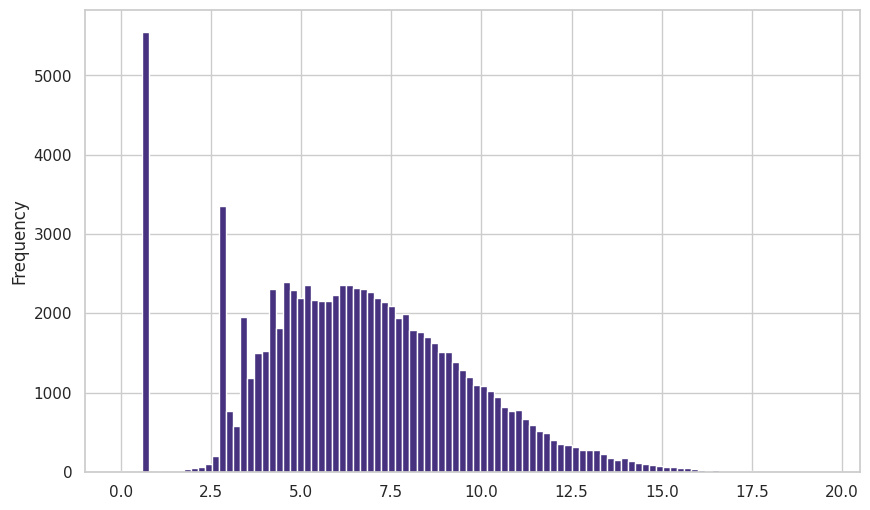

In [ ]:
merged_data['copiesSold_log'].plot(kind='hist', bins=100, figsize=(10, 6))

In [ ]:
# for i in merged_data.columns:
#   merged_data.plot(x='copiesSold_scaled', y=i,kind='scatter')


<Axes: ylabel='Frequency'>

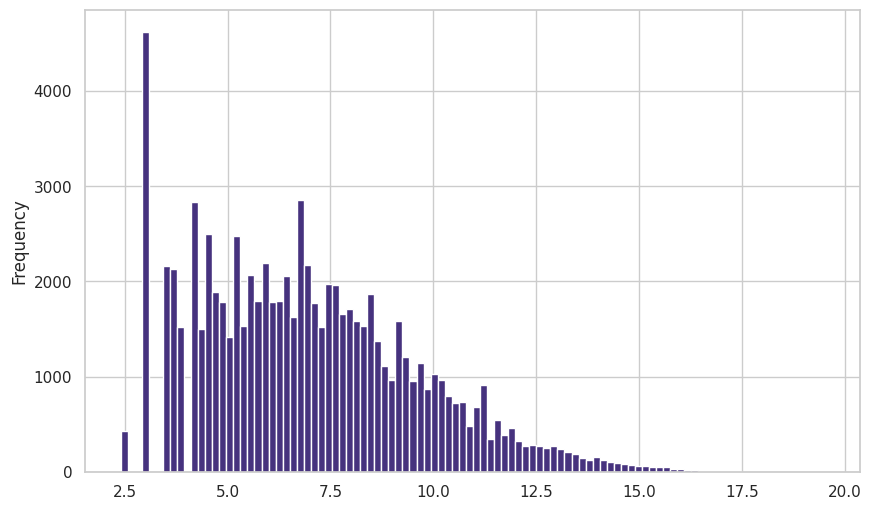

In [ ]:
merged_data[merged_data['copiesSold_dynamicly_rounded_log'] >1]['copiesSold_dynamicly_rounded_log'].plot(kind='hist', bins=100, figsize=(10, 6))

<Axes: ylabel='Frequency'>

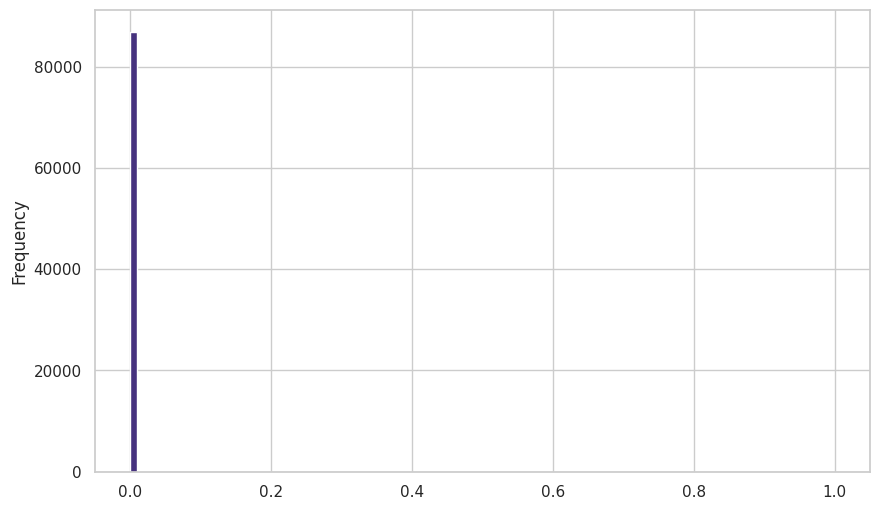

In [ ]:
merged_data['copiesSold_scaled'].plot(kind='hist', bins=100, figsize=(10, 6))

In [ ]:
for i in range(0, 10):
    lower = 10**(i-1)
    upper = 10**i
    count = len(merged_data[merged_data['copiesSold'] <= upper]['copiesSold']) - len(merged_data[merged_data['copiesSold'] <= lower]['copiesSold'])
    print(upper, count)


1 5549
10 222
100 16975
1000 26495
10000 21801
100000 11366
1000000 3772
10000000 987
100000000 89
1000000000 3


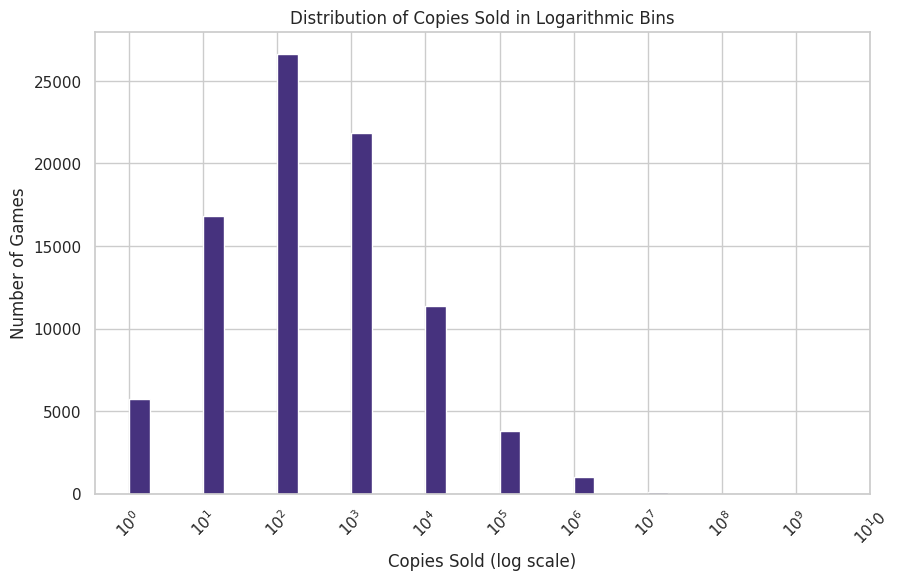

In [ ]:
# Define bin edges and calculate counts
bin_edges = [10**i for i in range(11)]  # 1, 10, 100, ..., 10^10
counts, _ = np.histogram(merged_data['copiesSold'], bins=bin_edges)

# Plot with aligned bars
plt.figure(figsize=(10, 6))
plt.bar(bin_edges[:-1], counts, width=np.array(bin_edges[:-1])*0.9, align='edge')  # Width as 90% of bin size
plt.xscale('log')
plt.xticks(bin_edges, labels=[f'$10^{i}$' for i in range(11)], rotation=45)
plt.xlabel('Copies Sold (log scale)')
plt.ylabel('Number of Games')
plt.title('Distribution of Copies Sold in Logarithmic Bins')
plt.show()

In [ ]:
clean_data

,price,copiesSold,reviewScore,metacritic,steam_achievements,steam_trading_cards,workshop_support,achievements_total,has_metacritic,has_dlc,has_demo,is_free,windows,mac,linux,months_passed,days_passed,years_passed,month,day,year,date_category,price_category,premium_score,premium_score_review_interaction,price_review_interaction,metacritic_review_interaction,price_reviewScore_ratio,price_metacritic_ratio,premium_steam_cards_ratio,price_premium_ratio,price_steam_achievements_ratio,review_metacritic_alignment,achievements_per_day,price_premium_content_ratio,review_per_dollar,metacritic_per_dollar_exp,metacritic_per_dollar,support_features_ratio,achievement_review_ratio,dlc_value_ratio,free_engagement,mature_achievements,review_consensus,time_weighted_quality,price_review_ratio,price_yeo,copiesSold_yeo,reviewScore_yeo,metacritic_log,metacritic_per_dollar_log,achievements_total_log,days_passed_log,reviewScore_log,price_log,copiesSold_log,encoded_supported_platforms,encoded_publisherClass,encoded_genres,encoded_sorted_genres,encoded_copiesSold_class,merged_workshop_and_cards_more_false,merged_workshop_and_cards_more_true,price_reviewScore,price_metacritic,copiesSold_rounded_thousand,copiesSold_rounded_thousand_log,copiesSold_scaled,copiesSold_dynamicly_rounded,copiesSold_dynamicly_rounded_log
0,0.00,302158048,87,0.0,True,True,True,1,False,False,False,True,True,False,True,152,4606,13,8,21,2012,3,0,2,174,0.0,0.0,0.00,0.00,1.0,0.00,0.000,87.000000,0.000216,0.00,87.0,0.000000e+00,0.0,1.0,0.011364,0.0,True,0.118549,0.13,0.000000,0.00,-1.609811,3.770845,0.528988,0.000000,0.000000,0.693147,8.435332,4.477337,0.000000,19.526461,3,1,722,0,2,True,True,0.0,0.0,302158000,19.526461,1.000000,302000000,19.525938
1,0.00,212896574,82,90.0,False,True,True,0,True,False,False,True,True,True,True,141,4284,12,7,9,2013,3,0,3,246,0.0,7380.0,0.00,0.00,1.5,0.00,0.000,0.901099,0.000000,0.00,82.0,1.220403e+39,90.0,1.0,0.000000,0.0,True,0.000000,0.92,34.103086,0.00,-1.609811,3.684180,0.299381,4.510860,4.510860,0.000000,8.362876,4.418841,0.000000,19.176317,4,1,967,63,2,True,True,0.0,0.0,212897000,19.176319,0.704587,213000000,19.176803
2,0.00,161971233,59,0.0,True,False,False,37,False,False,False,True,True,False,False,88,2658,8,12,21,2017,3,0,0,0,0.0,0.0,0.00,0.00,0.0,0.00,0.000,59.000000,0.013765,0.00,59.0,0.000000e+00,0.0,0.0,0.016667,0.0,False,4.692034,0.41,0.000000,0.00,-1.609811,3.616014,-0.680833,0.000000,0.000000,3.637586,7.885705,4.094345,0.000000,18.902929,6,1,412,1,2,False,False,0.0,0.0,161971000,18.902928,0.536048,162000000,18.903107
3,0.00,99060457,90,92.0,True,True,True,520,True,False,False,True,True,False,True,210,6383,18,10,10,2007,3,0,3,270,0.0,8280.0,0.00,0.00,1.5,0.00,0.000,0.967742,0.081085,0.00,90.0,9.017628e+39,92.0,1.0,0.010989,0.0,True,59.350228,0.98,30.710354,0.00,-1.609811,3.492312,0.669375,4.532599,4.532599,6.255750,8.761550,4.510860,0.000000,18.411241,3,1,722,0,2,True,True,0.0,0.0,99060000,18.411236,0.327843,99100000,18.411640
4,0.00,67554185,67,88.0,True,True,False,12,True,False,False,True,True,False,False,53,1609,5,11,4,2020,3,0,2,134,0.0,5896.0,0.00,0.00,1.0,0.00,0.000,0.752809,0.007322,0.00,67.0,1.651636e+38,88.0,1.0,0.014706,0.0,True,1.625138,0.79,45.223054,0.00,-1.609811,3.395010,-0.354807,4.488636,4.488636,2.564949,7.383989,4.219508,0.000000,18.028441,6,1,258,1,2,False,True,0.0,0.0,67554000,18.028438,0.223572,67600000,18.029119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89422,4.99,0,0,0.0,False,False,False,0,False,False,False,False,True,False,False,89,2703,8,11,6,2017,3,1,0,0,0.0,0.0,4.99,4.99,0.0,4.99,4.990,0.000000,0.000000,4.99,0.0,0.000000e+00,0.0,0.0,0.000000,0.0,False,0.000000,1.00,0.000000,4.99,0.104608,-2.336770,-2.362403,0.000000,0.000000,0.000000,7.902487,0.000000,1.790091,0.000000,6,2

In [ ]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87268 entries, 0 to 89426
Data columns (total 70 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   price                                 87268 non-null  float64
 1   copiesSold                            87268 non-null  int64  
 2   reviewScore                           87268 non-null  int64  
 3   metacritic                            87268 non-null  float64
 4   steam_achievements                    87268 non-null  bool   
 5   steam_trading_cards                   87268 non-null  bool   
 6   workshop_support                      87268 non-null  bool   
 7   achievements_total                    87268 non-null  int64  
 8   has_metacritic                        87268 non-null  bool   
 9   has_dlc                               87268 non-null  bool   
 10  has_demo                              87268 non-null  bool   
 11  is_free             

In [ ]:
clean_data.describe()

,price,copiesSold,reviewScore,metacritic,achievements_total,months_passed,days_passed,years_passed,month,day,year,date_category,price_category,premium_score,premium_score_review_interaction,price_review_interaction,metacritic_review_interaction,price_reviewScore_ratio,price_metacritic_ratio,premium_steam_cards_ratio,price_premium_ratio,price_steam_achievements_ratio,review_metacritic_alignment,achievements_per_day,price_premium_content_ratio,review_per_dollar,metacritic_per_dollar_exp,metacritic_per_dollar,support_features_ratio,achievement_review_ratio,dlc_value_ratio,mature_achievements,review_consensus,time_weighted_quality,price_review_ratio,price_yeo,copiesSold_yeo,reviewScore_yeo,metacritic_log,metacritic_per_dollar_log,achievements_total_log,days_passed_log,reviewScore_log,price_log,copiesSold_log,encoded_supported_platforms,encoded_publisherClass,encoded_genres,encoded_sorted_genres,encoded_copiesSold_class,price_reviewScore,price_metacritic,copiesSold_rounded_thousand,copiesSold_rounded_thousand_log,copiesSold_scaled,copiesSold_dynamicly_rounded,copiesSold_dynamicly_rounded_log
count,87268.000000,8.726800e+04,87268.000000,87268.000000,87268.000000,87268.000000,87268.000000,87268.000000,87268.000000,87268.000000,87268.000000,87268.000000,87268.000000,87268.000000,87268.000000,87268.000000,87268.000000,87268.000000,87268.000000,87268.000000,87268.000000,87268.000000,87268.000000,87257.000000,87268.000000,87268.000000,8.726800e+04,87268.000000,87268.000000,87268.000000,87268.000000,8.720900e+04,87268.000000,87268.000000,87268.000000,8.726800e+04,8.726800e+04,8.726800e+04,87268.000000,87268.000000,87268.000000,8.722900e+04,87268.000000,87268.000000,87268.000000,87268.000000,87268.000000,87268.000000,87268.000000,87268.000000,87268.000000,87268.000000,8.726800e+04,87268.000000,8.726800e+04,8.726800e+04,87268.000000
mean,8.017113,8.155777e+04,72.927534,3.178416,20.775886,48.580488,1463.540725,4.263006,6.575583,15.852661,2020.736994,2.345190,1.490478,0.268117,21.024282,580.152580,259.594078,0.575327,7.279358,0.181241,6.700085,5.494591,69.494551,0.025621,6.700085,23.027366,2.244755e+35,0.342097,0.051025,0.023371,0.019851,inf,0.300761,1.494758,0.575327,2.133224e-16,2.709683e-16,3.022339e-16,0.185844,0.079121,1.620366,-inf,4.055829,1.673945,6.563002,5.508388,2.340239,1037.336653,66.757574,1.178542,580.152580,56.330245,8.155586e+04,6.161709,2.699176e-04,8.155418e+04,6.527585
std,15.499095,1.648406e+06,26.668258,15.105998,164.316891,38.075071,1158.777362,3.191124,3.470623,8.956457,3.191124,0.790741,0.990421,0.590902,48.207793,991.750781,1264.327840,7.558681,15.247755,0.390167,14.714901,11.990302,30.188374,0.106750,14.714901,26.644552,3.497875e+37,3.235493,0.148820,0.125684,0.377276,NaN,0.293152,7.529020,7.558681,1.000006e+00,1.000006e+00,1.000006e+00,0.875074,0.397284,1.622375,NaN,1.087644,1.031661,3.002362,0.871740,0.662566,578.079600,38.777803,1.283669,991.750781,333.396087,1.648406e+06,3.607746,5.455445e-03,1.648239e+06,3.081469
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-7.000000,-214.000000,0.000000,1.000000,1.000000,1997.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-1.609811e+00,-2.336770e+00,-2.362403e+00,0.000000,0.000000,0.000000,-inf,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000
25%,0.990000,9.200000e+01,62.000000,0.000000,0.000000,16.000000,481.000000,2.000000,3.000000,8.000000,2019.000000,2.000000,1.000000,0.000000,0.000000,66.330000,0.000000,0.020729,0.990000,0.000000,0.990000,0.990000,57.000000,0.000000,0.990000,5.509182,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.080000,0.000000,0.020729,-9.564580e-01,-6.598889e-01,-5.605468e-01,0.000000,0.000000,0.000000,6.180017e+00,4.143135,0.688135,4.532599,5.000000,

# Data Visualization


Relation between copies sold and price as categories

<ipython-input-281-15342d359e0d>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


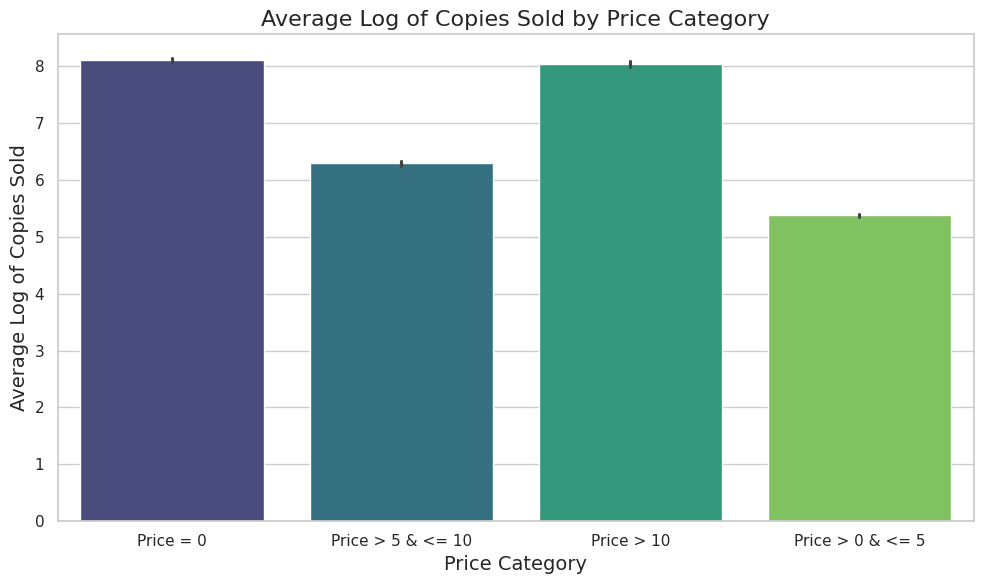

In [ ]:
price_order = ['Free', 'Cheap', 'Medium', 'Expensive']
descriptions = {
    0: 'Price = 0',               # For 'Free'
    1: 'Price > 0 & <= 5',        # For 'Cheap'
    2: 'Price > 5 & <= 10',       # For 'Medium'
    3: 'Price > 10'               # For 'Expensive'
}

merged_data['price_category_label'] = merged_data['price_category'].map(descriptions)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=merged_data,
    x='price_category_label',
    y='copiesSold_log',
    estimator='mean',
    palette='viridis'
)

plt.title('Average Log of Copies Sold by Price Category', fontsize=16)
plt.xlabel('Price Category', fontsize=14)
plt.ylabel('Average Log of Copies Sold', fontsize=14)

plt.tight_layout()
plt.show()


show the copies sold avreage with price categories

<ipython-input-282-51f8a9f2ee6a>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


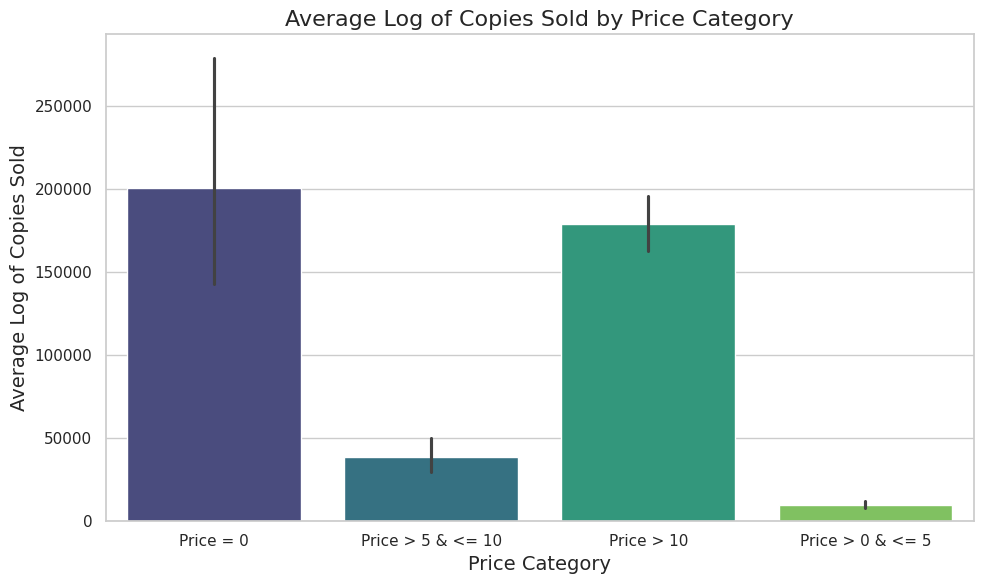

In [ ]:
price_order = ['Free', 'Cheap', 'Medium', 'Expensive']
descriptions = {
    0: 'Price = 0',               # For 'Free'
    1: 'Price > 0 & <= 5',        # For 'Cheap'
    2: 'Price > 5 & <= 10',       # For 'Medium'
    3: 'Price > 10'               # For 'Expensive'
}

merged_data['price_category_label'] = merged_data['price_category'].map(descriptions)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=merged_data,
    x='price_category_label',
    y='copiesSold',
    estimator='mean',
    palette='viridis'
)

plt.title('Average Log of Copies Sold by Price Category', fontsize=16)
plt.xlabel('Price Category', fontsize=14)
plt.ylabel('Average Log of Copies Sold', fontsize=14)

plt.tight_layout()
plt.show()


count number of games in each price category

<ipython-input-283-205a8dbe0c12>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


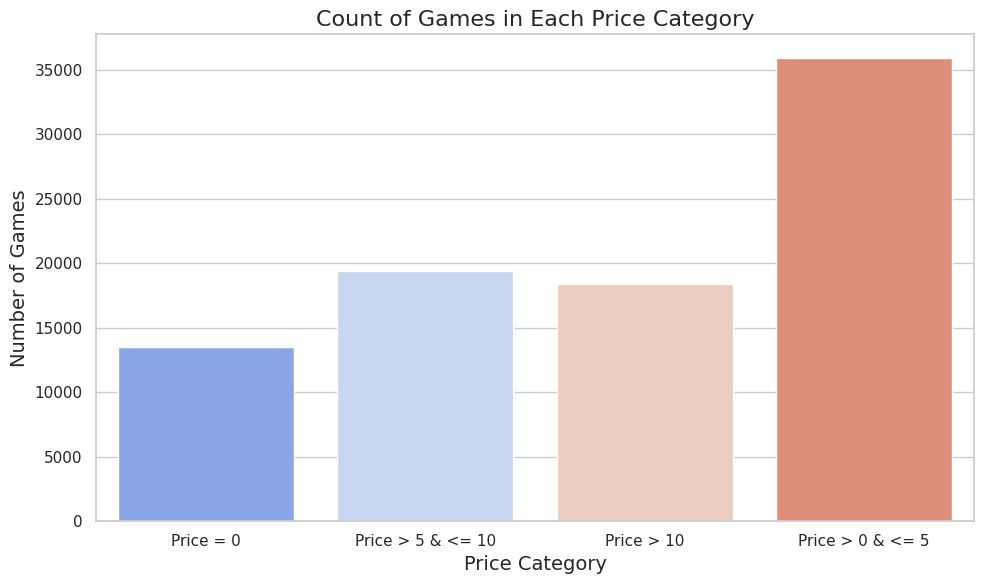

In [ ]:
price_order = ['Free', 'Cheap', 'Medium', 'Expensive']
descriptions = {
    0: 'Price = 0',               # For 'Free'
    1: 'Price > 0 & <= 5',        # For 'Cheap'
    2: 'Price > 5 & <= 10',       # For 'Medium'
    3: 'Price > 10'               # For 'Expensive'
}

merged_data['price_category_label'] = merged_data['price_category'].map(descriptions)

plt.figure(figsize=(10, 6))
sns.countplot(
    data=merged_data,
    x='price_category_label',
    palette='coolwarm'
)


plt.title('Count of Games in Each Price Category', fontsize=16)
plt.xlabel('Price Category', fontsize=14)
plt.ylabel('Number of Games', fontsize=14)


plt.tight_layout()
plt.show()


show number of games released with categories of date

<ipython-input-284-cab8b3d672da>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


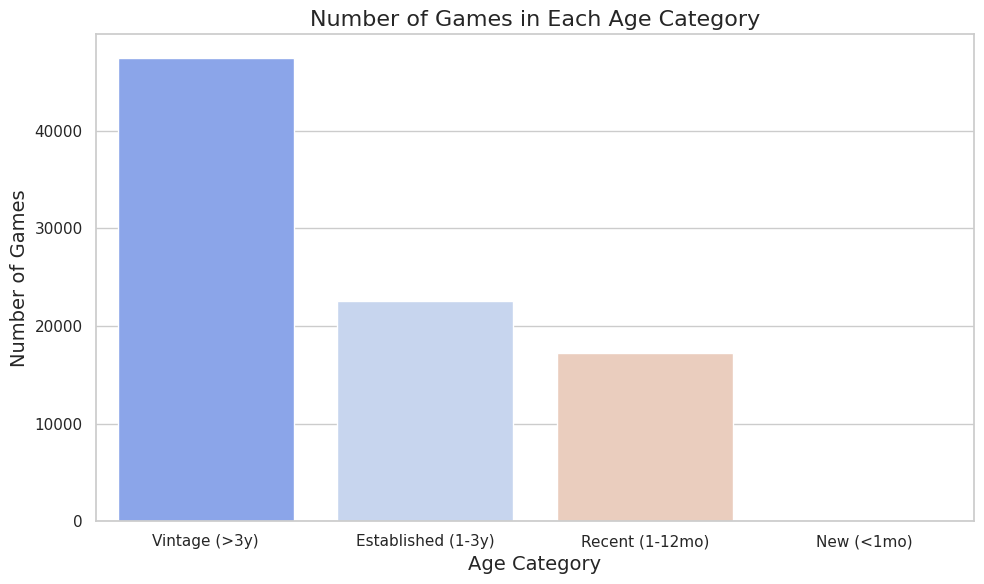

In [ ]:

category_labels = ['New (<1mo)', 'Recent (1-12mo)', 'Established (1-3y)', 'Vintage (>3y)']
merged_data['date_category_label'] = merged_data['date_category'].map(
    {0: 'New (<1mo)', 1: 'Recent (1-12mo)', 2: 'Established (1-3y)', 3: 'Vintage (>3y)'}
)


plt.figure(figsize=(10, 6))
sns.countplot(
    data=merged_data,
    x='date_category_label',
    palette='coolwarm'
)

plt.title('Number of Games in Each Age Category', fontsize=16)
plt.xlabel('Age Category', fontsize=14)
plt.ylabel('Number of Games', fontsize=14)

plt.tight_layout()
plt.show()


Number of Released Games per Month

<ipython-input-285-b3038adbca18>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


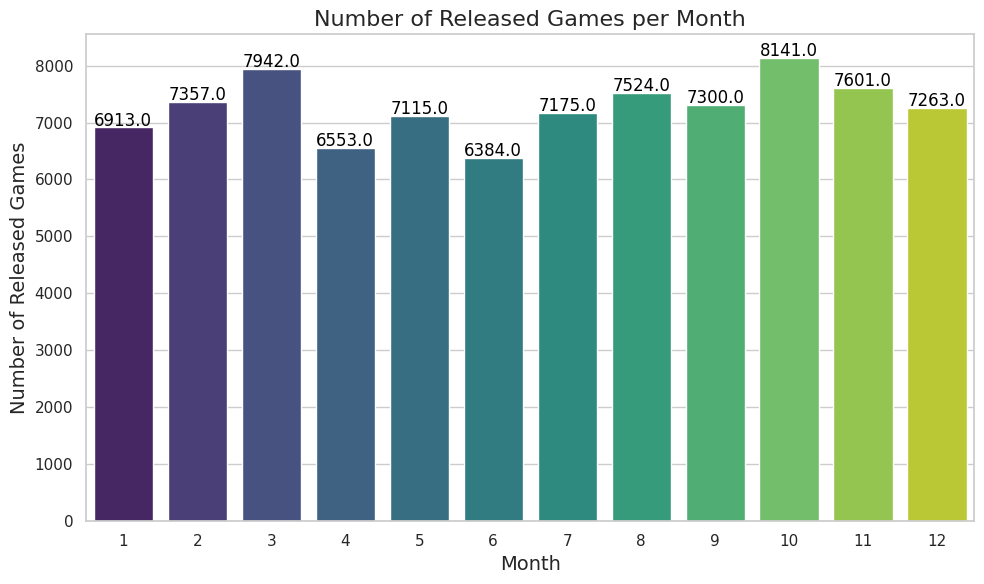

In [ ]:

plt.figure(figsize=(10, 6))
ax = sns.countplot(
    data=merged_data,
    x='month',
    hue=None,
    palette='viridis'
)


for p in ax.patches:
    ax.annotate(
        f'{p.get_height()}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center',
        fontsize=12, color='black',
        xytext=(0, 5), textcoords='offset points'
    )


plt.title('Number of Released Games per Month', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of Released Games', fontsize=14)


plt.subplots_adjust(bottom=0.15, top=0.85)
plt.tight_layout()

plt.show()


Number of Released Games per year

<ipython-input-286-b3b660826050>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


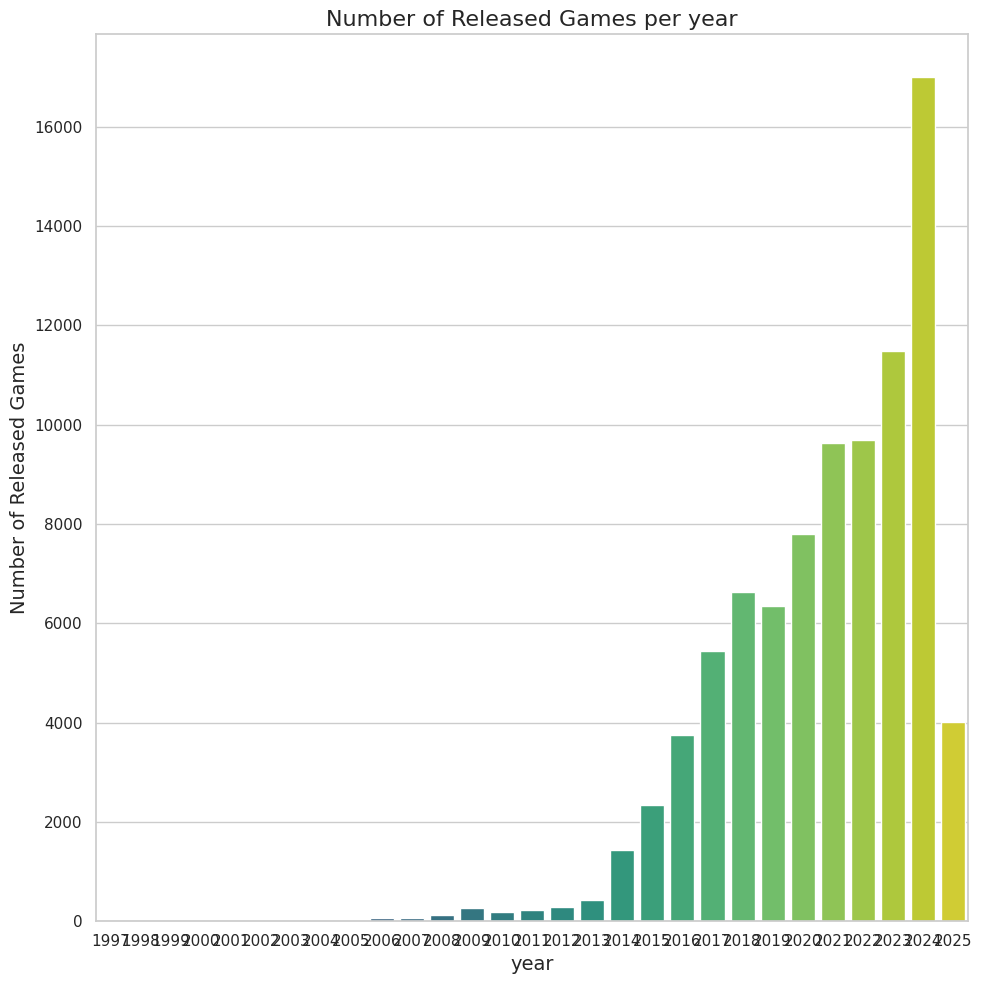

In [ ]:
plt.figure(figsize=(10, 10))
sns.countplot(
    data=merged_data,
    x='year',
    palette='viridis'
)

plt.title('Number of Released Games per year', fontsize=16)
plt.xlabel('year', fontsize=14)
plt.ylabel('Number of Released Games', fontsize=14)

plt.tight_layout()
plt.show()


show the game features with mean of copies sold log

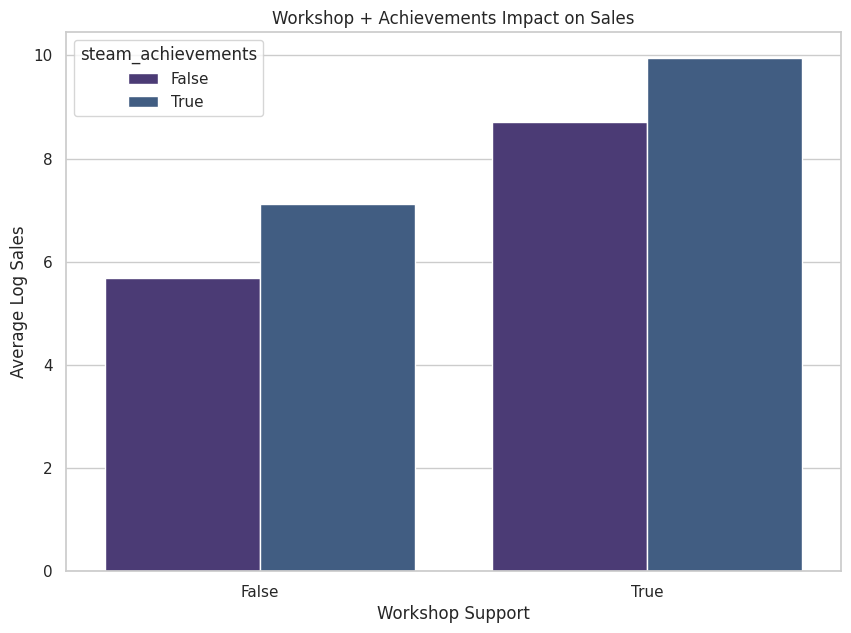

In [ ]:
grouped = clean_data.groupby(['workshop_support', 'steam_achievements'])['copiesSold_dynamicly_rounded_log'].mean().reset_index()

plt.figure(figsize=(10, 7))
sns.barplot(
    data=grouped,
    x='workshop_support',
    y='copiesSold_dynamicly_rounded_log',
    hue='steam_achievements'
)
plt.title("Workshop + Achievements Impact on Sales")
plt.xlabel("Workshop Support")
plt.ylabel("Average Log Sales")
plt.show()


Average Log of Copies Sold vs. Years Since Release

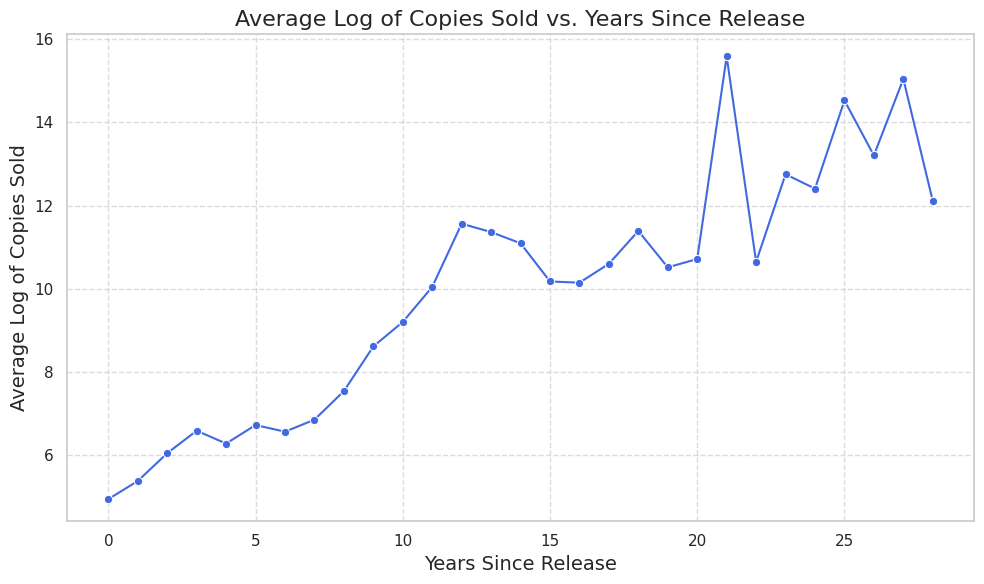

In [ ]:

clean_data['years_passed_rounded'] = clean_data['years_passed'].round()
grouped = clean_data.groupby('years_passed_rounded')['copiesSold_log'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=grouped,
    x='years_passed_rounded',
    y='copiesSold_log',
    marker='o',
    color='royalblue'
)

plt.title('Average Log of Copies Sold vs. Years Since Release', fontsize=16)
plt.xlabel('Years Since Release', fontsize=14)
plt.ylabel('Average Log of Copies Sold', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Average Log of Copies Sold by DLC/Demo Combination

<ipython-input-289-f06f45f3e473>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


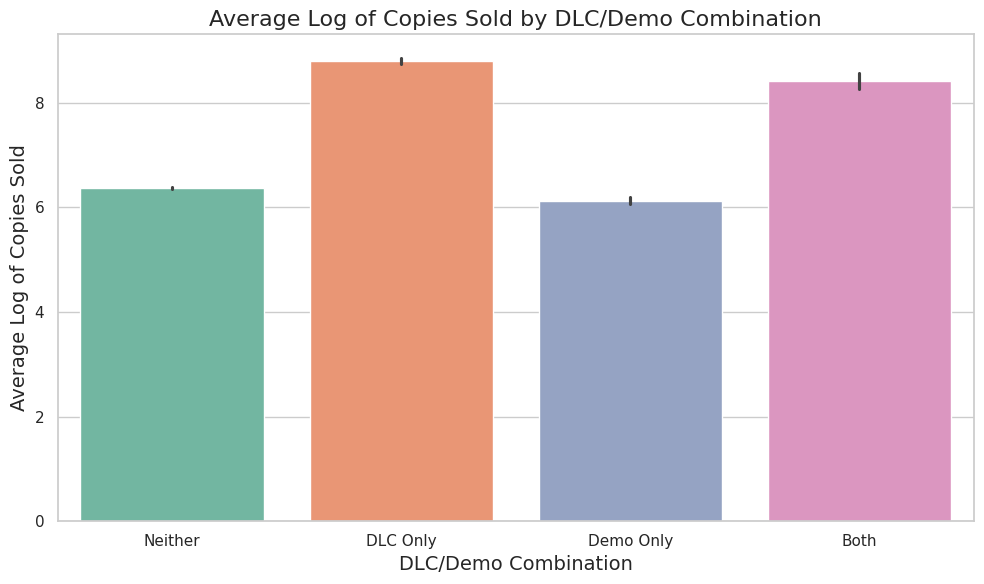

In [ ]:
merged_data['dlc_demo_combination'] = merged_data.apply(
    lambda row: 'Both' if row['has_dlc'] and row['has_demo']
    else ('DLC Only' if row['has_dlc']
          else ('Demo Only' if row['has_demo']
                else 'Neither')), axis=1
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=merged_data,
    x='dlc_demo_combination',
    y='copiesSold_log',
    estimator='mean',
    palette='Set2'
)

plt.title('Average Log of Copies Sold by DLC/Demo Combination', fontsize=16)
plt.xlabel('DLC/Demo Combination', fontsize=14)
plt.ylabel('Average Log of Copies Sold', fontsize=14)

plt.tight_layout()
plt.show()


Game Sales by Platform Support

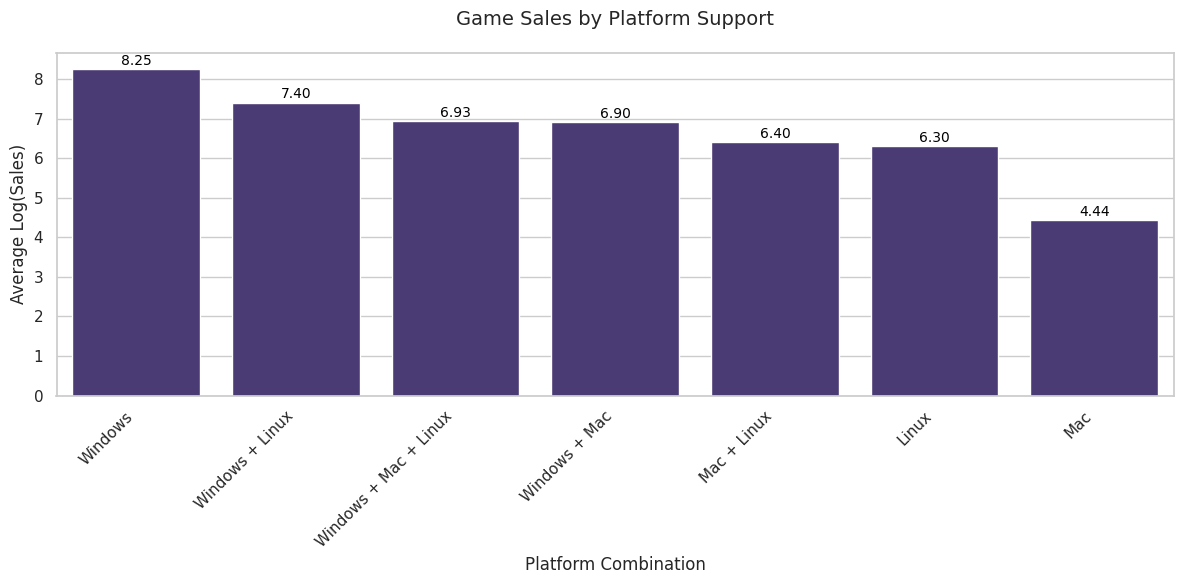

In [ ]:

sns.set(style="whitegrid", palette="viridis")
platform_labels = {
    0: "Windows + Mac + Linux",
    1: "Windows",
    2: "Mac",
    3: "Linux",
    4: "Windows + Mac",
    5: "Windows + Linux",
    6: "Mac + Linux",
    7: "All Platforms"
}

clean_data['platform_label'] = clean_data['encoded_supported_platforms'].map(platform_labels)
platform_sales = (clean_data.groupby('platform_label')['copiesSold_log']
                  .mean()
                  .sort_values(ascending=False))

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=platform_sales.index,
                y=platform_sales.values,
                order=platform_sales.index)


plt.title("Game Sales by Platform Support", fontsize=14, pad=20)
plt.xlabel("Platform Combination", fontsize=12)
plt.ylabel("Average Log(Sales)", fontsize=12)
plt.xticks(rotation=45, ha='right')


for i, value in enumerate(platform_sales.values):
    ax.text(i, value + 0.03, f"{value:.2f}",
            ha='center', va='bottom',
            fontsize=10, color='black')

plt.tight_layout()
plt.show()
clean_data.drop(columns=['platform_label'], inplace=True)

Review Score Distribution with KDE

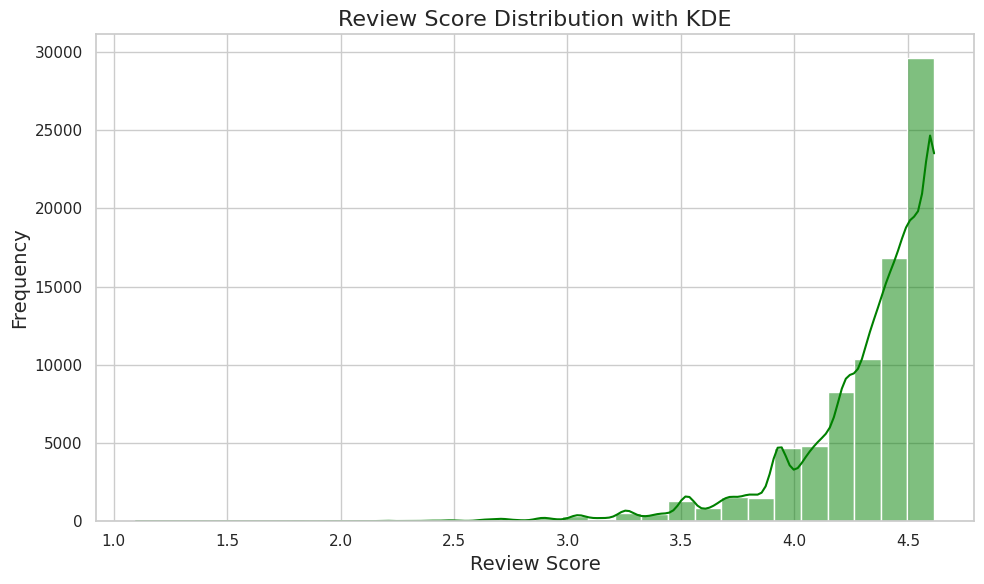

In [ ]:

plt.figure(figsize=(10, 6))
sns.histplot(
    data=merged_data[merged_data['reviewScore'] > 0],
    x='reviewScore_log',
    kde=True,
    color='green',
    bins=30
)

plt.title('Review Score Distribution with KDE', fontsize=16)
plt.xlabel('Review Score', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.tight_layout()
plt.show()


Price Distribution with KDE

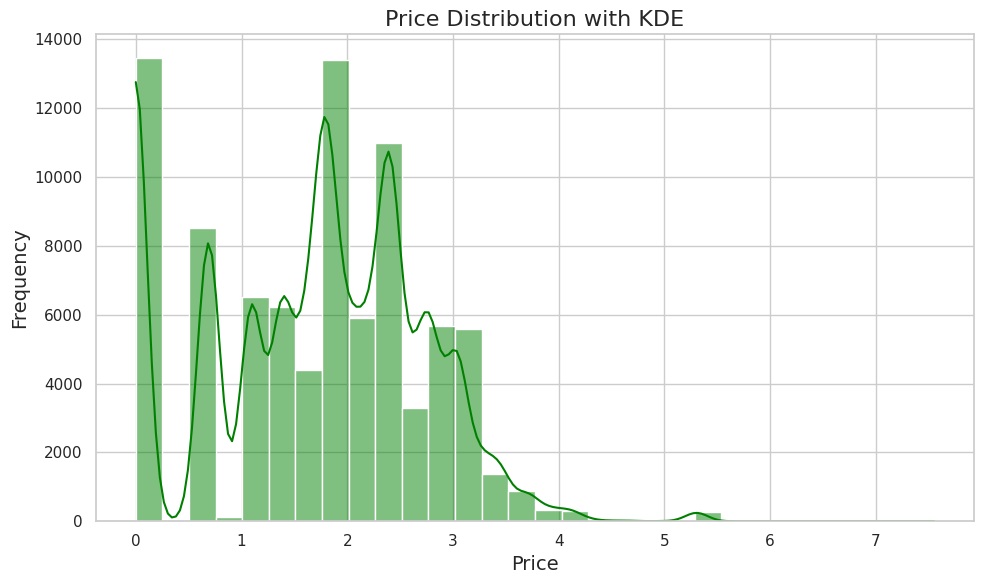

In [ ]:

plt.figure(figsize=(10, 6))
sns.histplot(
    data=merged_data,
    x='price_log',
    kde=True,
    color='green',
    bins=30
)

plt.title('Price Distribution with KDE', fontsize=16)
plt.xlabel('Price', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.tight_layout()
plt.show()


# Modeling

In [ ]:
clean_data.columns

Index(['price', 'copiesSold', 'reviewScore', 'metacritic', 'steam_achievements', 'steam_trading_cards', 'workshop_support', 'achievements_total', 'has_metacritic', 'has_dlc', 'has_demo', 'is_free', 'windows', 'mac', 'linux', 'months_passed', 'days_passed', 'years_passed', 'month', 'day', 'year', 'date_category', 'price_category', 'premium_score', 'premium_score_review_interaction', 'price_review_interaction', 'metacritic_review_interaction', 'price_reviewScore_ratio', 'price_metacritic_ratio', 'premium_steam_cards_ratio', 'price_premium_ratio', 'price_steam_achievements_ratio', 'review_metacritic_alignment', 'achievements_per_day', 'price_premium_content_ratio', 'review_per_dollar', 'metacritic_per_dollar_exp', 'metacritic_per_dollar', 'support_features_ratio', 'achievement_review_ratio', 'dlc_value_ratio', 'free_engagement', 'mature_achievements', 'review_consensus', 'time_weighted_quality', 'price_review_ratio', 'price_yeo', 'copiesSold_yeo', 'reviewScore_yeo', 'metacritic_log',
    

In [ ]:
clean_data.corr()['copiesSold_log'].sort_values(ascending=False)

,copiesSold_log
copiesSold_log,1.000000
copiesSold_yeo,0.998809
copiesSold_dynamicly_rounded_log,0.998472
copiesSold_rounded_thousand_log,0.965314
encoded_copiesSold_class,0.540871
premium_score_review_interaction,0.486969
premium_score,0.485019
premium_steam_cards_ratio,0.449583
reviewScore_log,0.424826
merged_workshop_and_cards_more_true,0.415949


In [ ]:
clean_data.corr()['copiesSold'].sort_values(ascending=False)

,copiesSold
copiesSold,1.000000
copiesSold_scaled,1.000000
copiesSold_rounded_thousand,1.000000
copiesSold_dynamicly_rounded,0.999999
metacritic_per_dollar_exp,0.232308
metacritic_per_dollar,0.158016
copiesSold_log,0.144507
copiesSold_dynamicly_rounded_log,0.141365
copiesSold_yeo,0.131920
merged_workshop_and_cards_more_false,0.129092


## Check Functions

In [ ]:
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [ ]:
def fit_and_check(name, model, x_train, y_train, x_test, y_test, cv=5):
        print(f"🔧 {name} Regression")

        model.fit(x_train, y_train)
        y_pred_train = model.predict(x_train)
        y_pred_test = model.predict(x_test)

        cv_scores = cross_val_score(
        model, x_train, y_train, cv=cv, scoring=make_scorer(r2_score))
        print(f"    CV R²: {cv_scores.mean():.2f} (±{cv_scores.std():.2f})")

        print("    Train MSE:", mean_squared_error(y_train, y_pred_train))
        print("    Train R² :", r2_score(y_train, y_pred_train))
        print("    Test  MSE:", mean_squared_error(y_test, y_pred_test))
        print("    Test  R² :", r2_score(y_test, y_pred_test))
        print()

In [ ]:
def fit_and_check_log(name, model, x_train, y_train, x_test, y_test, y_train_actual, y_test_actual, cv=5):
    # Cross-validation
    print(f"🔧 {name} Regression")

    cv_scores = cross_val_score(
        model, x_train, y_train, cv=cv, scoring=make_scorer(r2_score)
    )
    print(f"  CV R²: {cv_scores.mean():.2f} (±{cv_scores.std():.2f})")

    # Model training
    model.fit(x_train, y_train)

    # Predictions
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)

    # if name == 'DecisionTree':
    #   node_weights = model.tree_.n_node_samples

    #   # Print node IDs and their weights
    #   for node_id, weight in enumerate(node_weights):
    #       print(f"Node {node_id}: Weight = {weight} samples")

    # Training metrics
    print()
    print(f"  Train MSE: {mean_squared_error(y_train, y_pred_train):.2f}")
    print(f"  Train R² : {r2_score(y_train, y_pred_train):.2f}")

    # Test metrics (log scale)
    y_test = np.array(y_test)
    indices = np.random.choice(len(y_test), size=3, replace=False)

    print()
    print(
          "  log actual :", [f"{x:.2f}" for x in y_test[indices]],
          "  predicted:", [f"{x:.2f}" for x in y_pred_test[indices]]
          )
    print(f"  log Test  MSE: {mean_squared_error(y_test, y_pred_test):.2f}")
    print(f"  log Test  R² : {r2_score(y_test, y_pred_test):.2f}")

    print()
    # Convert to actual scale
    residuals = y_train - y_pred_train
    bias_correction = np.median(np.exp(residuals))
    print(f"  Bias correction: {bias_correction:.2f}")
    y_pred_test_actual = np.round(np.expm1(y_pred_test) * bias_correction).astype(int)
    y_test_actual = np.array(y_test_actual)

    # Test metrics (actual scale)
    print("  actual:", [f"{x:.2f}" for x in y_test_actual[indices]],
          "  predicted:", [f"{x:.2f}" for x in y_pred_test_actual[indices]],
          )

    # print(f"  exp Test RMSLE: {rmsle(y_test_actual, y_pred_test_actual):.2f}")
    print(f"  exp Test MSE: {mean_squared_error(y_test_actual, y_pred_test_actual):.2f}")
    print(f"  exp Test R² : {r2_score(y_test_actual, y_pred_test_actual):.2f}")

    plt.figure(figsize=(10, 6))

    # Scatter plot with semi-transparent points
    plt.scatter(y_test_actual, y_pred_test_actual,
                alpha=0.3, label='Predictions')

    # Perfect prediction line
    max_val = max(np.max(y_test_actual), np.max(y_pred_test_actual))
    plt.plot([0, max_val], [0, max_val], 'r--', label='Perfect Prediction')

    plt.title(f'{name} Regression: Actual vs Predicted Values')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    print("\n" + "="*60 + "\n")
    print()
    print()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


def fit_and_check_classification(name, model, x_train, y_train, x_test, y_test, cv=5):
    print(f"🔧 {name} Classification")

    model.fit(x_train, y_train, )
# Drop features with near-zero SHAP importance
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)

    # Predict probabilities for multi-class AUC
    y_proba_train = model.predict_proba(x_train)
    y_proba_test = model.predict_proba(x_test)

    # Training metrics
    print("    Train Accuracy:", accuracy_score(y_train, y_pred_train))
    print("    Train Precision:", precision_score(y_train, y_pred_train, average='weighted'))
    print("    Train Recall:", recall_score(y_train, y_pred_train, average='weighted'))
    print("    Train F1:", f1_score(y_train, y_pred_train, average='weighted'))
    print("    Train AUC:", roc_auc_score(y_train, y_proba_train, multi_class='ovr'))

    # Test metrics
    print("\n    Test Accuracy:", accuracy_score(y_test, y_pred_test))
    print("    Test Precision:", precision_score(y_test, y_pred_test, average='weighted'))
    print("    Test Recall:", recall_score(y_test, y_pred_test, average='weighted'))
    print("    Test F1:", f1_score(y_test, y_pred_test, average='weighted'))
    print("    Test AUC:", roc_auc_score(y_test, y_proba_test, multi_class='ovr'))

    # Confusion matrix with custom labels
    cm = confusion_matrix(y_test, y_pred_test)
    class_names = ["bronze", "gold", "platinum", "silver"]  # Add your label mapping

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=class_names  # Set custom labels
    )

    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks(rotation=45)  # Rotate labels if needed
    plt.yticks(rotation=45)
    plt.show()

    print("\n" + "="*60 + "\n")

## Models

### Classification Models

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.feature_selection import f_classif
from sklearn.metrics import mutual_info_score

# Function for Cramer's V (categorical vs. categorical)
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min((k-1), (r-1)))

# Function for Eta Squared (categorical vs. numerical)
def eta_squared(x, y):
    categories = x.unique()
    group_arrays = [y[x == cat] for cat in categories]
    return stats.f_oneway(*group_arrays)[0] / y.var()

# Initialize results storage
results = []

# Target column
target = clean_data['encoded_copiesSold_class']

# Analyze relationships with other columns
for col in clean_data.columns:
    if col == 'copiesSold_class':
        continue

    data = clean_data[col].dropna()
    current_target = target.loc[data.index]

    # Handle numerical columns
    if np.issubdtype(clean_data[col].dtype, np.number) and (clean_data[col].nunique() > 10):
        try:
            # ANOVA F-statistic
            F, _ = f_classif(clean_data[[col]], target)
            results.append({
                'Feature': col,
                'Type': 'Numerical',
                'Correlation_Type': 'ANOVA F-statistic',
                'Value': F[0],
                'Interpretation': 'Higher values = stronger relationship'
            })

            # Eta Squared
            eta = eta_squared(current_target, data)
            results.append({
                'Feature': col,
                'Type': 'Numerical',
                'Correlation_Type': 'Eta Squared',
                'Value': eta,
                'Interpretation': f"{'Small' if eta < 0.06 else 'Medium' if eta < 0.14 else 'Large'} effect"
            })
        except:
            pass

    # Handle categorical/bool columns
    else:
        # Cramer's V for categorical-categorical
        if clean_data[col].nunique() > 1:
            try:
                cv = cramers_v(data, current_target)
                results.append({
                    'Feature': col,
                    'Type': 'Categorical' if clean_data[col].dtype == 'object' else 'Boolean',
                    'Correlation_Type': "Cramer's V",
                    'Value': cv,
                    'Interpretation': f"{'Weak' if cv < 0.1 else 'Moderate' if cv < 0.3 else 'Strong'} association"
                })
            except:
                pass

        # Mutual Information
        try:
            mi = mutual_info_score(data, current_target)
            results.append({
                'Feature': col,
                'Type': 'Categorical' if clean_data[col].dtype == 'object' else 'Boolean',
                'Correlation_Type': 'Mutual Information',
                'Value': mi,
                'Interpretation': 'Higher values = stronger dependency'
            })
        except:
            pass

# Create results DataFrame
results_df = pd.DataFrame(results).sort_values(by=['Correlation_Type', 'Value'], ascending=False)
results_df

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)


,Feature,Type,Correlation_Type,Value,Interpretation
115,encoded_copiesSold_class,Boolean,Mutual Information,1.217697e+00,Higher values = stronger dependency
109,encoded_publisherClass,Boolean,Mutual Information,1.908149e-01,Higher values = stronger dependency
47,premium_score,Boolean,Mutual Information,1.280211e-01,Higher values = stronger dependency
59,premium_steam_cards_ratio,Boolean,Mutual Information,1.233102e-01,Higher values = stronger dependency
75,support_features_ratio,Boolean,Mutual Information,9.894371e-02,Higher values = stronger dependency
11,steam_trading_cards,Boolean,Mutual Information,9.076235e-02,Higher values = stronger dependency
119,merged_workshop_and_cards_more_true,Boolean,Mutual Information,9.048128e-02,Higher values = stronger dependency
45,price_category,Boolean,Mutual Information,8.033950e-02,Higher values = stronger dependency
17,has_metacritic,Boolean,Mutual Information,5.553098e-02,Higher values = stronger dependency
43,date_category,Boolean,Mutual Information,3.164775e-02,Higher values = stronger dependency


In [ ]:
! pip install catboost
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier
)
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier  # Add this line

models = {
    # Linear Models
    # "Multinomial Logistic": LogisticRegression(
    #     solver='sag',
    #     max_iter=3000,
    #     penalty='l2'
    # ),

    # "SGD (One-vs-Rest)": OneVsRestClassifier(
    #     SGDClassifier(loss='log_loss',
    #                   max_iter=1000,
    #                   early_stopping=True,
    #                   random_state=10)
    # ),


    # # Tree-Based
    # "Random Forest": RandomForestClassifier(
    #     n_estimators=300,
    #     max_depth=8,
    #     class_weight='balanced',
    #     n_jobs=-1
    # ),

    "XGBoost": XGBClassifier(
        objective='multi:softprob',  # or 'multi:softprob'
        num_class=4,  # ← Set to your number of classes
        n_estimators=500,
        learning_rate=0.1,
        max_depth=6,
        tree_method='hist',
        n_jobs=-1
    ),

    # "CatBoost": CatBoostClassifier(
    #     iterations=1000,
    #     learning_rate=0.05,
    #     depth=6,
    #     silent=True,
    #     auto_class_weights='Balanced',
    #     loss_function='MultiClass'
    # ),

    # "LightGBM": LGBMClassifier(
    #     objective='multiclass',
    #     num_class=4,  # ← Set to your number of classes
    #     n_estimators=300,
    #     learning_rate=0.05,
    #     max_depth=7,
    #     class_weight='balanced'
    # ),

    # Gradient Boosting
    "Hist Gradient Boosting": HistGradientBoostingClassifier(
        max_iter=200,
        learning_rate=0.05,
        max_depth=6,
        early_stopping=True
    ),

    # # Others
    # "KNN": make_pipeline(
    #     StandardScaler(),
    #     KNeighborsClassifier(n_neighbors=15)
    # ),
        # SVM Family
# "RBF SVM": make_pipeline(
#     StandardScaler(),
#     SVC(
#         kernel='rbf',
#         C=1.0,
#         gamma='scale',
#         class_weight='balanced',
#         decision_function_shape='ovr'  # Explicitly set OvR if needed
#     )
# )

    # Uncomment for:
    # "Decision Tree": DecisionTreeClassifier(
    #     max_depth=5,
    #     min_samples_leaf=10,
    #     class_weight='balanced'
    # ),
    # "Naive Bayes": GaussianNB(),
}

In [ ]:
merged_data['encoded_copiesSold_class'].value_counts()

,count
encoded_copiesSold_class,
0,40914
3,24586
1,14445
2,7323


In [ ]:
clean_data.columns

Index(['price', 'copiesSold', 'reviewScore', 'metacritic', 'steam_achievements', 'steam_trading_cards', 'workshop_support', 'achievements_total', 'has_metacritic', 'has_dlc', 'has_demo', 'is_free', 'windows', 'mac', 'linux', 'months_passed', 'days_passed', 'years_passed', 'month', 'day', 'year', 'date_category', 'price_category', 'premium_score', 'premium_score_review_interaction', 'price_review_interaction', 'metacritic_review_interaction', 'price_reviewScore_ratio', 'price_metacritic_ratio', 'premium_steam_cards_ratio', 'price_premium_ratio', 'price_steam_achievements_ratio', 'review_metacritic_alignment', 'achievements_per_day', 'price_premium_content_ratio', 'review_per_dollar', 'metacritic_per_dollar_exp', 'metacritic_per_dollar', 'support_features_ratio', 'achievement_review_ratio', 'dlc_value_ratio', 'free_engagement', 'mature_achievements', 'review_consensus', 'time_weighted_quality', 'price_review_ratio', 'price_yeo', 'copiesSold_yeo', 'reviewScore_yeo', 'metacritic_log',
    

In [ ]:
# 'price_log', 'reviewScore_log', 'metacritic_log',  'steam_trading_cards', 'encoded_sorted_genres', 'encoded_publisherClass', 'premium_score_review_interaction',
#       'workshop_support', 'achievements_total_log', 'has_dlc', 'has_demo', 'is_free', 'encoded_supported_platforms', 'year', 'metacritic_review_interaction'

encoded_copiesSold_class

🔧 XGBoost Classification
    Train Accuracy: 0.7770934196579483
    Train Precision: 0.7815647285602028
    Train Recall: 0.7770934196579483
    Train F1: 0.7766759665063907
    Train AUC: 0.9388354939459582

    Test Accuracy: 0.7057980978572247
    Test Precision: 0.7077808328363856
    Test Recall: 0.7057980978572247
    Test F1: 0.7045626393540856
    Test AUC: 0.8969701674352698


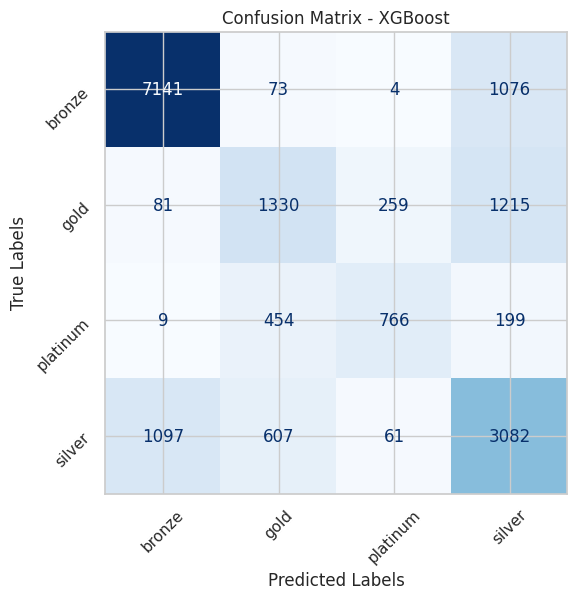



🔧 Hist Gradient Boosting Classification
    Train Accuracy: 0.723637092846707
    Train Precision: 0.7252236585757708
    Train Recall: 0.723637092846707
    Train F1: 0.7220591588270057
    Train AUC: 0.9113889284908292

    Test Accuracy: 0.7011000343760743
    Test Precision: 0.7034068942578908
    Test Recall: 0.7011000343760743
    Test F1: 0.699736872837114
    Test AUC: 0.8960916151809242


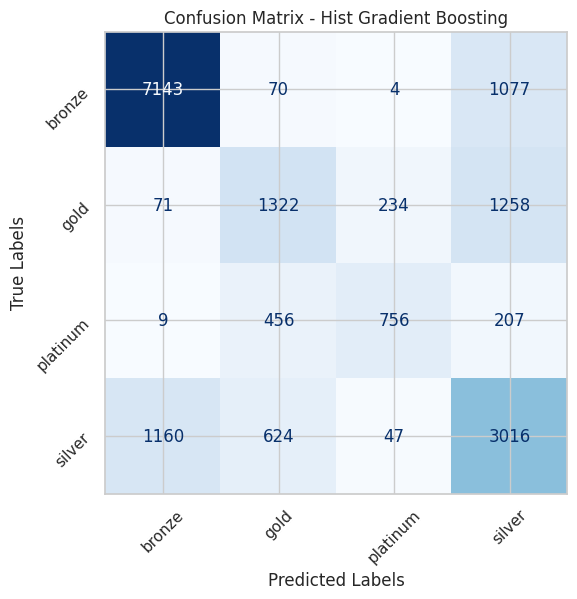

In [ ]:
x = \
[
  'price_log', 'reviewScore_log', 'metacritic_log',  'steam_trading_cards', 'encoded_sorted_genres', 'encoded_publisherClass', 'premium_score_review_interaction',
  'workshop_support', 'achievements_total_log', 'has_dlc', 'has_demo', 'is_free', 'encoded_supported_platforms', 'year', 'metacritic_review_interaction'
]

y = 'encoded_copiesSold_class'

X = merged_data[x]
y = merged_data[y]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print("encoded_copiesSold_class")
print()
for name, model in models.items():
  fit_and_check_classification(name, model, X_train, y_train, X_test, y_test, 10)


In [ ]:
.

SyntaxError: invalid syntax (<ipython-input-306-a5d5b61aa8a6>, line 1)

### Regression Models

In [ ]:
!pip install -q catboost scikit-learn matplotlib seaborn pandas numpy

from catboost import CatBoostRegressor, CatBoostClassifier

models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(alpha=1.0, solver='svd'),
    "catboost": CatBoostRegressor(
        iterations=1000,
        learning_rate=0.1,
        depth=6,
        silent=True  # Disables progress printing
    ),
    # "Lasso": Lasso(alpha=1.0),
    # "Bayesian": BayesianRidge(),
    # "ElasticNet": ElasticNet(alpha=1.0, l1_ratio=0.5),
    # "SVR": make_pipeline(
    #                   StandardScaler(),
    #                   SVR(kernel='rbf', C=1.0, epsilon=0.1)
    #               ),
#     "Nystroem":  make_pipeline(
#                 StandardScaler(),
#                 Nystroem(kernel='rbf', n_components=300),  # Approximates RBF kernel
#                 SGDRegressor(max_iter=1000, tol=1e-4)
#             ),
#     "linearSVR": make_pipeline(
#     StandardScaler(),
#     LinearSVR(C=1.0, epsilon=0.1, max_iter=10000, random_state=42)
# ),
#     # "Possoine": PoissonRegressor(),
    # "DecisionTree": DecisionTreeRegressor(
    #     random_state=42,
    #     min_samples_leaf=10,      # Minimum samples per leaf
    # ),
    # "RandomForest": RandomForestRegressor(n_estimators=100, random_state=0),
    # "XGBRegressor": XGBRegressor(objective='reg:squarederror', tree_method='hist', n_estimators=500)
}

In [ ]:
#copiesSold_log/ polynomial regression/  R² Score: 0.5431974615759905/ ['price', 'reviewScore', 'metacritic', 'steam_achievements', 'steam_trading_cards', 'workshop_support', 'achievements_total', 'months passed']
#copiesSold_log/ polynomial regression 3rd/ R² Score: 0.7005038838182831/['is_free', 'reviewScore', 'steam_achievements', 'steam_trading_cards', 'workshop_support',  'days passed', 'metacritic', 'has_dlc', 'encoded_publisherClass', 'price_log', 'has_demo']
#copiesSold_log/ polynomial ridge regression 2nd/ log R² score: 0.517 R² score: 0.67/ ['is_free', 'reviewScore', 'steam_achievements', 'steam_trading_cards','workshop_support', 'days_passed', 'metacritic', 'has_dlc','encoded_publisherClass', 'price_log', 'has_demo', 'has_metacritic','encoded_supported_platforms']
# random state = 0

#### Copies Sold Log

In [ ]:
clean_data.columns

In [ ]:
# ....#stop fkoof
#'price_log', 'reviewScore', 'metacritic', 'steam_achievements', 'steam_trading_cards', 'workshop_support', 'achievements_total', 'has_dlc', 'has_demo', 'is_free', 'months_passed'
# 'price_log', 'reviewScore_log', 'metacritic_log',  'steam_trading_cards', 'price_reviewScore_ratio', 'encoded_sorted_genres',
      #'workshop_support', 'achievements_total_log', 'has_dlc', 'has_demo', 'is_free', 'encoded_supported_platforms', 'months_passed', 'metacritic_review_interaction'

In [ ]:
x = [
'price_log', 'reviewScore_log', 'metacritic_log',  'steam_trading_cards', 'encoded_sorted_genres',
      'workshop_support', 'achievements_total_log', 'has_dlc', 'has_demo', 'is_free', 'encoded_supported_platforms', 'months_passed', 'metacritic_review_interaction'
]
y = 'copiesSold_log'

X = merged_data[x]
y = merged_data[y]

random_state = 0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
_, _, y_train_actual, y_test_actual = train_test_split(X, merged_data['copiesSold'], test_size=0.2, random_state=random_state)


print("copiesSold_log")
print()

print("🔹 Base models (no polynomial features):")
for name, model in models.items():
  fit_and_check_log(name, model, X_train, y_train, X_test, y_test, y_train_actual, y_test_actual)

print("🔹 Polynomial Regression (degrees 1 to 3):")
for degree in range(2, 4):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    print(f"📐 Polynomial degree: {degree}")
    for name, model in models.items():
      if name not in ["RandomForest", "DecisionTree"]:
          fit_and_check_log(name, model, X_train_poly, y_train, X_test_poly, y_test, y_train_actual, y_test_actual)


##### all combinations

In [ ]:
# import itertools
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error, r2_score
# import numpy as np

# # Assuming merged_data and models are already defined
# x = ['price', 'reviewScore', 'metacritic', 'steam_achievements', 'steam_trading_cards', 'workshop_support', 'achievements_total', 'has_metacritic', 'has_dlc', 'has_demo', 'is_free', 'months_passed', 'encoded_supported_platforms', 'encoded_publisherClass', 'price_log']
# y = 'copiesSold_log'

# X = clean_data[x]
# y = clean_data[y]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# print("copiesSold_log")
# print()

# # Variables to track the best combination
# best_combination = None
# best_log_r2 = -np.inf  # Initialize with very low value
# best_actual_r2 = -np.inf  # Initialize with very low value
# best_model_name = None

# def fit_and_check_log(name, model, X_train, Y_train, X_test, Y_test, subset=None):
#     # Fit the model
#     model.fit(X_train, Y_train)

#     y_pred_train = model.predict(X_train)
#     y_pred_test = model.predict(X_test)

#     print(f"🔧 {name} Regression")

#     train_mse = mean_squared_error(Y_train, y_pred_train)
#     train_r2 = r2_score(Y_train, y_pred_train)

#     Y_test = np.array(Y_test)
#     indices = np.random.choice(len(Y_test), size=3, replace=False)

#     log_test_mse = mean_squared_error(Y_test, y_pred_test)
#     log_test_r2 = r2_score(Y_test, y_pred_test)

#     y_pred_test_actual = np.exp(y_pred_test)
#     y_test_actual = np.exp(Y_test)

#     exp_test_mse = mean_squared_error(y_test_actual, y_pred_test_actual)
#     exp_test_r2 = r2_score(y_test_actual, y_pred_test_actual)

#     # Track the best combination of columns
#     global best_combination, best_log_r2, best_actual_r2, best_model_name

#     if exp_test_r2 > best_actual_r2:
#         best_combination = subset  # Store the best combination of columns
#         best_log_r2 = log_test_r2
#         best_actual_r2 = exp_test_r2
#         best_model_name = name

#     print("  Train MSE:", train_mse)
#     print("  Train R² :", train_r2)
#     print("  log Test  MSE:", log_test_mse)
#     print("  log Test  R² :", log_test_r2)
#     print("  actual:", y_pred_test_actual[indices], "  predicted:", y_test_actual[indices])
#     print("  exp Test MSE:", exp_test_mse)
#     print("  exp Test R² :", exp_test_r2)
#     print()

#     return exp_test_r2, log_test_r2  # Return both actual and log R²


# print("🔹 Base models (no polynomial features):")
# # Generate all combinations of features in `x`
# for r in range(10, 12 + 1):  # from 1 feature to all features
#     for subset in itertools.combinations(x, r):  # generate combinations of size r
#         X_subset = X[list(subset)]  # Select the features based on the combination
#         print(f"🔹 Combinations of columns: {subset}")

#         for name, model in models.items():
#             fit_and_check_log(name, model, X_train[list(subset)], y_train, X_test[list(subset)], y_test, subset)
#         # Print the best combination and its performance
#     print(f"Best Combination of Columns: {best_combination}")
#     print(f"Best Model: {best_model_name}")
#     print(f"Best log R²: {best_log_r2}")
#     print(f"Best actual R²: {best_actual_r2}")

# print("🔹 Polynomial Regression (degrees 1 to 3):")

# # Polynomial regression with degrees from 2 to 3
# for degree in range(2, 4):
#     poly = PolynomialFeatures(degree=degree, include_bias=False)
#     X_train_poly = poly.fit_transform(X_train)
#     X_test_poly = poly.transform(X_test)

#     print(f"📐 Polynomial degree: {degree}")

#     for r in range(10, 12 + 1):  # from 1 feature to all features
#         for subset in itertools.combinations(x, r):  # generate combinations of size r
#             X_subset_poly = poly.transform()  # Apply polynomial features to subset
#             print(f"🔹 Combinations of columns: {subset}")

#             for name, model in models.items():
#                 if name not in ["RandomForest", "DecisionTree"]:  # Skip these models for polynomial
#                     fit_and_check_log(name, model, X_train_poly[list(subset)], y_train, X_test_poly[list(subset)], y_test, subset)
#         # Print the best combination and its performance
#         print(f"Best Combination of Columns: {best_combination}")
#         print(f"Best Model: {best_model_name}")
#         print(f"Best log R²: {best_log_r2}")
#         print(f"Best actual R²: {best_actual_r2}")

# # Print the best combination and its performance
# print(f"Best Combination of Columns: {best_combination}")
# print(f"Best Model: {best_model_name}")
# print(f"Best log R²: {best_log_r2}")
# print(f"Best actual R²: {best_actual_r2}")


In [ ]:
# # 1. Import libraries
# import xgboost as xgb
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error, r2_score

# # 2. Assume clean_data is already loaded and cleaned

# # 3. Common features
# features = ['is_free', 'reviewScore', 'steam_achievements', 'steam_trading_cards', 'workshop_support',  'days_passed', 'metacritic', 'has_dlc', 'encoded_publisherClass', 'price_log', 'has_demo']
# #features=['workshop_support','has_metacritic','metacritic']
# # 4. Try with both targets
# targets = ['copiesSold_log','copiesSold']  # or any two columns you want

# for target in targets:
#     print(f"\n📌 Results for target: {target}")

#     X = merged_data[features]
#     y = merged_data[target]

#     # 5. Split
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=64)

#     # 6. Model
#     model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.01, max_depth=12)
#     model.fit(X_train, y_train)

#     # 7. Predict and Evaluate
#     y_pred = model.predict(X_test)
#     y_train_pred= model.predict(X_train)
#     mse = mean_squared_error(y_test, y_pred)
#     mse_train = mean_squared_error(y_train, y_train_pred)
#     r2 = r2_score(y_test, y_pred)
#     r2_train = r2_score(y_train, y_train_pred)
#     train_score = model.score(X_train, y_train)
#     test_score = model.score(X_test, y_test)
#     print(f"Mean Squared Error (Train): {mse_train:.2f}")
#     print(f"Mean Squared Error (Test): {mse:.2f}")
#     print(f"Model Score (Train R²): {train_score:.2f}")
#     print(f"Model Score (Test R²): {test_score:.2f}")


In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import PolynomialFeatures, StandardScaler
# from sklearn.linear_model import Ridge
# from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.pipeline import Pipeline
# import numpy as np
# import matplotlib.pyplot as plt
# import joblib
# features = ['price', 'reviewScore', 'metacritic', 'steam_achievements', 'steam_trading_cards', 'workshop_support', 'achievements_total', 'months_passed']
# #features=['workshop_support','has_metacritic','metacritic']
# # 4. Try with both targets
# targets = ['copiesSold']  # or any two columns you want
# # Split your data into train, validation, and test sets
# x=merged_data[features]
# y=merged_data[targets]
# X_train_full, X_test, y_train_full, y_test = train_test_split(x, y, test_size=0.2, random_state=35)
# X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=35)

# # Create polynomial features (degree 2 worked best in your tests)
# poly = PolynomialFeatures(degree=2, include_bias=False)
# scaler = StandardScaler()  # Add scaling to help with the ill-conditioned matrix

# # Apply transformations
# X_train_poly = poly.fit_transform(X_train)
# X_val_poly = poly.transform(X_val)
# X_test_poly = poly.transform(X_test)

# # Scale the polynomial features
# X_train_poly_scaled = scaler.fit_transform(X_train_poly)
# X_val_poly_scaled = scaler.transform(X_val_poly)
# X_test_poly_scaled = scaler.transform(X_test_poly)

# # Improved early stopping function with alpha tuning
# def ridge_with_early_stopping(X_train, y_train, X_val, y_val, alphas=[0.01, 0.1, 1.0, 10.0, 100.0],
#                              max_iter=200, tol=1e-4, patience=10):
#     best_model = None
#     best_val_error = float('inf')
#     best_alpha = None
#     best_iter = 0

#     # Try different alpha values for regularization strength
#     for alpha in alphas:
#         print(f"Trying alpha={alpha}")
#         model = Ridge(alpha=alpha, max_iter=max_iter, solver='auto', random_state=35)

#         # Fit the model explicitly
#         model.fit(X_train, y_train)

#         # Calculate validation error
#         val_pred = model.predict(X_val)
#         val_error = mean_squared_error(y_val, val_pred)

#         print(f"  Alpha {alpha} validation MSE: {val_error:.2f}")

#         # Check if this is the best model so far
#         if val_error < best_val_error:
#             best_val_error = val_error
#             best_model = model
#             best_alpha = alpha

#     print(f"\nBest model found with alpha={best_alpha}, validation MSE: {best_val_error:.2f}")

#     # Re-fit the model on combined train+validation data with best params
#     best_model = Ridge(alpha=best_alpha, max_iter=max_iter, solver='auto', random_state=35)
#     best_model.fit(np.vstack((X_train, X_val)), np.concatenate((y_train, y_val)))

#     return best_model, best_alpha, best_val_error

# # Train with improved approach
# print("Training model with regularization tuning...")
# best_model, best_alpha, best_val_error = ridge_with_early_stopping(
#     X_train_poly_scaled, y_train, X_val_poly_scaled, y_val,
#     alphas=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
# )

# # Make sure the model is fitted
# if not hasattr(best_model, 'coef_'):
#     print("Model not properly fitted. Training again with best alpha...")
#     best_model = Ridge(alpha=best_alpha, max_iter=1000, solver='auto', random_state=35)
#     best_model.fit(np.vstack((X_train_poly_scaled, X_val_poly_scaled)),
#                   np.concatenate((y_train, y_val)))

# # Evaluate the best model on test data
# y_test_pred = best_model.predict(X_test_poly_scaled)
# test_mse = mean_squared_error(y_test, y_test_pred)
# test_r2 = r2_score(y_test, y_test_pred)

# print("\n🔹 Results with Optimal Regularization:")
# print(f"🔧 Ridge Regression with Polynomial Features (degree 2)")
# print(f"  Best alpha: {best_alpha}")
# print(f"  Test MSE: {test_mse:.4f}")
# print(f"  Test R²: {test_r2:.4f}")

# # Save the best model with scaler and polynomial transformer
# pipeline = Pipeline([
#     ('polynomial', poly),
#     ('scaler', scaler),
#     ('ridge', best_model)
# ])

# joblib.dump(pipeline, 'best_ridge_pipeline.pkl')
# print("\nBest model pipeline saved as 'best_ridge_pipeline.pkl'")

# # Optional: Plot feature importance - Fixed version
# plt.figure(figsize=(12, 6))
# # Get the actual feature names that were used when fitting
# try:
#     # This is the safer way to get feature names
#     feature_names = poly.get_feature_names_out()

#     coef = best_model.coef_
#     # Sort by absolute value
#     indices = np.argsort(np.abs(coef))[-20:]  # Show top 20 most important features
#     plt.bar(range(len(indices)), coef[indices])
#     plt.xticks(range(len(indices)), feature_names[indices], rotation=90)
#     plt.title('Top 20 Feature Importance')
#     plt.tight_layout()
#     plt.show()
# except Exception as e:
#     print(f"Could not plot feature importance: {e}")
#     # Alternative approach - just plot coefficients without labels
#     coef = best_model.coef_
#     plt.figure(figsize=(10, 6))
#     plt.bar(range(len(coef)), np.sort(np.abs(coef))[-20:])
#     plt.title('Top 20 Feature Coefficients (by magnitude)')
#     plt.xlabel('Feature Index')
#     plt.ylabel('Coefficient Magnitude')
#     plt.tight_layout()
#     plt.show()

In [ ]:
# X = merged_data[['price', 'metacritic', 'steam_achievements', 'steam_trading_cards', 'achievements_total', 'has_metacritic', 'has_dlc', 'has_demo', 'is_free', 'months_passed','price_log']]
# y = merged_data['copiesSold_log']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# model = models['Ridge'].fit(X_train, y_train)

# y_pred_train = model.predict(X_train)
# y_pred_test = model.predict(X_test)

# print(f"🔧 {name} Regression")
# print("  Train MSE:", mean_squared_error(y_train, y_pred_train))
# print("  Train R² :", r2_score(y_train, y_pred_train))
# print(" log Test  MSE:", mean_squared_error(y_test, y_pred_test))
# print(" log Test  R² :", r2_score(y_test, y_pred_test))

# y_pred_test_actual = np.exp(y_pred_test)
# y_test_actual = np.exp(y_test)

# print()
# print(np.random.choice(y_pred_test_actual, size=3, replace=False),  np.random.choice(y_test_actual, size=3, replace=False))

# print(" exp Test MSE:", mean_squared_error(y_test_actual, y_pred_test_actual))
# print(" exp Test R² :", r2_score(y_test_actual, y_pred_test_actual))
# print()

In [ ]:
# clean_data.corr()['copiesSold'].sort_values(ascending=False)

In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.metrics import mean_squared_error, r2_score
# import numpy as np

# # Assuming merged_data exists and contains these features
# x = ['price_log', 'reviewScore', 'metacritic', 'steam_achievements', 'steam_trading_cards'
#      , 'achievements_total', 'months_passed', 'encoded_publisherClass',
#      'is_free', 'has_demo', 'has_dlc']
# y = 'copiesSold'

# # Extract features and target
# X = merged_data[x]
# Y = merged_data[y]


# # Split the data
# X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=0)

# # Linear regression on original data
# lr_model = LinearRegression()
# lr_model.fit(X_train, Y_train)
# y_pred = lr_model.predict(X_test)
# print("Linear regression on original data:")
# print("R² score:", r2_score(Y_test, y_pred))
# print("MSE:", mean_squared_error(Y_test, y_pred))

# # Sample a few predictions to show
# indices = np.random.choice(len(Y_test), size=3, replace=False)
# print("\nSample predictions:")
# print("Actual:", np.array(Y_test)[indices])
# print("Predicted:", y_pred[indices])

# # Polynomial regression
# print("\nPolynomial regression on original data:")
# for degree in range(2, 5):
#     print(f"\nDegree {degree}:")
#     poly = PolynomialFeatures(degree=degree, include_bias=False)
#     X_train_poly = poly.fit_transform(X_train)
#     X_test_poly = poly.transform(X_test)

#     # Fit model
#     poly_model = LinearRegression()
#     poly_model.fit(X_train_poly, Y_train)

#     # Predictions
#     y_poly_pred = poly_model.predict(X_test_poly)
#     print(f"R² score: {r2_score(Y_test, y_poly_pred)}")
#     print(f"MSE: {mean_squared_error(Y_test, y_poly_pred)}")

#     # Sample predictions
#     print("Sample predictions:")
#     print("Actual:", np.array(Y_test)[indices])
#     print("Predicted:", y_poly_pred[indices])

#### Copies Sold

In [ ]:
clean_data.columns

In [ ]:
x = ['price', 'reviewScore', 'metacritic',  'steam_trading_cards', 'workshop_support', 'achievements_total', 'has_dlc', 'has_demo', 'is_free', 'days_passed'
]
y = 'copiesSold'
#nothing change after FE
X = merged_data[x]
y = merged_data[y]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


print("copiesSold")
print()

print("🔹 Base models (no polynomial features):")
for name, model in models.items():
  fit_and_check(name, model, X_train, y_train, X_test, y_test, 10)

print("🔹 Polynomial Regression (degrees 1 to 3):")
for degree in range(2, 4):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    print(f"📐 Polynomial degree: {degree}")
    for name, model in models.items():
      if name not in ["RandomForest", "DecisionTree"]:
          fit_and_check(name, model, X_train_poly, y_train, X_test_poly, y_test, 10)
